In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Input,InputLayer, Concatenate, concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from plot_keras_history import show_history, plot_history
import keras
import pydot
import graphviz

In [3]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_sp_sps.csv', index_col=0)
print(df.shape)
df.tail()

(8282, 9)


,travel time,real travel time,euc_dist,distance,hour of day,O lat,O lon,D lat,D lon
8277,764,777.0,0.106760,13975.498,17,49.300370,18.785076,49.395589,18.833356
8278,1023,1033.0,0.107164,13882.472,9,49.300198,18.784969,49.201965,18.742139
8279,960,970.0,0.115124,12709.790,15,49.300306,18.784926,49.214926,18.707700
8280,1349,1418.0,0.138872,22283.246,18,49.300349,18.784947,49.438676,18.772652
8281,393,402.0,0.049918,6337.100,19,49.300177,18.784904,49.338404,18.817005


In [4]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])

df = df.drop(['travel time','euc_dist'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df.columns

Index(['hour of day', 'O lat', 'O lon', 'D lat', 'D lon', 'travel time',
       'distance'],
      dtype='object')

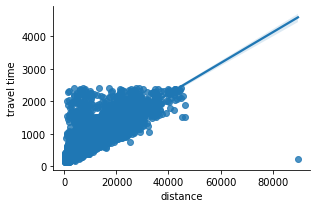

In [5]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [6]:
# outlier removal
from scipy import stats
df = df[(np.abs(stats.zscore(df['distance'])) < 3)]

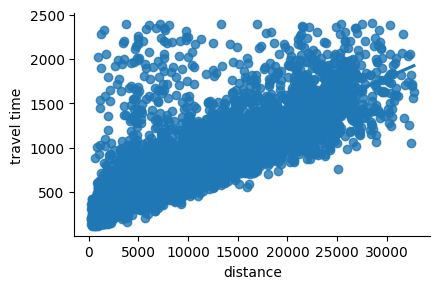

In [7]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [8]:
# Normalize using Min/Max Normalization.
normalized_Olat=(df['O lat']-df['O lat'].min())/(df['O lat'].max()-df['O lat'].min())
df['O lat'] = normalized_Olat
normalized_Dlat=(df['D lat']-df['D lat'].min())/(df['D lat'].max()-df['D lat'].min())
df['D lat'] = normalized_Dlat
normalized_Olon=(df['O lon']-df['O lon'].min())/(df['O lon'].max()-df['O lon'].min())
df['O lon'] = normalized_Olon
normalized_Dlon=(df['D lon']-df['D lon'].min())/(df['D lon'].max()-df['D lon'].min())
df['D lon'] = normalized_Dlon
normalized_Dist=(df['distance']-df['distance'].min())/(df['distance'].max()-df['distance'].min())
df['distance'] = normalized_Dist
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))
df

,hour of day,O lat,O lon,D lat,D lon,travel time,distance,hr_sin,hr_cos
0,16,0.271344,0.695530,0.227843,0.594750,1082.0,0.542630,-0.866025,-5.000000e-01
1,22,0.271862,0.695028,0.228745,0.595304,1110.0,0.531771,-0.500000,8.660254e-01
2,6,0.271862,0.694873,0.478251,0.402292,780.0,0.296433,1.000000,6.123234e-17
3,13,0.271466,0.695375,0.443682,0.373524,1255.0,0.427837,-0.258819,-9.659258e-01
4,17,0.271709,0.694988,0.494402,0.400281,606.0,0.312362,-0.965926,-2.588190e-01
...,...,...,...,...,...,...,...,...,...
8277,17,0.603718,0.554654,0.796721,0.494281,777.0,0.423759,-0.965926,-2.588190e-01
8278,9,0.603227,0.554462,0.450135,0.396053,1033.0,0.420897,0.707107,-7.071068e-01
8279,15,0.603535,0.554384,0.473335,0.358967,970.0,0.384812,-0.707107,-7.071068e-01
8280,18,0.603658,0.554422,0.873847,0.428911,1418.0,0.679393,-1.000000,-1.836970e-16


In [9]:
# df['distance'] = df['distance']/1000 #in km
# df['travel time'] = df['travel time']/60 #in minutes
# df

# Functional API keras model

In [10]:
np.random.seed(7)

In [11]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[1], activation='relu')(merge_two)
        second_dense = Dense(1, activation='relu',name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    elif num_hlayers == 2:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[2], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[3], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    else:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense  = Dense(num_neuron[2], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[3], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[4], activation='relu')(second_dense)
        second_dense = Dense(num_neuron[5], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])        

#     from keras.optimizers import SGD
#     opt = SGD(lr=0.01)
#     model.compile(loss = "categorical_crossentropy", optimizer = opt)       
        
    learning_rate = 0.05
    model.compile(optimizer='adam',
                  loss=[tf.keras.metrics.mean_squared_error,tf.keras.metrics.mean_squared_error],
                  loss_weights=[0.3,0.7],
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     model.compile(optimizer='adam',
#                   loss=tf.keras.metrics.mean_squared_error,
#                   metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit([X_train[:,0:4],X_train[:,4:]], [y_train[:,0],y_train[:,1]], verbose=1, epochs=Epoch,
                   validation_data=([X_test[:,0:4],X_test[:,4:]], [y_test[:,0],y_test[:,1]]))
    
    print('minimum testing RMSE (distance): ',min(history.history['val_distance_layer_rmse'])/1000)
    print('minimum testing MAPE (distance): ',min(history.history['val_distance_layer_mape'])/100)
    print('-----------------')
    print('minimum testing ravel time): ',min(history.history['val_traveltime_layer_rmse'])/60)
    print('minimum testing MAPE (travel time): ',min(history.history['val_traveltime_layer_mape'])/100)
    
    return history

## sub-problem 1:     ******* input: [] *********

In [12]:
x = df.loc[:,['O lat','O lon','D lat','D lon']].values
y = df.loc[:,['distance','travel time']].values
# x

In [13]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)
# X_train

(5720, 4)
(2452, 4)


In [15]:
def plotme(model):

    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['traveltime_layer_rmse']]
    val_loss1 = [f/60 for f in model.history['val_traveltime_layer_rmse']]
    loss2 = model.history['traveltime_layer_mape']
    val_loss2 = model.history['val_traveltime_layer_mape']
    val_loss2 = [x+1.8 for x in val_loss2]
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_traveltime_layer_mape'])
    plt.ylim([-1, yli+10])
    plt.legend()
    plt.show()

In [19]:
# inputs: distance
model1_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model1_1

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 567772.7500 - distance_layer_loss: 0.9357 - traveltime_layer_loss: 811103.3125 - distance_layer_mape: 121233.0938 - distance_layer_rmse: 0.9673 - traveltime_layer_mape: 99.7570 - traveltime_layer_rmse: 900.6127 - val_loss: 574045.3750 - val_distance_layer_loss: 4.0266 - val_traveltime_layer_loss: 820063.1875 - val_distance_layer_mape: 1780.5137 - val_distance_layer_rmse: 2.0066 - val_traveltime_layer_mape: 99.3291 - val_traveltime_layer_rmse: 905.5734
Epoch 2/500
179/179 [==============================] - 0s 995us/step - loss: 556132.2500 - distance_layer_loss: 20.5019 - traveltime_layer_loss: 794465.7500 - distance_layer_mape: 586638.4375 - distance_layer_rmse: 4.5279 - traveltime_layer_mape: 98.0508 - traveltime_layer_rmse: 891.3281 - val_loss: 551748.6250 - val_distance_layer_loss: 50.4238 - val_traveltime_layer_loss: 788190.5625 - val_distance_layer_mape: 5973.8057 - val_distance_layer_rmse: 7.1010 - val_tra

179/179 [==============================] - 0s 1ms/step - loss: 121749.9531 - distance_layer_loss: 3029.0784 - traveltime_layer_loss: 172630.2188 - distance_layer_mape: 6322239.5000 - distance_layer_rmse: 55.0371 - traveltime_layer_mape: 53.3253 - traveltime_layer_rmse: 415.4879 - val_loss: 126151.5469 - val_distance_layer_loss: 3000.6799 - val_traveltime_layer_loss: 178930.5625 - val_distance_layer_mape: 45087.3750 - val_distance_layer_rmse: 54.7785 - val_traveltime_layer_mape: 52.2805 - val_traveltime_layer_rmse: 423.0019
Epoch 17/500
179/179 [==============================] - 0s 996us/step - loss: 121604.2500 - distance_layer_loss: 2994.6790 - traveltime_layer_loss: 172436.9531 - distance_layer_mape: 6295630.0000 - distance_layer_rmse: 54.7237 - traveltime_layer_mape: 52.7920 - traveltime_layer_rmse: 415.2553 - val_loss: 125996.4219 - val_distance_layer_loss: 3028.4890 - val_traveltime_layer_loss: 178696.9375 - val_distance_layer_mape: 45299.8047 - val_distance_layer_rmse: 55.0317 - 

179/179 [==============================] - 0s 1ms/step - loss: 120474.4766 - distance_layer_loss: 2845.7114 - traveltime_layer_loss: 170886.8438 - distance_layer_mape: 6551996.0000 - distance_layer_rmse: 53.3452 - traveltime_layer_mape: 52.9687 - traveltime_layer_rmse: 413.3846 - val_loss: 124392.6406 - val_distance_layer_loss: 2861.6963 - val_traveltime_layer_loss: 176477.3594 - val_distance_layer_mape: 44108.2969 - val_distance_layer_rmse: 53.4948 - val_traveltime_layer_mape: 52.7843 - val_traveltime_layer_rmse: 420.0921
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 120371.4922 - distance_layer_loss: 2849.7786 - traveltime_layer_loss: 170737.9062 - distance_layer_mape: 6559663.0000 - distance_layer_rmse: 53.3833 - traveltime_layer_mape: 53.3042 - traveltime_layer_rmse: 413.2044 - val_loss: 124315.3125 - val_distance_layer_loss: 2831.3115 - val_traveltime_layer_loss: 176379.8750 - val_distance_layer_mape: 43879.2930 - val_distance_layer_rmse: 53.2101 - va

179/179 [==============================] - 0s 1ms/step - loss: 119554.4062 - distance_layer_loss: 2680.0237 - traveltime_layer_loss: 169643.4531 - distance_layer_mape: 6681689.0000 - distance_layer_rmse: 51.7689 - traveltime_layer_mape: 53.4970 - traveltime_layer_rmse: 411.8780 - val_loss: 123168.2969 - val_distance_layer_loss: 2650.3120 - val_traveltime_layer_loss: 174818.8594 - val_distance_layer_mape: 42518.4141 - val_distance_layer_rmse: 51.4812 - val_traveltime_layer_mape: 52.2554 - val_traveltime_layer_rmse: 418.1135
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 119450.7891 - distance_layer_loss: 2659.9387 - traveltime_layer_loss: 169504.0156 - distance_layer_mape: 6685451.0000 - distance_layer_rmse: 51.5746 - traveltime_layer_mape: 53.3182 - traveltime_layer_rmse: 411.7086 - val_loss: 123144.6250 - val_distance_layer_loss: 2624.5681 - val_traveltime_layer_loss: 174796.0781 - val_distance_layer_mape: 42316.3672 - val_distance_layer_rmse: 51.2305 - va

179/179 [==============================] - 0s 1ms/step - loss: 118848.7734 - distance_layer_loss: 2474.9575 - traveltime_layer_loss: 168723.2969 - distance_layer_mape: 6660634.0000 - distance_layer_rmse: 49.7489 - traveltime_layer_mape: 52.9703 - traveltime_layer_rmse: 410.7594 - val_loss: 122263.9219 - val_distance_layer_loss: 2480.1924 - val_traveltime_layer_loss: 173599.7812 - val_distance_layer_mape: 41187.6289 - val_distance_layer_rmse: 49.8015 - val_traveltime_layer_mape: 52.4877 - val_traveltime_layer_rmse: 416.6531
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 118802.1562 - distance_layer_loss: 2472.0083 - traveltime_layer_loss: 168658.0312 - distance_layer_mape: 6677952.5000 - distance_layer_rmse: 49.7193 - traveltime_layer_mape: 53.1745 - traveltime_layer_rmse: 410.6800 - val_loss: 122204.4141 - val_distance_layer_loss: 2494.7896 - val_traveltime_layer_loss: 173508.5625 - val_distance_layer_mape: 41310.4766 - val_distance_layer_rmse: 49.9479 - va

179/179 [==============================] - 0s 1ms/step - loss: 118373.6953 - distance_layer_loss: 2325.6436 - traveltime_layer_loss: 168108.5938 - distance_layer_mape: 6659581.0000 - distance_layer_rmse: 48.2249 - traveltime_layer_mape: 53.3919 - traveltime_layer_rmse: 410.0105 - val_loss: 121668.7656 - val_distance_layer_loss: 2301.0930 - val_traveltime_layer_loss: 172826.3594 - val_distance_layer_mape: 39717.9609 - val_distance_layer_rmse: 47.9697 - val_traveltime_layer_mape: 52.1197 - val_traveltime_layer_rmse: 415.7239
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 118376.4062 - distance_layer_loss: 2305.8467 - traveltime_layer_loss: 168120.9219 - distance_layer_mape: 6672175.0000 - distance_layer_rmse: 48.0192 - traveltime_layer_mape: 53.1511 - traveltime_layer_rmse: 410.0255 - val_loss: 121585.7734 - val_distance_layer_loss: 2310.1736 - val_traveltime_layer_loss: 172703.8750 - val_distance_layer_mape: 39797.4453 - val_distance_layer_rmse: 48.0643 - va

179/179 [==============================] - 0s 1ms/step - loss: 118052.3203 - distance_layer_loss: 2183.0212 - traveltime_layer_loss: 167710.6719 - distance_layer_mape: 6588423.0000 - distance_layer_rmse: 46.7228 - traveltime_layer_mape: 53.3798 - traveltime_layer_rmse: 409.5249 - val_loss: 121223.7266 - val_distance_layer_loss: 2162.5671 - val_traveltime_layer_loss: 172249.9375 - val_distance_layer_mape: 38536.3867 - val_distance_layer_rmse: 46.5034 - val_traveltime_layer_mape: 52.1466 - val_traveltime_layer_rmse: 415.0300
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 118037.9375 - distance_layer_loss: 2175.2065 - traveltime_layer_loss: 167693.3281 - distance_layer_mape: 6639813.0000 - distance_layer_rmse: 46.6391 - traveltime_layer_mape: 53.4229 - traveltime_layer_rmse: 409.5038 - val_loss: 121164.0312 - val_distance_layer_loss: 2164.2981 - val_traveltime_layer_loss: 172163.9531 - val_distance_layer_mape: 38553.2656 - val_distance_layer_rmse: 46.5220 - va

179/179 [==============================] - 0s 963us/step - loss: 117784.2656 - distance_layer_loss: 2067.4233 - traveltime_layer_loss: 167377.1562 - distance_layer_mape: 6544933.0000 - distance_layer_rmse: 45.4689 - traveltime_layer_mape: 53.6807 - traveltime_layer_rmse: 409.1175 - val_loss: 121029.5234 - val_distance_layer_loss: 2016.9680 - val_traveltime_layer_loss: 172034.8750 - val_distance_layer_mape: 37242.7070 - val_distance_layer_rmse: 44.9107 - val_traveltime_layer_mape: 51.5426 - val_traveltime_layer_rmse: 414.7709
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 117848.4375 - distance_layer_loss: 2036.5271 - traveltime_layer_loss: 167482.0625 - distance_layer_mape: 6504383.0000 - distance_layer_rmse: 45.1279 - traveltime_layer_mape: 53.0338 - traveltime_layer_rmse: 409.2457 - val_loss: 120878.0547 - val_distance_layer_loss: 2031.8883 - val_traveltime_layer_loss: 171812.0781 - val_distance_layer_mape: 37379.7617 - val_distance_layer_rmse: 45.0765 -

179/179 [==============================] - 0s 978us/step - loss: 117635.9844 - distance_layer_loss: 1953.3376 - traveltime_layer_loss: 167214.2500 - distance_layer_mape: 6457586.0000 - distance_layer_rmse: 44.1966 - traveltime_layer_mape: 53.5102 - traveltime_layer_rmse: 408.9184 - val_loss: 120598.8359 - val_distance_layer_loss: 1960.9650 - val_traveltime_layer_loss: 171443.6406 - val_distance_layer_mape: 36735.2969 - val_distance_layer_rmse: 44.2828 - val_traveltime_layer_mape: 52.9881 - val_traveltime_layer_rmse: 414.0575
Epoch 122/500
179/179 [==============================] - 0s 1000us/step - loss: 117629.9297 - distance_layer_loss: 1947.7295 - traveltime_layer_loss: 167208.0156 - distance_layer_mape: 6479412.5000 - distance_layer_rmse: 44.1331 - traveltime_layer_mape: 53.5328 - traveltime_layer_rmse: 408.9108 - val_loss: 120620.9688 - val_distance_layer_loss: 1934.9237 - val_traveltime_layer_loss: 171486.4375 - val_distance_layer_mape: 36492.7422 - val_distance_layer_rmse: 43.987

179/179 [==============================] - 0s 989us/step - loss: 117493.0469 - distance_layer_loss: 1865.4847 - traveltime_layer_loss: 167047.7812 - distance_layer_mape: 6400429.5000 - distance_layer_rmse: 43.1913 - traveltime_layer_mape: 53.6397 - traveltime_layer_rmse: 408.7148 - val_loss: 120459.4844 - val_distance_layer_loss: 1852.6393 - val_traveltime_layer_loss: 171290.9844 - val_distance_layer_mape: 35718.3945 - val_distance_layer_rmse: 43.0423 - val_traveltime_layer_mape: 52.4688 - val_traveltime_layer_rmse: 413.8731
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 117486.8906 - distance_layer_loss: 1858.1221 - traveltime_layer_loss: 167042.1250 - distance_layer_mape: 6355557.0000 - distance_layer_rmse: 43.1059 - traveltime_layer_mape: 53.5544 - traveltime_layer_rmse: 408.7079 - val_loss: 120429.6641 - val_distance_layer_loss: 1858.1141 - val_traveltime_layer_loss: 171246.0312 - val_distance_layer_mape: 35771.0820 - val_distance_layer_rmse: 43.1058 -

179/179 [==============================] - 0s 965us/step - loss: 117396.0469 - distance_layer_loss: 1791.8693 - traveltime_layer_loss: 166940.6719 - distance_layer_mape: 6302012.0000 - distance_layer_rmse: 42.3305 - traveltime_layer_mape: 53.8739 - traveltime_layer_rmse: 408.5837 - val_loss: 120393.0078 - val_distance_layer_loss: 1761.2765 - val_traveltime_layer_loss: 171235.2031 - val_distance_layer_mape: 34834.4844 - val_distance_layer_rmse: 41.9676 - val_traveltime_layer_mape: 52.1018 - val_traveltime_layer_rmse: 413.8058
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 117398.4297 - distance_layer_loss: 1771.4423 - traveltime_layer_loss: 166952.7969 - distance_layer_mape: 6257934.5000 - distance_layer_rmse: 42.0885 - traveltime_layer_mape: 53.3510 - traveltime_layer_rmse: 408.5986 - val_loss: 120387.3125 - val_distance_layer_loss: 1755.4154 - val_traveltime_layer_loss: 171229.5781 - val_distance_layer_mape: 34776.9414 - val_distance_layer_rmse: 41.8977 -

179/179 [==============================] - 0s 1ms/step - loss: 117351.5781 - distance_layer_loss: 1712.1346 - traveltime_layer_loss: 166911.3438 - distance_layer_mape: 6202045.0000 - distance_layer_rmse: 41.3779 - traveltime_layer_mape: 53.5031 - traveltime_layer_rmse: 408.5479 - val_loss: 120316.3438 - val_distance_layer_loss: 1691.9536 - val_traveltime_layer_loss: 171155.4062 - val_distance_layer_mape: 34145.7930 - val_distance_layer_rmse: 41.1334 - val_traveltime_layer_mape: 52.0513 - val_traveltime_layer_rmse: 413.7093
Epoch 167/500
179/179 [==============================] - 0s 949us/step - loss: 117265.5469 - distance_layer_loss: 1703.1270 - traveltime_layer_loss: 166792.3125 - distance_layer_mape: 6155466.5000 - distance_layer_rmse: 41.2690 - traveltime_layer_mape: 53.3708 - traveltime_layer_rmse: 408.4022 - val_loss: 120219.6797 - val_distance_layer_loss: 1716.4653 - val_traveltime_layer_loss: 171006.7656 - val_distance_layer_mape: 34390.3125 - val_distance_layer_rmse: 41.4302 -

179/179 [==============================] - 0s 1ms/step - loss: 117209.6250 - distance_layer_loss: 1657.4025 - traveltime_layer_loss: 166732.0000 - distance_layer_mape: 6155276.0000 - distance_layer_rmse: 40.7112 - traveltime_layer_mape: 53.7041 - traveltime_layer_rmse: 408.3283 - val_loss: 120364.1641 - val_distance_layer_loss: 1617.4008 - val_traveltime_layer_loss: 171255.6250 - val_distance_layer_mape: 33387.8594 - val_distance_layer_rmse: 40.2169 - val_traveltime_layer_mape: 51.5747 - val_traveltime_layer_rmse: 413.8304
Epoch 182/500
179/179 [==============================] - 0s 977us/step - loss: 117200.5938 - distance_layer_loss: 1627.5923 - traveltime_layer_loss: 166731.9219 - distance_layer_mape: 6075207.5000 - distance_layer_rmse: 40.3434 - traveltime_layer_mape: 52.8341 - traveltime_layer_rmse: 408.3282 - val_loss: 120159.8438 - val_distance_layer_loss: 1656.1516 - val_traveltime_layer_loss: 170947.0938 - val_distance_layer_mape: 33782.1758 - val_distance_layer_rmse: 40.6958 -

179/179 [==============================] - 0s 1ms/step - loss: 117148.3281 - distance_layer_loss: 1591.6002 - traveltime_layer_loss: 166672.5938 - distance_layer_mape: 5998639.5000 - distance_layer_rmse: 39.8949 - traveltime_layer_mape: 53.3365 - traveltime_layer_rmse: 408.2556 - val_loss: 120136.8203 - val_distance_layer_loss: 1593.6730 - val_traveltime_layer_loss: 170941.0469 - val_distance_layer_mape: 33139.6641 - val_distance_layer_rmse: 39.9208 - val_traveltime_layer_mape: 52.6092 - val_traveltime_layer_rmse: 413.4502
Epoch 197/500
179/179 [==============================] - 0s 972us/step - loss: 117186.4375 - distance_layer_loss: 1603.4993 - traveltime_layer_loss: 166721.9219 - distance_layer_mape: 6071283.0000 - distance_layer_rmse: 40.0437 - traveltime_layer_mape: 53.8994 - traveltime_layer_rmse: 408.3159 - val_loss: 120225.1875 - val_distance_layer_loss: 1570.7820 - val_traveltime_layer_loss: 171077.0625 - val_distance_layer_mape: 32902.3086 - val_distance_layer_rmse: 39.6331 -

179/179 [==============================] - 0s 1ms/step - loss: 117113.6875 - distance_layer_loss: 1550.2489 - traveltime_layer_loss: 166640.8594 - distance_layer_mape: 5964495.5000 - distance_layer_rmse: 39.3732 - traveltime_layer_mape: 53.6667 - traveltime_layer_rmse: 408.2167 - val_loss: 120105.3594 - val_distance_layer_loss: 1542.2142 - val_traveltime_layer_loss: 170918.1094 - val_distance_layer_mape: 32599.3867 - val_distance_layer_rmse: 39.2710 - val_traveltime_layer_mape: 52.5561 - val_traveltime_layer_rmse: 413.4224
Epoch 212/500
179/179 [==============================] - 0s 952us/step - loss: 117111.7656 - distance_layer_loss: 1542.4575 - traveltime_layer_loss: 166641.5156 - distance_layer_mape: 5969587.5000 - distance_layer_rmse: 39.2741 - traveltime_layer_mape: 53.4789 - traveltime_layer_rmse: 408.2175 - val_loss: 120189.9375 - val_distance_layer_loss: 1522.8380 - val_traveltime_layer_loss: 171047.2656 - val_distance_layer_mape: 32395.0742 - val_distance_layer_rmse: 39.0236 -

179/179 [==============================] - 0s 1ms/step - loss: 117065.5781 - distance_layer_loss: 1501.7585 - traveltime_layer_loss: 166592.9688 - distance_layer_mape: 5892120.5000 - distance_layer_rmse: 38.7525 - traveltime_layer_mape: 53.5631 - traveltime_layer_rmse: 408.1580 - val_loss: 120087.7266 - val_distance_layer_loss: 1495.3096 - val_traveltime_layer_loss: 170913.0469 - val_distance_layer_mape: 32097.9707 - val_distance_layer_rmse: 38.6692 - val_traveltime_layer_mape: 52.5028 - val_traveltime_layer_rmse: 413.4163
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 117082.3359 - distance_layer_loss: 1497.2297 - traveltime_layer_loss: 166618.7500 - distance_layer_mape: 5884801.5000 - distance_layer_rmse: 38.6941 - traveltime_layer_mape: 53.5267 - traveltime_layer_rmse: 408.1896 - val_loss: 120166.2266 - val_distance_layer_loss: 1477.3442 - val_traveltime_layer_loss: 171032.8906 - val_distance_layer_mape: 31905.7285 - val_distance_layer_rmse: 38.4362 - v

179/179 [==============================] - 0s 1ms/step - loss: 117028.6016 - distance_layer_loss: 1454.2087 - traveltime_layer_loss: 166560.4062 - distance_layer_mape: 5796111.5000 - distance_layer_rmse: 38.1341 - traveltime_layer_mape: 53.3359 - traveltime_layer_rmse: 408.1181 - val_loss: 120061.0859 - val_distance_layer_loss: 1457.4849 - val_traveltime_layer_loss: 170891.2031 - val_distance_layer_mape: 31687.1621 - val_distance_layer_rmse: 38.1770 - val_traveltime_layer_mape: 52.6571 - val_traveltime_layer_rmse: 413.3899
Epoch 242/500
179/179 [==============================] - 0s 1ms/step - loss: 117012.3203 - distance_layer_loss: 1459.7819 - traveltime_layer_loss: 166534.8281 - distance_layer_mape: 5798719.5000 - distance_layer_rmse: 38.2071 - traveltime_layer_mape: 53.6583 - traveltime_layer_rmse: 408.0868 - val_loss: 120103.7812 - val_distance_layer_loss: 1443.8196 - val_traveltime_layer_loss: 170958.0625 - val_distance_layer_mape: 31539.3516 - val_distance_layer_rmse: 37.9976 - v

179/179 [==============================] - 0s 1ms/step - loss: 116962.1953 - distance_layer_loss: 1411.6901 - traveltime_layer_loss: 166483.8125 - distance_layer_mape: 5727576.5000 - distance_layer_rmse: 37.5725 - traveltime_layer_mape: 53.2086 - traveltime_layer_rmse: 408.0243 - val_loss: 120040.3750 - val_distance_layer_loss: 1426.8639 - val_traveltime_layer_loss: 170874.7656 - val_distance_layer_mape: 31349.9609 - val_distance_layer_rmse: 37.7739 - val_traveltime_layer_mape: 52.9655 - val_traveltime_layer_rmse: 413.3700
Epoch 257/500
179/179 [==============================] - 0s 984us/step - loss: 116993.3125 - distance_layer_loss: 1425.6356 - traveltime_layer_loss: 166522.3438 - distance_layer_mape: 5715526.0000 - distance_layer_rmse: 37.7576 - traveltime_layer_mape: 53.8430 - traveltime_layer_rmse: 408.0715 - val_loss: 120055.4531 - val_distance_layer_loss: 1414.7682 - val_traveltime_layer_loss: 170901.4531 - val_distance_layer_mape: 31217.3340 - val_distance_layer_rmse: 37.6134 -

179/179 [==============================] - 0s 1ms/step - loss: 116954.3281 - distance_layer_loss: 1386.0135 - traveltime_layer_loss: 166483.6094 - distance_layer_mape: 5660189.0000 - distance_layer_rmse: 37.2292 - traveltime_layer_mape: 53.6402 - traveltime_layer_rmse: 408.0240 - val_loss: 120035.7344 - val_distance_layer_loss: 1385.5239 - val_traveltime_layer_loss: 170885.7656 - val_distance_layer_mape: 30890.0332 - val_distance_layer_rmse: 37.2226 - val_traveltime_layer_mape: 52.8012 - val_traveltime_layer_rmse: 413.3833
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 116945.9922 - distance_layer_loss: 1382.4598 - traveltime_layer_loss: 166473.3125 - distance_layer_mape: 5643807.0000 - distance_layer_rmse: 37.1814 - traveltime_layer_mape: 53.6058 - traveltime_layer_rmse: 408.0114 - val_loss: 120081.0703 - val_distance_layer_loss: 1370.2096 - val_traveltime_layer_loss: 170957.1719 - val_distance_layer_mape: 30719.8457 - val_distance_layer_rmse: 37.0163 - v

179/179 [==============================] - 0s 1ms/step - loss: 116941.1953 - distance_layer_loss: 1343.1929 - traveltime_layer_loss: 166483.1875 - distance_layer_mape: 5586495.5000 - distance_layer_rmse: 36.6496 - traveltime_layer_mape: 53.3244 - traveltime_layer_rmse: 408.0235 - val_loss: 120048.8125 - val_distance_layer_loss: 1345.8246 - val_traveltime_layer_loss: 170921.5156 - val_distance_layer_mape: 30442.6426 - val_distance_layer_rmse: 36.6855 - val_traveltime_layer_mape: 52.6004 - val_traveltime_layer_rmse: 413.4265
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 116917.2109 - distance_layer_loss: 1345.6521 - traveltime_layer_loss: 166447.8594 - distance_layer_mape: 5563097.5000 - distance_layer_rmse: 36.6831 - traveltime_layer_mape: 53.4992 - traveltime_layer_rmse: 407.9802 - val_loss: 120045.3516 - val_distance_layer_loss: 1344.9321 - val_traveltime_layer_loss: 170916.9688 - val_distance_layer_mape: 30432.1562 - val_distance_layer_rmse: 36.6733 - v

179/179 [==============================] - 0s 977us/step - loss: 116906.0703 - distance_layer_loss: 1309.5284 - traveltime_layer_loss: 166447.4375 - distance_layer_mape: 5528830.0000 - distance_layer_rmse: 36.1874 - traveltime_layer_mape: 53.2489 - traveltime_layer_rmse: 407.9797 - val_loss: 120039.5859 - val_distance_layer_loss: 1317.7648 - val_traveltime_layer_loss: 170920.3750 - val_distance_layer_mape: 30120.5703 - val_distance_layer_rmse: 36.3010 - val_traveltime_layer_mape: 52.7504 - val_traveltime_layer_rmse: 413.4252
Epoch 302/500
179/179 [==============================] - 0s 988us/step - loss: 116906.5312 - distance_layer_loss: 1312.3303 - traveltime_layer_loss: 166446.8438 - distance_layer_mape: 5500137.5000 - distance_layer_rmse: 36.2261 - traveltime_layer_mape: 53.4710 - traveltime_layer_rmse: 407.9790 - val_loss: 120050.3906 - val_distance_layer_loss: 1311.0425 - val_traveltime_layer_loss: 170938.7344 - val_distance_layer_mape: 30044.1660 - val_distance_layer_rmse: 36.2083

179/179 [==============================] - 0s 963us/step - loss: 116885.0938 - distance_layer_loss: 1282.0482 - traveltime_layer_loss: 166429.2188 - distance_layer_mape: 5432670.5000 - distance_layer_rmse: 35.8057 - traveltime_layer_mape: 53.3707 - traveltime_layer_rmse: 407.9574 - val_loss: 120039.7500 - val_distance_layer_loss: 1295.9465 - val_traveltime_layer_loss: 170929.9688 - val_distance_layer_mape: 29867.8105 - val_distance_layer_rmse: 35.9993 - val_traveltime_layer_mape: 53.1185 - val_traveltime_layer_rmse: 413.4368
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 116862.3906 - distance_layer_loss: 1283.0547 - traveltime_layer_loss: 166396.4219 - distance_layer_mape: 5467773.5000 - distance_layer_rmse: 35.8198 - traveltime_layer_mape: 53.4760 - traveltime_layer_rmse: 407.9172 - val_loss: 120042.2031 - val_distance_layer_loss: 1295.2217 - val_traveltime_layer_loss: 170933.7500 - val_distance_layer_mape: 29859.1152 - val_distance_layer_rmse: 35.9892 -

179/179 [==============================] - 0s 1ms/step - loss: 116839.5859 - distance_layer_loss: 1248.7094 - traveltime_layer_loss: 166378.4375 - distance_layer_mape: 5364517.0000 - distance_layer_rmse: 35.3371 - traveltime_layer_mape: 53.1254 - traveltime_layer_rmse: 407.8951 - val_loss: 120052.6562 - val_distance_layer_loss: 1273.2946 - val_traveltime_layer_loss: 170958.0938 - val_distance_layer_mape: 29602.4531 - val_distance_layer_rmse: 35.6833 - val_traveltime_layer_mape: 53.3551 - val_traveltime_layer_rmse: 413.4708
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 116842.7969 - distance_layer_loss: 1253.1680 - traveltime_layer_loss: 166381.2188 - distance_layer_mape: 5332517.5000 - distance_layer_rmse: 35.4001 - traveltime_layer_mape: 53.4002 - traveltime_layer_rmse: 407.8985 - val_loss: 120070.8281 - val_distance_layer_loss: 1276.2283 - val_traveltime_layer_loss: 170982.8125 - val_distance_layer_mape: 29636.2344 - val_distance_layer_rmse: 35.7243 - v

179/179 [==============================] - 0s 1ms/step - loss: 116845.2266 - distance_layer_loss: 1235.7551 - traveltime_layer_loss: 166392.1250 - distance_layer_mape: 5339909.0000 - distance_layer_rmse: 35.1533 - traveltime_layer_mape: 53.7338 - traveltime_layer_rmse: 407.9119 - val_loss: 120117.0781 - val_distance_layer_loss: 1217.2396 - val_traveltime_layer_loss: 171074.1562 - val_distance_layer_mape: 28944.1660 - val_distance_layer_rmse: 34.8890 - val_traveltime_layer_mape: 52.1248 - val_traveltime_layer_rmse: 413.6111
Epoch 347/500
179/179 [==============================] - 0s 996us/step - loss: 116853.8281 - distance_layer_loss: 1221.1340 - traveltime_layer_loss: 166410.6406 - distance_layer_mape: 5312008.0000 - distance_layer_rmse: 34.9447 - traveltime_layer_mape: 53.1860 - traveltime_layer_rmse: 407.9346 - val_loss: 120050.2344 - val_distance_layer_loss: 1232.1619 - val_traveltime_layer_loss: 170972.2812 - val_distance_layer_mape: 29119.6699 - val_distance_layer_rmse: 35.1022 -

179/179 [==============================] - 0s 1ms/step - loss: 116834.3359 - distance_layer_loss: 1207.7020 - traveltime_layer_loss: 166388.6562 - distance_layer_mape: 5262029.0000 - distance_layer_rmse: 34.7520 - traveltime_layer_mape: 53.6106 - traveltime_layer_rmse: 407.9077 - val_loss: 120124.7344 - val_distance_layer_loss: 1192.3810 - val_traveltime_layer_loss: 171095.7812 - val_distance_layer_mape: 28645.2617 - val_distance_layer_rmse: 34.5309 - val_traveltime_layer_mape: 52.1340 - val_traveltime_layer_rmse: 413.6373
Epoch 362/500
179/179 [==============================] - 0s 1ms/step - loss: 116818.1250 - distance_layer_loss: 1199.5676 - traveltime_layer_loss: 166369.0000 - distance_layer_mape: 5215971.0000 - distance_layer_rmse: 34.6348 - traveltime_layer_mape: 53.3387 - traveltime_layer_rmse: 407.8836 - val_loss: 120059.2656 - val_distance_layer_loss: 1205.3289 - val_traveltime_layer_loss: 170996.5938 - val_distance_layer_mape: 28798.9336 - val_distance_layer_rmse: 34.7178 - v

179/179 [==============================] - 0s 1ms/step - loss: 116803.6562 - distance_layer_loss: 1180.1562 - traveltime_layer_loss: 166356.5469 - distance_layer_mape: 5211904.5000 - distance_layer_rmse: 34.3534 - traveltime_layer_mape: 53.5229 - traveltime_layer_rmse: 407.8683 - val_loss: 120062.2734 - val_distance_layer_loss: 1184.2776 - val_traveltime_layer_loss: 171010.0156 - val_distance_layer_mape: 28544.4336 - val_distance_layer_rmse: 34.4133 - val_traveltime_layer_mape: 52.8726 - val_traveltime_layer_rmse: 413.5336
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 116809.1172 - distance_layer_loss: 1178.6067 - traveltime_layer_loss: 166365.0938 - distance_layer_mape: 5225716.0000 - distance_layer_rmse: 34.3308 - traveltime_layer_mape: 53.5337 - traveltime_layer_rmse: 407.8788 - val_loss: 120062.6797 - val_distance_layer_loss: 1182.2997 - val_traveltime_layer_loss: 171011.4531 - val_distance_layer_mape: 28520.3613 - val_distance_layer_rmse: 34.3846 - v

179/179 [==============================] - 0s 976us/step - loss: 116785.6562 - distance_layer_loss: 1154.6031 - traveltime_layer_loss: 166341.8125 - distance_layer_mape: 5121843.0000 - distance_layer_rmse: 33.9795 - traveltime_layer_mape: 53.4199 - traveltime_layer_rmse: 407.8502 - val_loss: 120073.5547 - val_distance_layer_loss: 1168.8704 - val_traveltime_layer_loss: 171032.6875 - val_distance_layer_mape: 28355.5234 - val_distance_layer_rmse: 34.1887 - val_traveltime_layer_mape: 53.2388 - val_traveltime_layer_rmse: 413.5610
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 116821.7500 - distance_layer_loss: 1157.2006 - traveltime_layer_loss: 166392.2500 - distance_layer_mape: 5183754.5000 - distance_layer_rmse: 34.0177 - traveltime_layer_mape: 53.6144 - traveltime_layer_rmse: 407.9120 - val_loss: 120083.8125 - val_distance_layer_loss: 1153.4318 - val_traveltime_layer_loss: 171053.9844 - val_distance_layer_mape: 28168.8906 - val_distance_layer_rmse: 33.9622 -

179/179 [==============================] - 0s 1ms/step - loss: 116778.8281 - distance_layer_loss: 1139.4330 - traveltime_layer_loss: 166338.6250 - distance_layer_mape: 5118244.0000 - distance_layer_rmse: 33.7555 - traveltime_layer_mape: 53.7313 - traveltime_layer_rmse: 407.8463 - val_loss: 120197.7656 - val_distance_layer_loss: 1116.1886 - val_traveltime_layer_loss: 171232.7344 - val_distance_layer_mape: 27710.4863 - val_distance_layer_rmse: 33.4094 - val_traveltime_layer_mape: 51.8385 - val_traveltime_layer_rmse: 413.8028
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 116815.4062 - distance_layer_loss: 1125.9515 - traveltime_layer_loss: 166396.7031 - distance_layer_mape: 5100868.5000 - distance_layer_rmse: 33.5552 - traveltime_layer_mape: 53.1779 - traveltime_layer_rmse: 407.9175 - val_loss: 120180.0703 - val_distance_layer_loss: 1116.9147 - val_traveltime_layer_loss: 171207.1719 - val_distance_layer_mape: 27719.5996 - val_distance_layer_rmse: 33.4203 - v

179/179 [==============================] - 0s 1ms/step - loss: 116802.6094 - distance_layer_loss: 1115.4417 - traveltime_layer_loss: 166382.8594 - distance_layer_mape: 5100604.5000 - distance_layer_rmse: 33.3982 - traveltime_layer_mape: 53.5814 - traveltime_layer_rmse: 407.9005 - val_loss: 120087.2266 - val_distance_layer_loss: 1120.0984 - val_traveltime_layer_loss: 171073.1562 - val_distance_layer_mape: 27755.9082 - val_distance_layer_rmse: 33.4679 - val_traveltime_layer_mape: 52.9651 - val_traveltime_layer_rmse: 413.6099
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 116776.3828 - distance_layer_loss: 1112.2759 - traveltime_layer_loss: 166346.6719 - distance_layer_mape: 5064388.0000 - distance_layer_rmse: 33.3508 - traveltime_layer_mape: 53.4840 - traveltime_layer_rmse: 407.8562 - val_loss: 120116.8125 - val_distance_layer_loss: 1106.5621 - val_traveltime_layer_loss: 171121.2188 - val_distance_layer_mape: 27588.1699 - val_distance_layer_rmse: 33.2650 - v

179/179 [==============================] - 0s 1ms/step - loss: 116766.0781 - distance_layer_loss: 1092.3330 - traveltime_layer_loss: 166340.5469 - distance_layer_mape: 4993002.5000 - distance_layer_rmse: 33.0505 - traveltime_layer_mape: 53.4205 - traveltime_layer_rmse: 407.8487 - val_loss: 120114.1641 - val_distance_layer_loss: 1089.9584 - val_traveltime_layer_loss: 171124.5625 - val_distance_layer_mape: 27379.7422 - val_distance_layer_rmse: 33.0145 - val_traveltime_layer_mape: 52.4782 - val_traveltime_layer_rmse: 413.6721
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 116746.7266 - distance_layer_loss: 1087.6757 - traveltime_layer_loss: 166314.8594 - distance_layer_mape: 5002899.5000 - distance_layer_rmse: 32.9799 - traveltime_layer_mape: 53.2335 - traveltime_layer_rmse: 407.8172 - val_loss: 120096.5781 - val_distance_layer_loss: 1102.6340 - val_traveltime_layer_loss: 171093.9375 - val_distance_layer_mape: 27537.2207 - val_distance_layer_rmse: 33.2059 - v

179/179 [==============================] - 0s 1ms/step - loss: 116791.9922 - distance_layer_loss: 1076.1682 - traveltime_layer_loss: 166384.4375 - distance_layer_mape: 4971234.5000 - distance_layer_rmse: 32.8050 - traveltime_layer_mape: 53.5483 - traveltime_layer_rmse: 407.9025 - val_loss: 120149.0781 - val_distance_layer_loss: 1066.4274 - val_traveltime_layer_loss: 171184.5312 - val_distance_layer_mape: 27082.1055 - val_distance_layer_rmse: 32.6562 - val_traveltime_layer_mape: 52.2432 - val_traveltime_layer_rmse: 413.7445
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 116776.7578 - distance_layer_loss: 1068.1722 - traveltime_layer_loss: 166366.2500 - distance_layer_mape: 4945254.0000 - distance_layer_rmse: 32.6829 - traveltime_layer_mape: 53.1962 - traveltime_layer_rmse: 407.8802 - val_loss: 120130.1250 - val_distance_layer_loss: 1067.9349 - val_traveltime_layer_loss: 171156.7969 - val_distance_layer_mape: 27100.7070 - val_distance_layer_rmse: 32.6793 - v

179/179 [==============================] - 0s 1ms/step - loss: 116767.7656 - distance_layer_loss: 1055.4309 - traveltime_layer_loss: 166358.7656 - distance_layer_mape: 4931964.5000 - distance_layer_rmse: 32.4874 - traveltime_layer_mape: 53.3936 - traveltime_layer_rmse: 407.8710 - val_loss: 120107.2109 - val_distance_layer_loss: 1060.5737 - val_traveltime_layer_loss: 171127.2188 - val_distance_layer_mape: 27005.8965 - val_distance_layer_rmse: 32.5665 - val_traveltime_layer_mape: 52.8190 - val_traveltime_layer_rmse: 413.6753
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 116763.2031 - distance_layer_loss: 1057.5393 - traveltime_layer_loss: 166351.2812 - distance_layer_mape: 4956519.0000 - distance_layer_rmse: 32.5198 - traveltime_layer_mape: 53.5514 - traveltime_layer_rmse: 407.8618 - val_loss: 120105.9688 - val_distance_layer_loss: 1063.1676 - val_traveltime_layer_loss: 171124.2500 - val_distance_layer_mape: 27038.5762 - val_distance_layer_rmse: 32.6063 - v

179/179 [==============================] - 0s 1ms/step - loss: 116778.4531 - distance_layer_loss: 1037.6978 - traveltime_layer_loss: 166381.6094 - distance_layer_mape: 4880492.0000 - distance_layer_rmse: 32.2133 - traveltime_layer_mape: 53.3795 - traveltime_layer_rmse: 407.8990 - val_loss: 120171.5000 - val_distance_layer_loss: 1029.6940 - val_traveltime_layer_loss: 171232.3125 - val_distance_layer_mape: 26610.3418 - val_distance_layer_rmse: 32.0888 - val_traveltime_layer_mape: 52.1569 - val_traveltime_layer_rmse: 413.8023
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 116753.9688 - distance_layer_loss: 1038.9991 - traveltime_layer_loss: 166346.1875 - distance_layer_mape: 4881876.0000 - distance_layer_rmse: 32.2335 - traveltime_layer_mape: 53.4788 - traveltime_layer_rmse: 407.8556 - val_loss: 120138.8750 - val_distance_layer_loss: 1034.7643 - val_traveltime_layer_loss: 171183.4531 - val_distance_layer_mape: 26675.4805 - val_distance_layer_rmse: 32.1678 - v

179/179 [==============================] - 0s 1ms/step - loss: 116724.9453 - distance_layer_loss: 1019.9151 - traveltime_layer_loss: 166312.7344 - distance_layer_mape: 4863651.5000 - distance_layer_rmse: 31.9361 - traveltime_layer_mape: 53.2873 - traveltime_layer_rmse: 407.8146 - val_loss: 120121.2656 - val_distance_layer_loss: 1033.6650 - val_traveltime_layer_loss: 171158.8438 - val_distance_layer_mape: 26659.6133 - val_distance_layer_rmse: 32.1507 - val_traveltime_layer_mape: 53.1448 - val_traveltime_layer_rmse: 413.7135
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 116728.4922 - distance_layer_loss: 1029.0680 - traveltime_layer_loss: 166313.9375 - distance_layer_mape: 4863857.5000 - distance_layer_rmse: 32.0791 - traveltime_layer_mape: 53.7729 - traveltime_layer_rmse: 407.8161 - val_loss: 120163.9922 - val_distance_layer_loss: 1015.3932 - val_traveltime_layer_loss: 171227.6250 - val_distance_layer_mape: 26424.2695 - val_distance_layer_rmse: 31.8652 - v

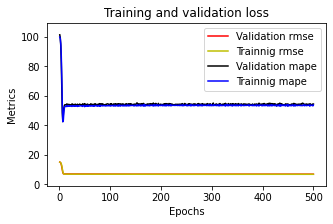

In [152]:
plotme(model1_1)

In [20]:
# inputs: distance
model1_3 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model1_3

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 569468.0000 - distance_layer_loss: 0.0622 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 28241.4941 - distance_layer_rmse: 0.2494 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0544 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 182.7051 - val_distance_layer_rmse: 0.2332 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0488 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 39927.0078 - distance_layer_rmse: 0.2210 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0465 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 175.5467 - val_distance_layer_rmse: 0.2156 - val_travelti

179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0189 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 27771.9980 - distance_layer_rmse: 0.1376 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0188 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 96.5926 - val_distance_layer_rmse: 0.1370 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0186 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 28583.6895 - distance_layer_rmse: 0.1362 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0183 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 103.2035 - val_distance_layer_rmse: 0.1354 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0157 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 26897.6680 - distance_layer_rmse: 0.1252 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0160 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 89.3797 - val_distance_layer_rmse: 0.1264 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0157 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 26091.0879 - distance_layer_rmse: 0.1252 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0158 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 85.8694 - val_distance_layer_rmse: 0.1255 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0137 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 25565.1133 - distance_layer_rmse: 0.1169 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0141 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 82.6508 - val_distance_layer_rmse: 0.1187 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.0135 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 28666.6875 - distance_layer_rmse: 0.1162 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0139 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 78.3019 - val_distance_layer_rmse: 0.1178 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0112 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 20519.5117 - distance_layer_rmse: 0.1057 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0112 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 66.9634 - val_distance_layer_rmse: 0.1057 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0110 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 22235.6465 - distance_layer_rmse: 0.1047 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0110 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 61.7200 - val_distance_layer_rmse: 0.1048 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0085 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 18095.3379 - distance_layer_rmse: 0.0921 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0086 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 53.5264 - val_distance_layer_rmse: 0.0927 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0084 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 19276.0391 - distance_layer_rmse: 0.0916 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0084 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 51.4967 - val_distance_layer_rmse: 0.0917 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.0077 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 15379.3301 - distance_layer_rmse: 0.0879 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 40.9968 - val_distance_layer_rmse: 0.0884 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0077 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 17021.7266 - distance_layer_rmse: 0.0875 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 44.3727 - val_distance_layer_rmse: 0.0886 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0076 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 10916.3350 - distance_layer_rmse: 0.0870 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 43.6958 - val_distance_layer_rmse: 0.0890 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6250 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 16850.5938 - distance_layer_rmse: 0.0867 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0080 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 48.0673 - val_distance_layer_rmse: 0.0892 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 12606.3330 - distance_layer_rmse: 0.0868 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.6432 - val_distance_layer_rmse: 0.0882 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 12067.9639 - distance_layer_rmse: 0.0865 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.6933 - val_distance_layer_rmse: 0.0886 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 9324.0400 - distance_layer_rmse: 0.0869 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 47.2864 - val_distance_layer_rmse: 0.0882 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 10124.0146 - distance_layer_rmse: 0.0867 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0082 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.3843 - val_distance_layer_rmse: 0.0906 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 10103.7705 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 43.5809 - val_distance_layer_rmse: 0.0876 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.1875 - distance_layer_mape: 10660.7832 - distance_layer_rmse: 0.0867 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9563 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 41.5111 - val_distance_layer_rmse: 0.0874 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 12351.3809 - distance_layer_rmse: 0.0866 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.7879 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 167/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 11526.2012 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 44.7979 - val_distance_layer_rmse: 0.0880 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 9429.4404 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.3290 - val_distance_layer_rmse: 0.0877 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 182/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.1875 - distance_layer_mape: 9760.0898 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9563 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0081 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 47.8303 - val_distance_layer_rmse: 0.0898 - val_traveltime_layer_mape:

179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 10695.1426 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.5660 - val_distance_layer_rmse: 0.0888 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 197/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 10778.4814 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 38.3895 - val_distance_layer_rmse: 0.0872 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 12964.7705 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 47.8499 - val_distance_layer_rmse: 0.0885 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 11598.4961 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 48.9917 - val_distance_layer_rmse: 0.0889 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 12121.5918 - distance_layer_rmse: 0.0865 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 41.7830 - val_distance_layer_rmse: 0.0882 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 9391.8359 - distance_layer_rmse: 0.0866 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 33.3719 - val_distance_layer_rmse: 0.0891 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.6250 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 9833.6250 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0081 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.0306 - val_distance_layer_rmse: 0.0898 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 242/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 11057.6074 - distance_layer_rmse: 0.0866 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 46.6893 - val_distance_layer_rmse: 0.0879 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 9963.8047 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.9975 - val_distance_layer_rmse: 0.0877 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 257/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 9932.0273 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 40.3266 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_mape:

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 12750.8701 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 33.3648 - val_distance_layer_rmse: 0.0882 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 9305.9209 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.8063 - val_distance_layer_rmse: 0.0881 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 11892.6475 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 45.7297 - val_distance_layer_rmse: 0.0888 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 10661.1543 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 36.7808 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 11186.5830 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.4822 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 10569.3672 - distance_layer_rmse: 0.0861 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 40.7661 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 11504.5879 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.9883 - val_distance_layer_rmse: 0.0874 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6250 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 11024.0410 - distance_layer_rmse: 0.0866 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 43.9411 - val_distance_layer_rmse: 0.0877 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 9038.1094 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 34.6639 - val_distance_layer_rmse: 0.0885 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 13643.3340 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.7649 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 10552.3291 - distance_layer_rmse: 0.0868 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.7501 - val_distance_layer_rmse: 0.0872 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 347/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 11286.4805 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 38.5349 - val_distance_layer_rmse: 0.0878 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 9996.6738 - distance_layer_rmse: 0.0861 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0079 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.4084 - val_distance_layer_rmse: 0.0887 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 362/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 9881.5137 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 40.1607 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_mape:

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 10673.7549 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.1326 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 9618.6426 - distance_layer_rmse: 0.0861 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 40.4174 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 9812.1709 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 35.9755 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 11393.6074 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 45.3349 - val_distance_layer_rmse: 0.0882 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 10713.8047 - distance_layer_rmse: 0.0865 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 36.9392 - val_distance_layer_rmse: 0.0878 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 10352.3613 - distance_layer_rmse: 0.0861 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.0678 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 9875.2988 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 43.0187 - val_distance_layer_rmse: 0.0876 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 8752.4463 - distance_layer_rmse: 0.0867 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.1046 - val_distance_layer_rmse: 0.0879 - val_traveltime_layer_mape:

179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 10971.5332 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 35.9957 - val_distance_layer_rmse: 0.0875 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 10246.7920 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 36.8335 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 10642.8955 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 36.1465 - val_distance_layer_rmse: 0.0873 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 10093.1709 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.9945 - val_distance_layer_rmse: 0.0878 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 10738.0049 - distance_layer_rmse: 0.0865 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 38.1670 - val_distance_layer_rmse: 0.0872 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 11275.1143 - distance_layer_rmse: 0.0863 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 39.1083 - val_distance_layer_rmse: 0.0878 - val_traveltime_layer_map

179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 10636.0293 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 37.6908 - val_distance_layer_rmse: 0.0884 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 8484.0557 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0078 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.4325 - val_distance_layer_rmse: 0.0882 - val_traveltime_layer_mape

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.0074 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 11394.1572 - distance_layer_rmse: 0.0862 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 42.2016 - val_distance_layer_rmse: 0.0879 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 10362.5059 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.0077 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 43.6652 - val_distance_layer_rmse: 0.0880 - val_traveltime_layer_map

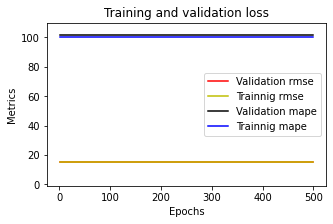

In [154]:
plotme(model1_3)
#val_loss2 = [x+1.8 for x in val_loss2]

In [21]:
# inputs: distance
model1_4 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model1_4

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 568631.0625 - distance_layer_loss: 0.4826 - traveltime_layer_loss: 812329.8750 - distance_layer_mape: 171341.1875 - distance_layer_rmse: 0.6947 - traveltime_layer_mape: 99.8792 - traveltime_layer_rmse: 901.2935 - val_loss: 576221.5625 - val_distance_layer_loss: 2.0570 - val_traveltime_layer_loss: 823173.0625 - val_distance_layer_mape: 1311.6721 - val_distance_layer_rmse: 1.4342 - val_traveltime_layer_mape: 99.6395 - val_traveltime_layer_rmse: 907.2889
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 562081.6875 - distance_layer_loss: 9.9068 - traveltime_layer_loss: 802969.7500 - distance_layer_mape: 606564.4375 - distance_layer_rmse: 3.1475 - traveltime_layer_mape: 98.9294 - traveltime_layer_rmse: 896.0858 - val_loss: 563342.6875 - val_distance_layer_loss: 25.3214 - val_traveltime_layer_loss: 804764.3125 - val_distance_layer_mape: 4285.1377 - val_distance_layer_rmse: 5.0320 - val_travel

179/179 [==============================] - 0s 1ms/step - loss: 120818.0469 - distance_layer_loss: 2700.2561 - traveltime_layer_loss: 171439.9844 - distance_layer_mape: 6066248.5000 - distance_layer_rmse: 51.9640 - traveltime_layer_mape: 53.0108 - traveltime_layer_rmse: 414.0531 - val_loss: 125347.0781 - val_distance_layer_loss: 2685.2073 - val_traveltime_layer_loss: 177916.4688 - val_distance_layer_mape: 42680.7539 - val_distance_layer_rmse: 51.8190 - val_traveltime_layer_mape: 52.2098 - val_traveltime_layer_rmse: 421.8015
Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 120769.7266 - distance_layer_loss: 2697.0305 - traveltime_layer_loss: 171372.3906 - distance_layer_mape: 6098639.0000 - distance_layer_rmse: 51.9329 - traveltime_layer_mape: 53.1357 - traveltime_layer_rmse: 413.9715 - val_loss: 125225.2109 - val_distance_layer_loss: 2682.2139 - val_traveltime_layer_loss: 177743.6562 - val_distance_layer_mape: 42660.1875 - val_distance_layer_rmse: 51.7901 - va

179/179 [==============================] - 0s 1ms/step - loss: 119736.0703 - distance_layer_loss: 2554.3904 - traveltime_layer_loss: 169956.8438 - distance_layer_mape: 6255156.5000 - distance_layer_rmse: 50.5410 - traveltime_layer_mape: 53.0016 - traveltime_layer_rmse: 412.2582 - val_loss: 123843.1094 - val_distance_layer_loss: 2560.4448 - val_traveltime_layer_loss: 175821.3750 - val_distance_layer_mape: 41733.7852 - val_distance_layer_rmse: 50.6008 - val_traveltime_layer_mape: 52.6420 - val_traveltime_layer_rmse: 419.3106
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 119727.0625 - distance_layer_loss: 2557.8469 - traveltime_layer_loss: 169942.3594 - distance_layer_mape: 6267276.0000 - distance_layer_rmse: 50.5752 - traveltime_layer_mape: 53.3548 - traveltime_layer_rmse: 412.2407 - val_loss: 123793.2812 - val_distance_layer_loss: 2530.9265 - val_traveltime_layer_loss: 175762.8906 - val_distance_layer_mape: 41497.1484 - val_distance_layer_rmse: 50.3083 - va

179/179 [==============================] - 0s 1ms/step - loss: 118973.1484 - distance_layer_loss: 2409.7510 - traveltime_layer_loss: 168928.7812 - distance_layer_mape: 6360673.5000 - distance_layer_rmse: 49.0892 - traveltime_layer_mape: 53.4221 - traveltime_layer_rmse: 411.0095 - val_loss: 122808.3281 - val_distance_layer_loss: 2378.5503 - val_traveltime_layer_loss: 174421.0312 - val_distance_layer_mape: 40277.6562 - val_distance_layer_rmse: 48.7704 - val_traveltime_layer_mape: 52.0666 - val_traveltime_layer_rmse: 417.6375
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 118925.3359 - distance_layer_loss: 2392.0515 - traveltime_layer_loss: 168868.1562 - distance_layer_mape: 6387228.0000 - distance_layer_rmse: 48.9086 - traveltime_layer_mape: 53.2453 - traveltime_layer_rmse: 410.9357 - val_loss: 122825.2109 - val_distance_layer_loss: 2351.3564 - val_traveltime_layer_loss: 174456.8125 - val_distance_layer_mape: 40050.6836 - val_distance_layer_rmse: 48.4908 - va

179/179 [==============================] - 0s 1ms/step - loss: 118447.9922 - distance_layer_loss: 2247.1223 - traveltime_layer_loss: 168248.3125 - distance_layer_mape: 6365922.5000 - distance_layer_rmse: 47.4038 - traveltime_layer_mape: 53.1689 - traveltime_layer_rmse: 410.1808 - val_loss: 122048.3672 - val_distance_layer_loss: 2228.7661 - val_traveltime_layer_loss: 173399.6094 - val_distance_layer_mape: 39032.7930 - val_distance_layer_rmse: 47.2098 - val_traveltime_layer_mape: 52.0602 - val_traveltime_layer_rmse: 416.4128
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 118395.8125 - distance_layer_loss: 2235.6082 - traveltime_layer_loss: 168178.6562 - distance_layer_mape: 6361568.5000 - distance_layer_rmse: 47.2822 - traveltime_layer_mape: 53.1133 - traveltime_layer_rmse: 410.0959 - val_loss: 121949.9141 - val_distance_layer_loss: 2245.0503 - val_traveltime_layer_loss: 173252.0000 - val_distance_layer_mape: 39176.5742 - val_distance_layer_rmse: 47.3820 - va

179/179 [==============================] - 0s 1ms/step - loss: 118016.8516 - distance_layer_loss: 2104.0286 - traveltime_layer_loss: 167693.7656 - distance_layer_mape: 6361449.5000 - distance_layer_rmse: 45.8697 - traveltime_layer_mape: 53.1260 - traveltime_layer_rmse: 409.5043 - val_loss: 121425.7500 - val_distance_layer_loss: 2116.9246 - val_traveltime_layer_loss: 172558.2031 - val_distance_layer_mape: 38076.8125 - val_distance_layer_rmse: 46.0100 - val_traveltime_layer_mape: 52.8749 - val_traveltime_layer_rmse: 415.4012
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 118022.3438 - distance_layer_loss: 2107.1694 - traveltime_layer_loss: 167700.2188 - distance_layer_mape: 6356873.0000 - distance_layer_rmse: 45.9039 - traveltime_layer_mape: 53.4800 - traveltime_layer_rmse: 409.5122 - val_loss: 121397.5703 - val_distance_layer_loss: 2100.4089 - val_traveltime_layer_loss: 172524.9688 - val_distance_layer_mape: 37930.8008 - val_distance_layer_rmse: 45.8302 - va

179/179 [==============================] - 0s 1ms/step - loss: 117735.7422 - distance_layer_loss: 1984.5287 - traveltime_layer_loss: 167343.3281 - distance_layer_mape: 6301230.5000 - distance_layer_rmse: 44.5480 - traveltime_layer_mape: 53.3491 - traveltime_layer_rmse: 409.0762 - val_loss: 121022.7734 - val_distance_layer_loss: 1981.8212 - val_traveltime_layer_loss: 172040.2969 - val_distance_layer_mape: 36871.3555 - val_distance_layer_rmse: 44.5177 - val_traveltime_layer_mape: 52.5862 - val_traveltime_layer_rmse: 414.7774
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 117701.4844 - distance_layer_loss: 1969.8750 - traveltime_layer_loss: 167300.6719 - distance_layer_mape: 6288311.0000 - distance_layer_rmse: 44.3833 - traveltime_layer_mape: 53.1233 - traveltime_layer_rmse: 409.0240 - val_loss: 120993.1641 - val_distance_layer_loss: 1985.5389 - val_traveltime_layer_loss: 171996.4531 - val_distance_layer_mape: 36907.1445 - val_distance_layer_rmse: 44.5594 - va

179/179 [==============================] - 0s 1ms/step - loss: 117525.9609 - distance_layer_loss: 1880.6516 - traveltime_layer_loss: 167088.1719 - distance_layer_mape: 6241355.0000 - distance_layer_rmse: 43.3665 - traveltime_layer_mape: 53.4771 - traveltime_layer_rmse: 408.7642 - val_loss: 120734.3594 - val_distance_layer_loss: 1876.2096 - val_traveltime_layer_loss: 171673.5938 - val_distance_layer_mape: 35897.7031 - val_distance_layer_rmse: 43.3152 - val_traveltime_layer_mape: 52.6283 - val_traveltime_layer_rmse: 414.3351
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 117479.4766 - distance_layer_loss: 1876.7043 - traveltime_layer_loss: 167023.5469 - distance_layer_mape: 6274288.5000 - distance_layer_rmse: 43.3209 - traveltime_layer_mape: 53.5412 - traveltime_layer_rmse: 408.6852 - val_loss: 120850.2734 - val_distance_layer_loss: 1840.3665 - val_traveltime_layer_loss: 171854.4688 - val_distance_layer_mape: 35556.2500 - val_distance_layer_rmse: 42.8995 - v

179/179 [==============================] - 0s 1ms/step - loss: 117387.6250 - distance_layer_loss: 1772.8521 - traveltime_layer_loss: 166936.7656 - distance_layer_mape: 6131804.5000 - distance_layer_rmse: 42.1053 - traveltime_layer_mape: 52.9853 - traveltime_layer_rmse: 408.5789 - val_loss: 120518.6797 - val_distance_layer_loss: 1786.2953 - val_traveltime_layer_loss: 171404.0625 - val_distance_layer_mape: 35042.4062 - val_distance_layer_rmse: 42.2646 - val_traveltime_layer_mape: 52.7281 - val_traveltime_layer_rmse: 414.0097
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 117371.2891 - distance_layer_loss: 1788.0460 - traveltime_layer_loss: 166907.0469 - distance_layer_mape: 6177451.0000 - distance_layer_rmse: 42.2853 - traveltime_layer_mape: 53.6923 - traveltime_layer_rmse: 408.5426 - val_loss: 120563.4609 - val_distance_layer_loss: 1763.8485 - val_traveltime_layer_loss: 171477.5312 - val_distance_layer_mape: 34823.6367 - val_distance_layer_rmse: 41.9982 - v

179/179 [==============================] - 0s 1ms/step - loss: 117258.2734 - distance_layer_loss: 1712.7499 - traveltime_layer_loss: 166777.7656 - distance_layer_mape: 6104028.0000 - distance_layer_rmse: 41.3854 - traveltime_layer_mape: 53.6771 - traveltime_layer_rmse: 408.3843 - val_loss: 120431.2031 - val_distance_layer_loss: 1690.4902 - val_traveltime_layer_loss: 171320.0938 - val_distance_layer_mape: 34102.2969 - val_distance_layer_rmse: 41.1156 - val_traveltime_layer_mape: 52.1664 - val_traveltime_layer_rmse: 413.9083
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 117278.1641 - distance_layer_loss: 1696.9203 - traveltime_layer_loss: 166813.0781 - distance_layer_mape: 6083786.0000 - distance_layer_rmse: 41.1937 - traveltime_layer_mape: 53.2856 - traveltime_layer_rmse: 408.4276 - val_loss: 120397.0234 - val_distance_layer_loss: 1691.5067 - val_traveltime_layer_loss: 171270.7812 - val_distance_layer_mape: 34112.3984 - val_distance_layer_rmse: 41.1279 - v

179/179 [==============================] - 0s 1ms/step - loss: 117228.6797 - distance_layer_loss: 1647.1133 - traveltime_layer_loss: 166763.5469 - distance_layer_mape: 6028131.0000 - distance_layer_rmse: 40.5846 - traveltime_layer_mape: 53.7863 - traveltime_layer_rmse: 408.3669 - val_loss: 120329.8828 - val_distance_layer_loss: 1623.8716 - val_traveltime_layer_loss: 171203.9375 - val_distance_layer_mape: 33430.5664 - val_distance_layer_rmse: 40.2973 - val_traveltime_layer_mape: 52.1762 - val_traveltime_layer_rmse: 413.7680
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 117171.9375 - distance_layer_loss: 1632.1479 - traveltime_layer_loss: 166689.0625 - distance_layer_mape: 6011107.5000 - distance_layer_rmse: 40.3999 - traveltime_layer_mape: 53.3803 - traveltime_layer_rmse: 408.2757 - val_loss: 120267.3281 - val_distance_layer_loss: 1635.4880 - val_traveltime_layer_loss: 171109.5156 - val_distance_layer_mape: 33549.3750 - val_distance_layer_rmse: 40.4412 - v

179/179 [==============================] - 0s 1ms/step - loss: 117140.2266 - distance_layer_loss: 1576.8077 - traveltime_layer_loss: 166667.4219 - distance_layer_mape: 5915363.5000 - distance_layer_rmse: 39.7090 - traveltime_layer_mape: 53.3815 - traveltime_layer_rmse: 408.2492 - val_loss: 120234.1172 - val_distance_layer_loss: 1570.3176 - val_traveltime_layer_loss: 171090.0000 - val_distance_layer_mape: 32878.7422 - val_distance_layer_rmse: 39.6272 - val_traveltime_layer_mape: 52.3608 - val_traveltime_layer_rmse: 413.6303
Epoch 167/500
179/179 [==============================] - 0s 1ms/step - loss: 117154.3828 - distance_layer_loss: 1580.7965 - traveltime_layer_loss: 166685.9844 - distance_layer_mape: 5971287.5000 - distance_layer_rmse: 39.7592 - traveltime_layer_mape: 53.6809 - traveltime_layer_rmse: 408.2719 - val_loss: 120276.1016 - val_distance_layer_loss: 1558.6377 - val_traveltime_layer_loss: 171154.9531 - val_distance_layer_mape: 32757.3613 - val_distance_layer_rmse: 39.4796 - v

179/179 [==============================] - 0s 1ms/step - loss: 117081.7109 - distance_layer_loss: 1527.7206 - traveltime_layer_loss: 166604.8281 - distance_layer_mape: 5907089.5000 - distance_layer_rmse: 39.0861 - traveltime_layer_mape: 53.5280 - traveltime_layer_rmse: 408.1725 - val_loss: 120173.5469 - val_distance_layer_loss: 1522.0922 - val_traveltime_layer_loss: 171024.1250 - val_distance_layer_mape: 32372.6973 - val_distance_layer_rmse: 39.0140 - val_traveltime_layer_mape: 52.4964 - val_traveltime_layer_rmse: 413.5506
Epoch 182/500
179/179 [==============================] - 0s 1ms/step - loss: 117097.5078 - distance_layer_loss: 1529.0112 - traveltime_layer_loss: 166626.9062 - distance_layer_mape: 5882415.5000 - distance_layer_rmse: 39.1026 - traveltime_layer_mape: 53.7081 - traveltime_layer_rmse: 408.1996 - val_loss: 120231.3984 - val_distance_layer_loss: 1506.2494 - val_traveltime_layer_loss: 171113.5781 - val_distance_layer_mape: 32204.5742 - val_distance_layer_rmse: 38.8104 - v

179/179 [==============================] - 0s 1ms/step - loss: 117041.9375 - distance_layer_loss: 1478.5054 - traveltime_layer_loss: 166569.1094 - distance_layer_mape: 5834073.0000 - distance_layer_rmse: 38.4513 - traveltime_layer_mape: 53.4443 - traveltime_layer_rmse: 408.1288 - val_loss: 120107.9688 - val_distance_layer_loss: 1488.8774 - val_traveltime_layer_loss: 170944.7500 - val_distance_layer_mape: 32017.0449 - val_distance_layer_rmse: 38.5860 - val_traveltime_layer_mape: 53.0339 - val_traveltime_layer_rmse: 413.4547
Epoch 197/500
179/179 [==============================] - 0s 1ms/step - loss: 117032.5625 - distance_layer_loss: 1480.6824 - traveltime_layer_loss: 166554.8281 - distance_layer_mape: 5820801.0000 - distance_layer_rmse: 38.4796 - traveltime_layer_mape: 53.6014 - traveltime_layer_rmse: 408.1113 - val_loss: 120138.4766 - val_distance_layer_loss: 1471.1786 - val_traveltime_layer_loss: 170995.8125 - val_distance_layer_mape: 31827.5078 - val_distance_layer_rmse: 38.3559 - v

179/179 [==============================] - 0s 1ms/step - loss: 116976.4062 - distance_layer_loss: 1441.2036 - traveltime_layer_loss: 166491.5781 - distance_layer_mape: 5711490.0000 - distance_layer_rmse: 37.9632 - traveltime_layer_mape: 53.6187 - traveltime_layer_rmse: 408.0338 - val_loss: 120157.4844 - val_distance_layer_loss: 1423.3367 - val_traveltime_layer_loss: 171043.5156 - val_distance_layer_mape: 31306.4473 - val_distance_layer_rmse: 37.7271 - val_traveltime_layer_mape: 52.1298 - val_traveltime_layer_rmse: 413.5741
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 116983.7969 - distance_layer_loss: 1437.8882 - traveltime_layer_loss: 166503.5156 - distance_layer_mape: 5727260.0000 - distance_layer_rmse: 37.9195 - traveltime_layer_mape: 53.6112 - traveltime_layer_rmse: 408.0484 - val_loss: 120133.2500 - val_distance_layer_loss: 1424.7010 - val_traveltime_layer_loss: 171008.3125 - val_distance_layer_mape: 31320.9883 - val_distance_layer_rmse: 37.7452 - v

179/179 [==============================] - 0s 1ms/step - loss: 116971.3203 - distance_layer_loss: 1402.3660 - traveltime_layer_loss: 166500.9062 - distance_layer_mape: 5673435.5000 - distance_layer_rmse: 37.4482 - traveltime_layer_mape: 53.6420 - traveltime_layer_rmse: 408.0452 - val_loss: 120094.0312 - val_distance_layer_loss: 1394.3475 - val_traveltime_layer_loss: 170965.3594 - val_distance_layer_mape: 30984.6289 - val_distance_layer_rmse: 37.3410 - val_traveltime_layer_mape: 52.5002 - val_traveltime_layer_rmse: 413.4796
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 116978.4531 - distance_layer_loss: 1400.0463 - traveltime_layer_loss: 166512.0312 - distance_layer_mape: 5666297.5000 - distance_layer_rmse: 37.4172 - traveltime_layer_mape: 53.6290 - traveltime_layer_rmse: 408.0589 - val_loss: 120139.8906 - val_distance_layer_loss: 1382.6069 - val_traveltime_layer_loss: 171035.8906 - val_distance_layer_mape: 30854.5938 - val_distance_layer_rmse: 37.1834 - v

179/179 [==============================] - 0s 1ms/step - loss: 116908.4453 - distance_layer_loss: 1369.5336 - traveltime_layer_loss: 166425.0938 - distance_layer_mape: 5601911.5000 - distance_layer_rmse: 37.0072 - traveltime_layer_mape: 53.7316 - traveltime_layer_rmse: 407.9523 - val_loss: 120166.1094 - val_distance_layer_loss: 1345.6820 - val_traveltime_layer_loss: 171089.1250 - val_distance_layer_mape: 30439.3125 - val_distance_layer_rmse: 36.6835 - val_traveltime_layer_mape: 51.9451 - val_traveltime_layer_rmse: 413.6292
Epoch 242/500
179/179 [==============================] - 0s 1ms/step - loss: 116925.2031 - distance_layer_loss: 1356.3138 - traveltime_layer_loss: 166454.7656 - distance_layer_mape: 5567760.0000 - distance_layer_rmse: 36.8282 - traveltime_layer_mape: 53.2881 - traveltime_layer_rmse: 407.9887 - val_loss: 120076.6484 - val_distance_layer_loss: 1358.9023 - val_traveltime_layer_loss: 170955.7344 - val_distance_layer_mape: 30586.9355 - val_distance_layer_rmse: 36.8633 - v

179/179 [==============================] - 0s 1ms/step - loss: 116921.9609 - distance_layer_loss: 1334.7200 - traveltime_layer_loss: 166459.3906 - distance_layer_mape: 5559229.0000 - distance_layer_rmse: 36.5338 - traveltime_layer_mape: 53.6337 - traveltime_layer_rmse: 407.9944 - val_loss: 120066.9531 - val_distance_layer_loss: 1329.4974 - val_traveltime_layer_loss: 170954.4844 - val_distance_layer_mape: 30252.9727 - val_distance_layer_rmse: 36.4623 - val_traveltime_layer_mape: 52.6264 - val_traveltime_layer_rmse: 413.4664
Epoch 257/500
179/179 [==============================] - 0s 1ms/step - loss: 116917.8516 - distance_layer_loss: 1326.3269 - traveltime_layer_loss: 166457.1250 - distance_layer_mape: 5524064.5000 - distance_layer_rmse: 36.4188 - traveltime_layer_mape: 53.3908 - traveltime_layer_rmse: 407.9916 - val_loss: 120059.8906 - val_distance_layer_loss: 1329.4220 - val_traveltime_layer_loss: 170944.3906 - val_distance_layer_mape: 30251.8555 - val_distance_layer_rmse: 36.4612 - v

179/179 [==============================] - 0s 1ms/step - loss: 116868.5625 - distance_layer_loss: 1296.9659 - traveltime_layer_loss: 166399.2344 - distance_layer_mape: 5474109.0000 - distance_layer_rmse: 36.0134 - traveltime_layer_mape: 53.3499 - traveltime_layer_rmse: 407.9206 - val_loss: 120057.1875 - val_distance_layer_loss: 1312.8589 - val_traveltime_layer_loss: 170947.6094 - val_distance_layer_mape: 30060.5742 - val_distance_layer_rmse: 36.2334 - val_traveltime_layer_mape: 53.2378 - val_traveltime_layer_rmse: 413.4581
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 116891.7578 - distance_layer_loss: 1299.5741 - traveltime_layer_loss: 166431.2656 - distance_layer_mape: 5484894.0000 - distance_layer_rmse: 36.0496 - traveltime_layer_mape: 53.5654 - traveltime_layer_rmse: 407.9599 - val_loss: 120056.1328 - val_distance_layer_loss: 1299.9755 - val_traveltime_layer_loss: 170951.6562 - val_distance_layer_mape: 29913.2949 - val_distance_layer_rmse: 36.0552 - v

179/179 [==============================] - 0s 1ms/step - loss: 116864.5938 - distance_layer_loss: 1273.6067 - traveltime_layer_loss: 166403.6719 - distance_layer_mape: 5437766.0000 - distance_layer_rmse: 35.6876 - traveltime_layer_mape: 53.6331 - traveltime_layer_rmse: 407.9261 - val_loss: 120111.5703 - val_distance_layer_loss: 1260.0277 - val_traveltime_layer_loss: 171047.9375 - val_distance_layer_mape: 29450.2539 - val_distance_layer_rmse: 35.4969 - val_traveltime_layer_mape: 52.2192 - val_traveltime_layer_rmse: 413.5794
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 116852.5078 - distance_layer_loss: 1270.5360 - traveltime_layer_loss: 166387.6719 - distance_layer_mape: 5408927.0000 - distance_layer_rmse: 35.6446 - traveltime_layer_mape: 53.5719 - traveltime_layer_rmse: 407.9065 - val_loss: 120098.9531 - val_distance_layer_loss: 1260.2992 - val_traveltime_layer_loss: 171029.8281 - val_distance_layer_mape: 29452.9160 - val_distance_layer_rmse: 35.5007 - v

179/179 [==============================] - 0s 1ms/step - loss: 116865.6094 - distance_layer_loss: 1239.0387 - traveltime_layer_loss: 166419.8125 - distance_layer_mape: 5327662.0000 - distance_layer_rmse: 35.2000 - traveltime_layer_mape: 53.2807 - traveltime_layer_rmse: 407.9458 - val_loss: 120078.3594 - val_distance_layer_loss: 1239.2935 - val_traveltime_layer_loss: 171009.3281 - val_distance_layer_mape: 29204.6133 - val_distance_layer_rmse: 35.2036 - val_traveltime_layer_mape: 52.4859 - val_traveltime_layer_rmse: 413.5327
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 116841.5078 - distance_layer_loss: 1243.3499 - traveltime_layer_loss: 166383.5469 - distance_layer_mape: 5359594.0000 - distance_layer_rmse: 35.2612 - traveltime_layer_mape: 53.5355 - traveltime_layer_rmse: 407.9014 - val_loss: 120101.9141 - val_distance_layer_loss: 1233.4141 - val_traveltime_layer_loss: 171045.5312 - val_distance_layer_mape: 29135.6094 - val_distance_layer_rmse: 35.1200 - v

179/179 [==============================] - 0s 1ms/step - loss: 116847.0703 - distance_layer_loss: 1220.6935 - traveltime_layer_loss: 166401.2500 - distance_layer_mape: 5302001.5000 - distance_layer_rmse: 34.9384 - traveltime_layer_mape: 53.6049 - traveltime_layer_rmse: 407.9231 - val_loss: 120097.7344 - val_distance_layer_loss: 1211.0964 - val_traveltime_layer_loss: 171049.1562 - val_distance_layer_mape: 28869.1348 - val_distance_layer_rmse: 34.8008 - val_traveltime_layer_mape: 52.3450 - val_traveltime_layer_rmse: 413.5809
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 116865.2969 - distance_layer_loss: 1219.1799 - traveltime_layer_loss: 166427.8438 - distance_layer_mape: 5302925.5000 - distance_layer_rmse: 34.9168 - traveltime_layer_mape: 53.6317 - traveltime_layer_rmse: 407.9557 - val_loss: 120115.0000 - val_distance_layer_loss: 1206.5411 - val_traveltime_layer_loss: 171075.7344 - val_distance_layer_mape: 28815.0664 - val_distance_layer_rmse: 34.7353 - v

179/179 [==============================] - 0s 1ms/step - loss: 116808.4062 - distance_layer_loss: 1191.1033 - traveltime_layer_loss: 166358.7188 - distance_layer_mape: 5236380.0000 - distance_layer_rmse: 34.5124 - traveltime_layer_mape: 53.3253 - traveltime_layer_rmse: 407.8710 - val_loss: 120062.4766 - val_distance_layer_loss: 1201.6432 - val_traveltime_layer_loss: 171002.8125 - val_distance_layer_mape: 28753.7520 - val_distance_layer_rmse: 34.6647 - val_traveltime_layer_mape: 53.0030 - val_traveltime_layer_rmse: 413.5249
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 116827.7266 - distance_layer_loss: 1192.4669 - traveltime_layer_loss: 166385.7188 - distance_layer_mape: 5212474.5000 - distance_layer_rmse: 34.5321 - traveltime_layer_mape: 53.4497 - traveltime_layer_rmse: 407.9041 - val_loss: 120065.4453 - val_distance_layer_loss: 1196.2386 - val_traveltime_layer_loss: 171009.4219 - val_distance_layer_mape: 28689.1582 - val_distance_layer_rmse: 34.5867 - v

179/179 [==============================] - 0s 1ms/step - loss: 116831.6328 - distance_layer_loss: 1170.0638 - traveltime_layer_loss: 166400.9219 - distance_layer_mape: 5193752.5000 - distance_layer_rmse: 34.2062 - traveltime_layer_mape: 53.3858 - traveltime_layer_rmse: 407.9227 - val_loss: 120106.0625 - val_distance_layer_loss: 1165.1934 - val_traveltime_layer_loss: 171080.7812 - val_distance_layer_mape: 28314.0586 - val_distance_layer_rmse: 34.1349 - val_traveltime_layer_mape: 52.3516 - val_traveltime_layer_rmse: 413.6191
Epoch 347/500
179/179 [==============================] - 0s 1ms/step - loss: 116807.9922 - distance_layer_loss: 1174.8248 - traveltime_layer_loss: 166365.0312 - distance_layer_mape: 5218869.5000 - distance_layer_rmse: 34.2757 - traveltime_layer_mape: 53.6820 - traveltime_layer_rmse: 407.8787 - val_loss: 120202.0469 - val_distance_layer_loss: 1151.0461 - val_traveltime_layer_loss: 171223.9375 - val_distance_layer_mape: 28142.4473 - val_distance_layer_rmse: 33.9271 - v

179/179 [==============================] - 0s 1ms/step - loss: 116771.7734 - distance_layer_loss: 1157.8877 - traveltime_layer_loss: 166320.6875 - distance_layer_mape: 5146232.5000 - distance_layer_rmse: 34.0277 - traveltime_layer_mape: 53.8524 - traveltime_layer_rmse: 407.8243 - val_loss: 120207.6328 - val_distance_layer_loss: 1131.3065 - val_traveltime_layer_loss: 171240.3906 - val_distance_layer_mape: 27899.1523 - val_distance_layer_rmse: 33.6349 - val_traveltime_layer_mape: 51.7923 - val_traveltime_layer_rmse: 413.8120
Epoch 362/500
179/179 [==============================] - 0s 1ms/step - loss: 116798.7500 - distance_layer_loss: 1142.3179 - traveltime_layer_loss: 166365.8594 - distance_layer_mape: 5136414.5000 - distance_layer_rmse: 33.7982 - traveltime_layer_mape: 53.1982 - traveltime_layer_rmse: 407.8797 - val_loss: 120073.7500 - val_distance_layer_loss: 1154.0477 - val_traveltime_layer_loss: 171039.3438 - val_distance_layer_mape: 28175.8242 - val_distance_layer_rmse: 33.9713 - v

179/179 [==============================] - 0s 1ms/step - loss: 116769.6094 - distance_layer_loss: 1132.4539 - traveltime_layer_loss: 166328.3438 - distance_layer_mape: 5109112.5000 - distance_layer_rmse: 33.6520 - traveltime_layer_mape: 53.6344 - traveltime_layer_rmse: 407.8337 - val_loss: 120130.4141 - val_distance_layer_loss: 1120.2036 - val_traveltime_layer_loss: 171134.8125 - val_distance_layer_mape: 27759.7852 - val_distance_layer_rmse: 33.4694 - val_traveltime_layer_mape: 52.2482 - val_traveltime_layer_rmse: 413.6844
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 116807.9453 - distance_layer_loss: 1123.8453 - traveltime_layer_loss: 166386.8594 - distance_layer_mape: 5082569.5000 - distance_layer_rmse: 33.5238 - traveltime_layer_mape: 53.3055 - traveltime_layer_rmse: 407.9055 - val_loss: 120130.8281 - val_distance_layer_loss: 1118.6195 - val_traveltime_layer_loss: 171136.0625 - val_distance_layer_mape: 27740.0547 - val_distance_layer_rmse: 33.4458 - v

179/179 [==============================] - 0s 1ms/step - loss: 116784.8203 - distance_layer_loss: 1110.3828 - traveltime_layer_loss: 166359.5781 - distance_layer_mape: 5056553.0000 - distance_layer_rmse: 33.3224 - traveltime_layer_mape: 53.5567 - traveltime_layer_rmse: 407.8720 - val_loss: 120125.6094 - val_distance_layer_loss: 1101.5852 - val_traveltime_layer_loss: 171135.8750 - val_distance_layer_mape: 27527.0059 - val_distance_layer_rmse: 33.1901 - val_traveltime_layer_mape: 52.3157 - val_traveltime_layer_rmse: 413.6857
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 116745.0078 - distance_layer_loss: 1116.0732 - traveltime_layer_loss: 166300.2812 - distance_layer_mape: 5078179.5000 - distance_layer_rmse: 33.4077 - traveltime_layer_mape: 53.8665 - traveltime_layer_rmse: 407.7993 - val_loss: 120233.7266 - val_distance_layer_loss: 1088.4371 - val_traveltime_layer_loss: 171296.0312 - val_distance_layer_mape: 27363.2324 - val_distance_layer_rmse: 32.9915 - v

179/179 [==============================] - 0s 1ms/step - loss: 116786.1562 - distance_layer_loss: 1087.5027 - traveltime_layer_loss: 166371.2500 - distance_layer_mape: 5010729.0000 - distance_layer_rmse: 32.9773 - traveltime_layer_mape: 53.3405 - traveltime_layer_rmse: 407.8863 - val_loss: 120127.0312 - val_distance_layer_loss: 1084.2107 - val_traveltime_layer_loss: 171145.3906 - val_distance_layer_mape: 27308.2129 - val_distance_layer_rmse: 32.9274 - val_traveltime_layer_mape: 52.3675 - val_traveltime_layer_rmse: 413.6972
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 116754.9688 - distance_layer_loss: 1089.5741 - traveltime_layer_loss: 166325.8125 - distance_layer_mape: 5013478.0000 - distance_layer_rmse: 33.0087 - traveltime_layer_mape: 53.5004 - traveltime_layer_rmse: 407.8306 - val_loss: 120099.7812 - val_distance_layer_loss: 1089.8772 - val_traveltime_layer_loss: 171104.0781 - val_distance_layer_mape: 27378.6660 - val_distance_layer_rmse: 33.0133 - v

179/179 [==============================] - 0s 1ms/step - loss: 116746.0000 - distance_layer_loss: 1068.6597 - traveltime_layer_loss: 166322.0625 - distance_layer_mape: 4943646.5000 - distance_layer_rmse: 32.6904 - traveltime_layer_mape: 53.2987 - traveltime_layer_rmse: 407.8260 - val_loss: 120104.4922 - val_distance_layer_loss: 1074.2008 - val_traveltime_layer_loss: 171117.4219 - val_distance_layer_mape: 27180.3926 - val_distance_layer_rmse: 32.7750 - val_traveltime_layer_mape: 52.7665 - val_traveltime_layer_rmse: 413.6634
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 116773.9219 - distance_layer_loss: 1074.9454 - traveltime_layer_loss: 166359.2969 - distance_layer_mape: 4973407.0000 - distance_layer_rmse: 32.7864 - traveltime_layer_mape: 53.6603 - traveltime_layer_rmse: 407.8717 - val_loss: 120145.0859 - val_distance_layer_loss: 1063.0684 - val_traveltime_layer_loss: 171180.2344 - val_distance_layer_mape: 27039.9277 - val_distance_layer_rmse: 32.6047 - v

179/179 [==============================] - 0s 1ms/step - loss: 116766.0234 - distance_layer_loss: 1057.9900 - traveltime_layer_loss: 166355.1094 - distance_layer_mape: 4938997.0000 - distance_layer_rmse: 32.5268 - traveltime_layer_mape: 53.6085 - traveltime_layer_rmse: 407.8665 - val_loss: 120112.2969 - val_distance_layer_loss: 1055.9763 - val_traveltime_layer_loss: 171136.3906 - val_distance_layer_mape: 26948.2324 - val_distance_layer_rmse: 32.4958 - val_traveltime_layer_mape: 52.7046 - val_traveltime_layer_rmse: 413.6863
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 116738.8828 - distance_layer_loss: 1052.0284 - traveltime_layer_loss: 166318.9844 - distance_layer_mape: 4930115.0000 - distance_layer_rmse: 32.4350 - traveltime_layer_mape: 53.3759 - traveltime_layer_rmse: 407.8222 - val_loss: 120106.4922 - val_distance_layer_loss: 1057.7330 - val_traveltime_layer_loss: 171127.4219 - val_distance_layer_mape: 26970.2773 - val_distance_layer_rmse: 32.5228 - v

179/179 [==============================] - 0s 1ms/step - loss: 116755.0469 - distance_layer_loss: 1044.5425 - traveltime_layer_loss: 166345.3594 - distance_layer_mape: 4904634.5000 - distance_layer_rmse: 32.3194 - traveltime_layer_mape: 53.7729 - traveltime_layer_rmse: 407.8546 - val_loss: 120236.5781 - val_distance_layer_loss: 1021.8619 - val_traveltime_layer_loss: 171328.5938 - val_distance_layer_mape: 26510.2676 - val_distance_layer_rmse: 31.9666 - val_traveltime_layer_mape: 51.8067 - val_traveltime_layer_rmse: 413.9186
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 116716.7422 - distance_layer_loss: 1023.7484 - traveltime_layer_loss: 166299.5156 - distance_layer_mape: 4865601.0000 - distance_layer_rmse: 31.9961 - traveltime_layer_mape: 52.7509 - traveltime_layer_rmse: 407.7984 - val_loss: 120129.2109 - val_distance_layer_loss: 1052.8425 - val_traveltime_layer_loss: 171161.9219 - val_distance_layer_mape: 26906.2227 - val_distance_layer_rmse: 32.4475 - v

179/179 [==============================] - 0s 1ms/step - loss: 116747.3984 - distance_layer_loss: 1021.5000 - traveltime_layer_loss: 166344.2500 - distance_layer_mape: 4831448.5000 - distance_layer_rmse: 31.9609 - traveltime_layer_mape: 53.4323 - traveltime_layer_rmse: 407.8532 - val_loss: 120155.3828 - val_distance_layer_loss: 1016.0543 - val_traveltime_layer_loss: 171215.1250 - val_distance_layer_mape: 26433.6191 - val_distance_layer_rmse: 31.8756 - val_traveltime_layer_mape: 52.3164 - val_traveltime_layer_rmse: 413.7815
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 116733.1719 - distance_layer_loss: 1027.1980 - traveltime_layer_loss: 166321.4531 - distance_layer_mape: 4879095.5000 - distance_layer_rmse: 32.0499 - traveltime_layer_mape: 53.7483 - traveltime_layer_rmse: 407.8253 - val_loss: 120202.9531 - val_distance_layer_loss: 1008.5983 - val_traveltime_layer_loss: 171286.2812 - val_distance_layer_mape: 26336.8574 - val_distance_layer_rmse: 31.7584 - v

179/179 [==============================] - 0s 1ms/step - loss: 116715.9609 - distance_layer_loss: 1009.6055 - traveltime_layer_loss: 166304.4062 - distance_layer_mape: 4812193.0000 - distance_layer_rmse: 31.7743 - traveltime_layer_mape: 53.5476 - traveltime_layer_rmse: 407.8044 - val_loss: 120189.3516 - val_distance_layer_loss: 997.2115 - val_traveltime_layer_loss: 171271.6719 - val_distance_layer_mape: 26186.9395 - val_distance_layer_rmse: 31.5787 - val_traveltime_layer_mape: 52.0957 - val_traveltime_layer_rmse: 413.8498
Epoch 482/500
179/179 [==============================] - 0s 996us/step - loss: 116754.2578 - distance_layer_loss: 1010.4731 - traveltime_layer_loss: 166358.6406 - distance_layer_mape: 4815709.5000 - distance_layer_rmse: 31.7879 - traveltime_layer_mape: 53.6413 - traveltime_layer_rmse: 407.8708 - val_loss: 120197.3750 - val_distance_layer_loss: 995.1407 - val_traveltime_layer_loss: 171284.0156 - val_distance_layer_mape: 26159.9746 - val_distance_layer_rmse: 31.5459 - v

179/179 [==============================] - 0s 1ms/step - loss: 116735.5625 - distance_layer_loss: 997.6179 - traveltime_layer_loss: 166337.5156 - distance_layer_mape: 4768575.5000 - distance_layer_rmse: 31.5851 - traveltime_layer_mape: 53.6706 - traveltime_layer_rmse: 407.8450 - val_loss: 120230.7969 - val_distance_layer_loss: 979.3885 - val_traveltime_layer_loss: 171338.5781 - val_distance_layer_mape: 25952.2637 - val_distance_layer_rmse: 31.2952 - val_traveltime_layer_mape: 51.9091 - val_traveltime_layer_rmse: 413.9306
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 116735.6172 - distance_layer_loss: 992.9462 - traveltime_layer_loss: 166339.6406 - distance_layer_mape: 4759162.5000 - distance_layer_rmse: 31.5110 - traveltime_layer_mape: 53.4940 - traveltime_layer_rmse: 407.8476 - val_loss: 120163.5078 - val_distance_layer_loss: 985.7619 - val_traveltime_layer_loss: 171239.7188 - val_distance_layer_mape: 26035.7012 - val_distance_layer_rmse: 31.3968 - val_t

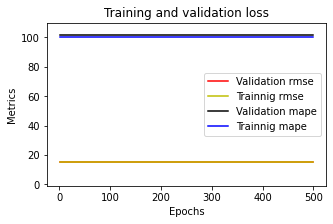

In [156]:
plotme(model1_4)

In [22]:
# inputs: distance
model1_5 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model1_5

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 565783.7500 - distance_layer_loss: 2.2292 - traveltime_layer_loss: 808261.4375 - distance_layer_mape: 107232.5000 - distance_layer_rmse: 1.4931 - traveltime_layer_mape: 99.4639 - traveltime_layer_rmse: 899.0336 - val_loss: 564008.1875 - val_distance_layer_loss: 12.4878 - val_traveltime_layer_loss: 805720.3125 - val_distance_layer_mape: 3037.8811 - val_distance_layer_rmse: 3.5338 - val_traveltime_layer_mape: 97.8979 - val_traveltime_layer_rmse: 897.6193
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 500281.3438 - distance_layer_loss: 100.0309 - traveltime_layer_loss: 714644.8750 - distance_layer_mape: 730070.6250 - distance_layer_rmse: 10.0015 - traveltime_layer_mape: 89.4499 - traveltime_layer_rmse: 845.3667 - val_loss: 415589.3125 - val_distance_layer_loss: 278.1030 - val_traveltime_layer_loss: 593579.7500 - val_distance_layer_mape: 13806.0557 - val_distance_layer_rmse: 16.6764 - val

179/179 [==============================] - 0s 1ms/step - loss: 119955.8594 - distance_layer_loss: 1568.1686 - traveltime_layer_loss: 170693.4062 - distance_layer_mape: 4850401.5000 - distance_layer_rmse: 39.6001 - traveltime_layer_mape: 53.0401 - traveltime_layer_rmse: 413.1506 - val_loss: 123964.6719 - val_distance_layer_loss: 1565.1705 - val_traveltime_layer_loss: 176421.5781 - val_distance_layer_mape: 32624.5156 - val_distance_layer_rmse: 39.5622 - val_traveltime_layer_mape: 52.4305 - val_traveltime_layer_rmse: 420.0257
Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 119816.9062 - distance_layer_loss: 1554.3221 - traveltime_layer_loss: 170500.9062 - distance_layer_mape: 4813008.5000 - distance_layer_rmse: 39.4249 - traveltime_layer_mape: 52.8348 - traveltime_layer_rmse: 412.9175 - val_loss: 123836.5312 - val_distance_layer_loss: 1583.7103 - val_traveltime_layer_loss: 176230.6562 - val_distance_layer_mape: 32822.8086 - val_distance_layer_rmse: 39.7959 - va

179/179 [==============================] - 0s 1ms/step - loss: 118496.2031 - distance_layer_loss: 1415.9406 - traveltime_layer_loss: 168673.5156 - distance_layer_mape: 4970568.5000 - distance_layer_rmse: 37.6290 - traveltime_layer_mape: 53.2613 - traveltime_layer_rmse: 410.6988 - val_loss: 121969.4844 - val_distance_layer_loss: 1411.6061 - val_traveltime_layer_loss: 173637.1562 - val_distance_layer_mape: 31078.0586 - val_distance_layer_rmse: 37.5713 - val_traveltime_layer_mape: 52.5556 - val_traveltime_layer_rmse: 416.6979
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 118400.7812 - distance_layer_loss: 1401.5099 - traveltime_layer_loss: 168543.3906 - distance_layer_mape: 5000838.5000 - distance_layer_rmse: 37.4367 - traveltime_layer_mape: 53.1256 - traveltime_layer_rmse: 410.5404 - val_loss: 121865.8906 - val_distance_layer_loss: 1404.9972 - val_traveltime_layer_loss: 173491.9688 - val_distance_layer_mape: 31010.2715 - val_distance_layer_rmse: 37.4833 - va

179/179 [==============================] - 0s 1ms/step - loss: 117558.5547 - distance_layer_loss: 1278.2858 - traveltime_layer_loss: 167392.9531 - distance_layer_mape: 4965091.0000 - distance_layer_rmse: 35.7531 - traveltime_layer_mape: 53.6447 - traveltime_layer_rmse: 409.1368 - val_loss: 121395.7812 - val_distance_layer_loss: 1225.2782 - val_traveltime_layer_loss: 172897.4531 - val_distance_layer_mape: 29019.9219 - val_distance_layer_rmse: 35.0040 - val_traveltime_layer_mape: 50.6199 - val_traveltime_layer_rmse: 415.8094
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 117655.0625 - distance_layer_loss: 1258.3540 - traveltime_layer_loss: 167539.3750 - distance_layer_mape: 4956885.5000 - distance_layer_rmse: 35.4733 - traveltime_layer_mape: 53.1839 - traveltime_layer_rmse: 409.3157 - val_loss: 120985.2422 - val_distance_layer_loss: 1240.5618 - val_traveltime_layer_loss: 172304.4062 - val_distance_layer_mape: 29201.3242 - val_distance_layer_rmse: 35.2216 - va

179/179 [==============================] - 0s 1ms/step - loss: 117356.4297 - distance_layer_loss: 1160.1068 - traveltime_layer_loss: 167154.8594 - distance_layer_mape: 4889721.5000 - distance_layer_rmse: 34.0603 - traveltime_layer_mape: 53.4013 - traveltime_layer_rmse: 408.8458 - val_loss: 120431.6875 - val_distance_layer_loss: 1146.6575 - val_traveltime_layer_loss: 171553.8594 - val_distance_layer_mape: 28105.5391 - val_distance_layer_rmse: 33.8623 - val_traveltime_layer_mape: 52.0644 - val_traveltime_layer_rmse: 414.1906
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 117213.1328 - distance_layer_loss: 1151.0331 - traveltime_layer_loss: 166954.0000 - distance_layer_mape: 4938001.5000 - distance_layer_rmse: 33.9269 - traveltime_layer_mape: 53.2529 - traveltime_layer_rmse: 408.6000 - val_loss: 120351.4141 - val_distance_layer_loss: 1167.4192 - val_traveltime_layer_loss: 171430.2344 - val_distance_layer_mape: 28357.6309 - val_distance_layer_rmse: 34.1675 - va

179/179 [==============================] - 0s 1ms/step - loss: 117119.5156 - distance_layer_loss: 1073.9742 - traveltime_layer_loss: 166853.3438 - distance_layer_mape: 4875619.0000 - distance_layer_rmse: 32.7715 - traveltime_layer_mape: 53.3166 - traveltime_layer_rmse: 408.4769 - val_loss: 120096.4453 - val_distance_layer_loss: 1081.4855 - val_traveltime_layer_loss: 171102.8281 - val_distance_layer_mape: 27311.0234 - val_distance_layer_rmse: 32.8859 - val_traveltime_layer_mape: 52.9769 - val_traveltime_layer_rmse: 413.6458
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 117058.6953 - distance_layer_loss: 1075.7941 - traveltime_layer_loss: 166765.6875 - distance_layer_mape: 4871364.5000 - distance_layer_rmse: 32.7993 - traveltime_layer_mape: 53.6408 - traveltime_layer_rmse: 408.3695 - val_loss: 120241.2891 - val_distance_layer_loss: 1053.3148 - val_traveltime_layer_loss: 171321.8594 - val_distance_layer_mape: 26956.2637 - val_distance_layer_rmse: 32.4548 - va

179/179 [==============================] - 0s 1ms/step - loss: 116978.6719 - distance_layer_loss: 1020.2657 - traveltime_layer_loss: 166675.2188 - distance_layer_mape: 4822600.5000 - distance_layer_rmse: 31.9416 - traveltime_layer_mape: 53.8066 - traveltime_layer_rmse: 408.2588 - val_loss: 120196.5938 - val_distance_layer_loss: 992.3619 - val_traveltime_layer_loss: 171284.1562 - val_distance_layer_mape: 26171.5000 - val_distance_layer_rmse: 31.5018 - val_traveltime_layer_mape: 51.4724 - val_traveltime_layer_rmse: 413.8649
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 117013.2266 - distance_layer_loss: 1011.6748 - traveltime_layer_loss: 166728.2188 - distance_layer_mape: 4781962.0000 - distance_layer_rmse: 31.8068 - traveltime_layer_mape: 53.5027 - traveltime_layer_rmse: 408.3237 - val_loss: 120050.2578 - val_distance_layer_loss: 999.8330 - val_traveltime_layer_loss: 171071.8750 - val_distance_layer_mape: 26268.5840 - val_distance_layer_rmse: 31.6201 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116910.4922 - distance_layer_loss: 967.7152 - traveltime_layer_loss: 166600.2500 - distance_layer_mape: 4707514.5000 - distance_layer_rmse: 31.1081 - traveltime_layer_mape: 53.5246 - traveltime_layer_rmse: 408.1669 - val_loss: 119918.3203 - val_distance_layer_loss: 971.4722 - val_traveltime_layer_loss: 170895.5156 - val_distance_layer_mape: 25892.3633 - val_distance_layer_rmse: 31.1684 - val_traveltime_layer_mape: 52.9831 - val_traveltime_layer_rmse: 413.3951
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 116919.2969 - distance_layer_loss: 965.7380 - traveltime_layer_loss: 166613.6562 - distance_layer_mape: 4688576.5000 - distance_layer_rmse: 31.0763 - traveltime_layer_mape: 53.6565 - traveltime_layer_rmse: 408.1833 - val_loss: 119911.7656 - val_distance_layer_loss: 967.3528 - val_traveltime_layer_loss: 170887.9531 - val_distance_layer_mape: 25837.5391 - val_distance_layer_rmse: 31.1023 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116880.5781 - distance_layer_loss: 927.5243 - traveltime_layer_loss: 166574.7969 - distance_layer_mape: 4590203.5000 - distance_layer_rmse: 30.4553 - traveltime_layer_mape: 53.5441 - traveltime_layer_rmse: 408.1358 - val_loss: 119926.0938 - val_distance_layer_loss: 923.7126 - val_traveltime_layer_loss: 170927.1719 - val_distance_layer_mape: 25247.5430 - val_distance_layer_rmse: 30.3926 - val_traveltime_layer_mape: 52.4973 - val_traveltime_layer_rmse: 413.4334
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 116859.2422 - distance_layer_loss: 927.2850 - traveltime_layer_loss: 166544.3750 - distance_layer_mape: 4638902.0000 - distance_layer_rmse: 30.4514 - traveltime_layer_mape: 53.7001 - traveltime_layer_rmse: 408.0985 - val_loss: 119942.2656 - val_distance_layer_loss: 918.9924 - val_traveltime_layer_loss: 170952.2656 - val_distance_layer_mape: 25183.5879 - val_distance_layer_rmse: 30.3149 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116830.2656 - distance_layer_loss: 895.1370 - traveltime_layer_loss: 166516.7812 - distance_layer_mape: 4579237.5000 - distance_layer_rmse: 29.9188 - traveltime_layer_mape: 53.6215 - traveltime_layer_rmse: 408.0647 - val_loss: 119959.1016 - val_distance_layer_loss: 885.4807 - val_traveltime_layer_loss: 170990.6406 - val_distance_layer_mape: 24717.7773 - val_distance_layer_rmse: 29.7570 - val_traveltime_layer_mape: 52.2115 - val_traveltime_layer_rmse: 413.5101
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 116791.6172 - distance_layer_loss: 892.7292 - traveltime_layer_loss: 166462.6562 - distance_layer_mape: 4559233.5000 - distance_layer_rmse: 29.8786 - traveltime_layer_mape: 53.5707 - traveltime_layer_rmse: 407.9984 - val_loss: 120082.0234 - val_distance_layer_loss: 873.9535 - val_traveltime_layer_loss: 171171.2188 - val_distance_layer_mape: 24557.6113 - val_distance_layer_rmse: 29.5627 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116800.7266 - distance_layer_loss: 860.4454 - traveltime_layer_loss: 166489.4062 - distance_layer_mape: 4421269.5000 - distance_layer_rmse: 29.3334 - traveltime_layer_mape: 53.3746 - traveltime_layer_rmse: 408.0311 - val_loss: 119985.6953 - val_distance_layer_loss: 853.4601 - val_traveltime_layer_loss: 171042.3438 - val_distance_layer_mape: 24264.5000 - val_distance_layer_rmse: 29.2140 - val_traveltime_layer_mape: 52.1147 - val_traveltime_layer_rmse: 413.5727
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 116756.6562 - distance_layer_loss: 861.2173 - traveltime_layer_loss: 166426.1250 - distance_layer_mape: 4471175.5000 - distance_layer_rmse: 29.3465 - traveltime_layer_mape: 53.5673 - traveltime_layer_rmse: 407.9536 - val_loss: 120126.8906 - val_distance_layer_loss: 840.8643 - val_traveltime_layer_loss: 171249.4688 - val_distance_layer_mape: 24086.1992 - val_distance_layer_rmse: 28.9977 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116815.0234 - distance_layer_loss: 835.5686 - traveltime_layer_loss: 166520.5000 - distance_layer_mape: 4377582.0000 - distance_layer_rmse: 28.9062 - traveltime_layer_mape: 53.5019 - traveltime_layer_rmse: 408.0692 - val_loss: 119933.7578 - val_distance_layer_loss: 836.9250 - val_traveltime_layer_loss: 170975.2969 - val_distance_layer_mape: 24024.5059 - val_distance_layer_rmse: 28.9297 - val_traveltime_layer_mape: 52.7680 - val_traveltime_layer_rmse: 413.4916
Epoch 167/500
179/179 [==============================] - 0s 1ms/step - loss: 116732.6875 - distance_layer_loss: 834.5911 - traveltime_layer_loss: 166403.3594 - distance_layer_mape: 4374552.0000 - distance_layer_rmse: 28.8893 - traveltime_layer_mape: 53.4892 - traveltime_layer_rmse: 407.9257 - val_loss: 119980.1406 - val_distance_layer_loss: 827.3966 - val_traveltime_layer_loss: 171045.5781 - val_distance_layer_mape: 23887.6191 - val_distance_layer_rmse: 28.7645 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116790.8125 - distance_layer_loss: 812.1410 - traveltime_layer_loss: 166495.9531 - distance_layer_mape: 4368616.5000 - distance_layer_rmse: 28.4981 - traveltime_layer_mape: 53.5225 - traveltime_layer_rmse: 408.0392 - val_loss: 119963.1094 - val_distance_layer_loss: 809.3026 - val_traveltime_layer_loss: 171029.0469 - val_distance_layer_mape: 23622.3887 - val_distance_layer_rmse: 28.4482 - val_traveltime_layer_mape: 52.5258 - val_traveltime_layer_rmse: 413.5566
Epoch 182/500
179/179 [==============================] - 0s 1ms/step - loss: 116735.3516 - distance_layer_loss: 811.9080 - traveltime_layer_loss: 166416.8906 - distance_layer_mape: 4328966.0000 - distance_layer_rmse: 28.4940 - traveltime_layer_mape: 53.6154 - traveltime_layer_rmse: 407.9423 - val_loss: 120063.6875 - val_distance_layer_loss: 798.0670 - val_traveltime_layer_loss: 171177.5469 - val_distance_layer_mape: 23459.1250 - val_distance_layer_rmse: 28.2501 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116667.7109 - distance_layer_loss: 787.8634 - traveltime_layer_loss: 166330.5469 - distance_layer_mape: 4258365.0000 - distance_layer_rmse: 28.0689 - traveltime_layer_mape: 53.3870 - traveltime_layer_rmse: 407.8364 - val_loss: 119962.8438 - val_distance_layer_loss: 794.5660 - val_traveltime_layer_loss: 171034.9688 - val_distance_layer_mape: 23403.7324 - val_distance_layer_rmse: 28.1880 - val_traveltime_layer_mape: 53.0379 - val_traveltime_layer_rmse: 413.5638
Epoch 197/500
179/179 [==============================] - 0s 1ms/step - loss: 116632.4688 - distance_layer_loss: 797.3917 - traveltime_layer_loss: 166276.1406 - distance_layer_mape: 4302410.5000 - distance_layer_rmse: 28.2381 - traveltime_layer_mape: 54.0939 - traveltime_layer_rmse: 407.7697 - val_loss: 120728.2109 - val_distance_layer_loss: 750.6673 - val_traveltime_layer_loss: 172147.1562 - val_distance_layer_mape: 22752.7500 - val_distance_layer_rmse: 27.3983 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116740.7656 - distance_layer_loss: 767.4094 - traveltime_layer_loss: 166443.6719 - distance_layer_mape: 4207620.5000 - distance_layer_rmse: 27.7022 - traveltime_layer_mape: 53.4193 - traveltime_layer_rmse: 407.9751 - val_loss: 119978.0078 - val_distance_layer_loss: 771.0738 - val_traveltime_layer_loss: 171066.6875 - val_distance_layer_mape: 23053.4160 - val_distance_layer_rmse: 27.7682 - val_traveltime_layer_mape: 52.8624 - val_traveltime_layer_rmse: 413.6021
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 116684.5859 - distance_layer_loss: 769.1816 - traveltime_layer_loss: 166362.6562 - distance_layer_mape: 4193873.0000 - distance_layer_rmse: 27.7341 - traveltime_layer_mape: 53.6244 - traveltime_layer_rmse: 407.8758 - val_loss: 120120.1953 - val_distance_layer_loss: 753.8566 - val_traveltime_layer_loss: 171277.1875 - val_distance_layer_mape: 22796.3613 - val_distance_layer_rmse: 27.4564 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116639.7734 - distance_layer_loss: 747.0785 - traveltime_layer_loss: 166308.1250 - distance_layer_mape: 4148486.5000 - distance_layer_rmse: 27.3327 - traveltime_layer_mape: 53.2949 - traveltime_layer_rmse: 407.8089 - val_loss: 120027.8516 - val_distance_layer_loss: 761.9565 - val_traveltime_layer_loss: 171141.8438 - val_distance_layer_mape: 22914.4727 - val_distance_layer_rmse: 27.6036 - val_traveltime_layer_mape: 53.5771 - val_traveltime_layer_rmse: 413.6929
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 116710.5000 - distance_layer_loss: 752.3926 - traveltime_layer_loss: 166406.8438 - distance_layer_mape: 4174177.7500 - distance_layer_rmse: 27.4298 - traveltime_layer_mape: 53.7649 - traveltime_layer_rmse: 407.9300 - val_loss: 120056.7344 - val_distance_layer_loss: 741.7697 - val_traveltime_layer_loss: 171191.7188 - val_distance_layer_mape: 22611.1641 - val_distance_layer_rmse: 27.2354 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116663.4062 - distance_layer_loss: 731.8314 - traveltime_layer_loss: 166348.4375 - distance_layer_mape: 4139206.2500 - distance_layer_rmse: 27.0524 - traveltime_layer_mape: 53.4766 - traveltime_layer_rmse: 407.8584 - val_loss: 120016.9375 - val_distance_layer_loss: 740.8234 - val_traveltime_layer_loss: 171135.2969 - val_distance_layer_mape: 22593.6895 - val_distance_layer_rmse: 27.2181 - val_traveltime_layer_mape: 53.3502 - val_traveltime_layer_rmse: 413.6850
Epoch 242/500
179/179 [==============================] - 0s 1ms/step - loss: 116710.4453 - distance_layer_loss: 736.4033 - traveltime_layer_loss: 166413.5781 - distance_layer_mape: 4096548.5000 - distance_layer_rmse: 27.1368 - traveltime_layer_mape: 53.8668 - traveltime_layer_rmse: 407.9382 - val_loss: 120207.4531 - val_distance_layer_loss: 714.8864 - val_traveltime_layer_loss: 171418.4844 - val_distance_layer_mape: 22197.5508 - val_distance_layer_rmse: 26.7374 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116783.7969 - distance_layer_loss: 719.1177 - traveltime_layer_loss: 166525.7344 - distance_layer_mape: 4051643.2500 - distance_layer_rmse: 26.8164 - traveltime_layer_mape: 53.7699 - traveltime_layer_rmse: 408.0757 - val_loss: 120025.7734 - val_distance_layer_loss: 717.1771 - val_traveltime_layer_loss: 171158.0625 - val_distance_layer_mape: 22230.1816 - val_distance_layer_rmse: 26.7802 - val_traveltime_layer_mape: 52.7912 - val_traveltime_layer_rmse: 413.7125
Epoch 257/500
179/179 [==============================] - 0s 1ms/step - loss: 116640.5391 - distance_layer_loss: 709.4205 - traveltime_layer_loss: 166325.3281 - distance_layer_mape: 4046293.0000 - distance_layer_rmse: 26.6349 - traveltime_layer_mape: 53.0788 - traveltime_layer_rmse: 407.8300 - val_loss: 120038.8359 - val_distance_layer_loss: 724.5779 - val_traveltime_layer_loss: 171173.5156 - val_distance_layer_mape: 22343.3359 - val_distance_layer_rmse: 26.9180 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116690.1406 - distance_layer_loss: 692.7699 - traveltime_layer_loss: 166403.2656 - distance_layer_mape: 4017740.2500 - distance_layer_rmse: 26.3205 - traveltime_layer_mape: 52.9434 - traveltime_layer_rmse: 407.9256 - val_loss: 120036.6484 - val_distance_layer_loss: 707.3531 - val_traveltime_layer_loss: 171177.7344 - val_distance_layer_mape: 22075.9238 - val_distance_layer_rmse: 26.5961 - val_traveltime_layer_mape: 53.2476 - val_traveltime_layer_rmse: 413.7363
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 116658.6875 - distance_layer_loss: 701.9707 - traveltime_layer_loss: 166354.4219 - distance_layer_mape: 4065939.7500 - distance_layer_rmse: 26.4947 - traveltime_layer_mape: 53.6858 - traveltime_layer_rmse: 407.8657 - val_loss: 120077.9219 - val_distance_layer_loss: 694.0073 - val_traveltime_layer_loss: 171242.4375 - val_distance_layer_mape: 21868.7695 - val_distance_layer_rmse: 26.3440 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116680.6562 - distance_layer_loss: 684.0383 - traveltime_layer_loss: 166393.4531 - distance_layer_mape: 3934475.7500 - distance_layer_rmse: 26.1541 - traveltime_layer_mape: 53.3624 - traveltime_layer_rmse: 407.9135 - val_loss: 120067.3828 - val_distance_layer_loss: 683.2347 - val_traveltime_layer_loss: 171231.9844 - val_distance_layer_mape: 21697.8438 - val_distance_layer_rmse: 26.1388 - val_traveltime_layer_mape: 52.4951 - val_traveltime_layer_rmse: 413.8019
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 116669.8438 - distance_layer_loss: 686.9771 - traveltime_layer_loss: 166376.7656 - distance_layer_mape: 3999464.2500 - distance_layer_rmse: 26.2102 - traveltime_layer_mape: 53.6708 - traveltime_layer_rmse: 407.8931 - val_loss: 120150.2891 - val_distance_layer_loss: 674.4432 - val_traveltime_layer_loss: 171354.2344 - val_distance_layer_mape: 21558.3613 - val_distance_layer_rmse: 25.9700 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116664.4922 - distance_layer_loss: 671.7513 - traveltime_layer_loss: 166375.7500 - distance_layer_mape: 3923868.5000 - distance_layer_rmse: 25.9182 - traveltime_layer_mape: 53.4456 - traveltime_layer_rmse: 407.8918 - val_loss: 120173.4688 - val_distance_layer_loss: 660.7037 - val_traveltime_layer_loss: 171393.1562 - val_distance_layer_mape: 21337.6680 - val_distance_layer_rmse: 25.7042 - val_traveltime_layer_mape: 51.8143 - val_traveltime_layer_rmse: 413.9966
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 116687.5781 - distance_layer_loss: 666.9473 - traveltime_layer_loss: 166410.6562 - distance_layer_mape: 3936923.0000 - distance_layer_rmse: 25.8253 - traveltime_layer_mape: 53.2254 - traveltime_layer_rmse: 407.9346 - val_loss: 120053.6094 - val_distance_layer_loss: 676.1578 - val_traveltime_layer_loss: 171215.3594 - val_distance_layer_mape: 21583.8027 - val_distance_layer_rmse: 26.0030 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116667.1797 - distance_layer_loss: 661.2866 - traveltime_layer_loss: 166383.9844 - distance_layer_mape: 3889573.5000 - distance_layer_rmse: 25.7155 - traveltime_layer_mape: 53.6759 - traveltime_layer_rmse: 407.9019 - val_loss: 120069.2734 - val_distance_layer_loss: 658.2482 - val_traveltime_layer_loss: 171245.4688 - val_distance_layer_mape: 21296.8984 - val_distance_layer_rmse: 25.6563 - val_traveltime_layer_mape: 52.6068 - val_traveltime_layer_rmse: 413.8181
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 116630.1875 - distance_layer_loss: 657.7347 - traveltime_layer_loss: 166332.6719 - distance_layer_mape: 3885852.7500 - distance_layer_rmse: 25.6463 - traveltime_layer_mape: 53.4517 - traveltime_layer_rmse: 407.8390 - val_loss: 120069.4922 - val_distance_layer_loss: 657.3117 - val_traveltime_layer_loss: 171246.1406 - val_distance_layer_mape: 21281.5996 - val_distance_layer_rmse: 25.6381 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116625.1328 - distance_layer_loss: 652.1473 - traveltime_layer_loss: 166327.7500 - distance_layer_mape: 3879610.5000 - distance_layer_rmse: 25.5372 - traveltime_layer_mape: 53.9817 - traveltime_layer_rmse: 407.8330 - val_loss: 120409.1328 - val_distance_layer_loss: 625.9224 - val_traveltime_layer_loss: 171744.7812 - val_distance_layer_mape: 20770.0410 - val_distance_layer_rmse: 25.0184 - val_traveltime_layer_mape: 51.0384 - val_traveltime_layer_rmse: 414.4210
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 116715.8125 - distance_layer_loss: 643.4434 - traveltime_layer_loss: 166461.1250 - distance_layer_mape: 3834206.2500 - distance_layer_rmse: 25.3662 - traveltime_layer_mape: 53.2545 - traveltime_layer_rmse: 407.9965 - val_loss: 120222.9688 - val_distance_layer_loss: 633.5735 - val_traveltime_layer_loss: 171475.5781 - val_distance_layer_mape: 20895.9277 - val_distance_layer_rmse: 25.1709 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116644.2734 - distance_layer_loss: 633.5168 - traveltime_layer_loss: 166363.2188 - distance_layer_mape: 3791144.5000 - distance_layer_rmse: 25.1698 - traveltime_layer_mape: 53.3654 - traveltime_layer_rmse: 407.8765 - val_loss: 120068.1016 - val_distance_layer_loss: 637.9052 - val_traveltime_layer_loss: 171252.4688 - val_distance_layer_mape: 20965.6855 - val_distance_layer_rmse: 25.2568 - val_traveltime_layer_mape: 52.9196 - val_traveltime_layer_rmse: 413.8266
Epoch 347/500
179/179 [==============================] - 0s 1ms/step - loss: 116688.3828 - distance_layer_loss: 635.6904 - traveltime_layer_loss: 166425.2969 - distance_layer_mape: 3836153.5000 - distance_layer_rmse: 25.2129 - traveltime_layer_mape: 53.5779 - traveltime_layer_rmse: 407.9526 - val_loss: 120112.1406 - val_distance_layer_loss: 629.7191 - val_traveltime_layer_loss: 171318.8906 - val_distance_layer_mape: 20831.7129 - val_distance_layer_rmse: 25.0942 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116674.3594 - distance_layer_loss: 619.1406 - traveltime_layer_loss: 166412.3594 - distance_layer_mape: 3761142.0000 - distance_layer_rmse: 24.8825 - traveltime_layer_mape: 53.1530 - traveltime_layer_rmse: 407.9367 - val_loss: 120073.5234 - val_distance_layer_loss: 629.8829 - val_traveltime_layer_loss: 171263.7188 - val_distance_layer_mape: 20833.4141 - val_distance_layer_rmse: 25.0975 - val_traveltime_layer_mape: 53.1924 - val_traveltime_layer_rmse: 413.8402
Epoch 362/500
179/179 [==============================] - 0s 1ms/step - loss: 116744.5703 - distance_layer_loss: 623.3914 - traveltime_layer_loss: 166510.7969 - distance_layer_mape: 3760083.0000 - distance_layer_rmse: 24.9678 - traveltime_layer_mape: 53.4968 - traveltime_layer_rmse: 408.0573 - val_loss: 120115.6641 - val_distance_layer_loss: 618.8949 - val_traveltime_layer_loss: 171328.5938 - val_distance_layer_mape: 20652.5898 - val_distance_layer_rmse: 24.8776 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116723.4453 - distance_layer_loss: 609.7430 - traveltime_layer_loss: 166486.4844 - distance_layer_mape: 3719704.2500 - distance_layer_rmse: 24.6930 - traveltime_layer_mape: 53.1908 - traveltime_layer_rmse: 408.0276 - val_loss: 120083.9531 - val_distance_layer_loss: 613.2544 - val_traveltime_layer_loss: 171285.6406 - val_distance_layer_mape: 20557.8125 - val_distance_layer_rmse: 24.7640 - val_traveltime_layer_mape: 52.6313 - val_traveltime_layer_rmse: 413.8667
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 116676.8359 - distance_layer_loss: 612.4884 - traveltime_layer_loss: 166418.6875 - distance_layer_mape: 3753393.5000 - distance_layer_rmse: 24.7485 - traveltime_layer_mape: 53.4704 - traveltime_layer_rmse: 407.9445 - val_loss: 120102.6797 - val_distance_layer_loss: 609.2097 - val_traveltime_layer_loss: 171314.1719 - val_distance_layer_mape: 20490.3027 - val_distance_layer_rmse: 24.6822 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116731.4375 - distance_layer_loss: 602.6016 - traveltime_layer_loss: 166500.9844 - distance_layer_mape: 3703728.5000 - distance_layer_rmse: 24.5479 - traveltime_layer_mape: 53.3987 - traveltime_layer_rmse: 408.0453 - val_loss: 120122.5312 - val_distance_layer_loss: 614.9802 - val_traveltime_layer_loss: 171340.0938 - val_distance_layer_mape: 20585.7051 - val_distance_layer_rmse: 24.7988 - val_traveltime_layer_mape: 53.6653 - val_traveltime_layer_rmse: 413.9325
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 116700.7891 - distance_layer_loss: 606.4576 - traveltime_layer_loss: 166455.4375 - distance_layer_mape: 3695342.7500 - distance_layer_rmse: 24.6264 - traveltime_layer_mape: 53.8306 - traveltime_layer_rmse: 407.9895 - val_loss: 120099.0938 - val_distance_layer_loss: 600.7251 - val_traveltime_layer_loss: 171312.6719 - val_distance_layer_mape: 20347.5977 - val_distance_layer_rmse: 24.5097 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116675.7266 - distance_layer_loss: 594.2070 - traveltime_layer_loss: 166424.9531 - distance_layer_mape: 3721615.5000 - distance_layer_rmse: 24.3764 - traveltime_layer_mape: 53.5142 - traveltime_layer_rmse: 407.9521 - val_loss: 120102.8672 - val_distance_layer_loss: 591.0485 - val_traveltime_layer_loss: 171322.2188 - val_distance_layer_mape: 20183.7969 - val_distance_layer_rmse: 24.3115 - val_traveltime_layer_mape: 52.4244 - val_traveltime_layer_rmse: 413.9109
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 116647.1797 - distance_layer_loss: 592.5134 - traveltime_layer_loss: 166384.8906 - distance_layer_mape: 3696509.2500 - distance_layer_rmse: 24.3416 - traveltime_layer_mape: 53.4272 - traveltime_layer_rmse: 407.9030 - val_loss: 120124.8438 - val_distance_layer_loss: 588.3716 - val_traveltime_layer_loss: 171354.7500 - val_distance_layer_mape: 20138.5898 - val_distance_layer_rmse: 24.2564 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116695.7734 - distance_layer_loss: 583.4203 - traveltime_layer_loss: 166458.1562 - distance_layer_mape: 3639172.5000 - distance_layer_rmse: 24.1541 - traveltime_layer_mape: 53.4191 - traveltime_layer_rmse: 407.9928 - val_loss: 120247.0078 - val_distance_layer_loss: 571.9291 - val_traveltime_layer_loss: 171536.2812 - val_distance_layer_mape: 19856.8672 - val_distance_layer_rmse: 23.9150 - val_traveltime_layer_mape: 51.6067 - val_traveltime_layer_rmse: 414.1694
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 116661.3828 - distance_layer_loss: 585.0717 - traveltime_layer_loss: 166408.4062 - distance_layer_mape: 3656398.5000 - distance_layer_rmse: 24.1883 - traveltime_layer_mape: 53.5975 - traveltime_layer_rmse: 407.9319 - val_loss: 120258.0000 - val_distance_layer_loss: 571.3623 - val_traveltime_layer_loss: 171552.3125 - val_distance_layer_mape: 19847.1172 - val_distance_layer_rmse: 23.9032 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116686.5312 - distance_layer_loss: 576.0076 - traveltime_layer_loss: 166448.2344 - distance_layer_mape: 3598265.0000 - distance_layer_rmse: 24.0002 - traveltime_layer_mape: 53.5730 - traveltime_layer_rmse: 407.9807 - val_loss: 120095.2969 - val_distance_layer_loss: 572.9764 - val_traveltime_layer_loss: 171319.1719 - val_distance_layer_mape: 19873.8770 - val_distance_layer_rmse: 23.9369 - val_traveltime_layer_mape: 52.4756 - val_traveltime_layer_rmse: 413.9072
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 116608.4375 - distance_layer_loss: 571.8812 - traveltime_layer_loss: 166338.4219 - distance_layer_mape: 3622647.5000 - distance_layer_rmse: 23.9140 - traveltime_layer_mape: 53.2272 - traveltime_layer_rmse: 407.8461 - val_loss: 120096.1406 - val_distance_layer_loss: 572.8793 - val_traveltime_layer_loss: 171320.3906 - val_distance_layer_mape: 19872.7246 - val_distance_layer_rmse: 23.9349 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116616.5156 - distance_layer_loss: 567.9794 - traveltime_layer_loss: 166351.6094 - distance_layer_mape: 3592134.2500 - distance_layer_rmse: 23.8323 - traveltime_layer_mape: 53.6322 - traveltime_layer_rmse: 407.8622 - val_loss: 120183.5938 - val_distance_layer_loss: 558.0632 - val_traveltime_layer_loss: 171451.6562 - val_distance_layer_mape: 19615.8262 - val_distance_layer_rmse: 23.6234 - val_traveltime_layer_mape: 51.9016 - val_traveltime_layer_rmse: 414.0672
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 116624.4219 - distance_layer_loss: 564.3241 - traveltime_layer_loss: 166364.4531 - distance_layer_mape: 3612882.5000 - distance_layer_rmse: 23.7555 - traveltime_layer_mape: 53.3355 - traveltime_layer_rmse: 407.8780 - val_loss: 120243.9922 - val_distance_layer_loss: 554.4098 - val_traveltime_layer_loss: 171539.5312 - val_distance_layer_mape: 19551.9590 - val_distance_layer_rmse: 23.5459 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116678.6250 - distance_layer_loss: 556.9568 - traveltime_layer_loss: 166444.9531 - distance_layer_mape: 3575612.7500 - distance_layer_rmse: 23.5999 - traveltime_layer_mape: 53.3753 - traveltime_layer_rmse: 407.9767 - val_loss: 120197.5625 - val_distance_layer_loss: 548.4528 - val_traveltime_layer_loss: 171475.7656 - val_distance_layer_mape: 19446.9551 - val_distance_layer_rmse: 23.4191 - val_traveltime_layer_mape: 51.8108 - val_traveltime_layer_rmse: 414.0963
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 116568.4922 - distance_layer_loss: 560.2650 - traveltime_layer_loss: 166286.2969 - distance_layer_mape: 3542946.5000 - distance_layer_rmse: 23.6699 - traveltime_layer_mape: 53.7887 - traveltime_layer_rmse: 407.7822 - val_loss: 120472.2344 - val_distance_layer_loss: 537.4848 - val_traveltime_layer_loss: 171872.8594 - val_distance_layer_mape: 19253.0254 - val_distance_layer_rmse: 23.1837 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116614.8359 - distance_layer_loss: 546.5238 - traveltime_layer_loss: 166358.2812 - distance_layer_mape: 3561405.0000 - distance_layer_rmse: 23.3778 - traveltime_layer_mape: 53.2477 - traveltime_layer_rmse: 407.8704 - val_loss: 120077.3125 - val_distance_layer_loss: 554.3070 - val_traveltime_layer_loss: 171301.4219 - val_distance_layer_mape: 19549.6055 - val_distance_layer_rmse: 23.5437 - val_traveltime_layer_mape: 53.1172 - val_traveltime_layer_rmse: 413.8858
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 116587.1016 - distance_layer_loss: 551.5201 - traveltime_layer_loss: 166316.6562 - distance_layer_mape: 3563565.7500 - distance_layer_rmse: 23.4845 - traveltime_layer_mape: 53.6497 - traveltime_layer_rmse: 407.8194 - val_loss: 120164.1797 - val_distance_layer_loss: 541.8449 - val_traveltime_layer_loss: 171430.8906 - val_distance_layer_mape: 19330.2285 - val_distance_layer_rmse: 23.2776 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116695.0078 - distance_layer_loss: 543.0849 - traveltime_layer_loss: 166474.3125 - distance_layer_mape: 3554596.5000 - distance_layer_rmse: 23.3042 - traveltime_layer_mape: 53.5873 - traveltime_layer_rmse: 408.0126 - val_loss: 120079.5703 - val_distance_layer_loss: 546.6654 - val_traveltime_layer_loss: 171307.9219 - val_distance_layer_mape: 19414.9805 - val_distance_layer_rmse: 23.3809 - val_traveltime_layer_mape: 53.1286 - val_traveltime_layer_rmse: 413.8936
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 116638.1406 - distance_layer_loss: 543.6191 - traveltime_layer_loss: 166392.9844 - distance_layer_mape: 3549449.0000 - distance_layer_rmse: 23.3156 - traveltime_layer_mape: 53.6611 - traveltime_layer_rmse: 407.9130 - val_loss: 120182.4375 - val_distance_layer_loss: 532.8754 - val_traveltime_layer_loss: 171460.7969 - val_distance_layer_mape: 19170.7051 - val_distance_layer_rmse: 23.0841 - val_t

In [34]:
# inputs: distance
model1_10 = nnmodel(5,10,10,15, num_hlayers=2,Epoch=500)
model1_10

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 567411.5625 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 810587.6875 - distance_layer_mape: 99.9822 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 99.7058 - traveltime_layer_rmse: 900.3264 - val_loss: 572313.2500 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 817590.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 99.0845 - val_traveltime_layer_rmse: 904.2069
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 550474.6250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 786392.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 97.1967 - traveltime_layer_rmse: 886.7877 - val_loss: 540029.9375 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 771471.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_

Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 119716.3047 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 171023.2031 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0350 - traveltime_layer_rmse: 413.5495 - val_loss: 119961.2422 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171373.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5786 - val_traveltime_layer_rmse: 413.9724
Epoch 18/500
179/179 [==============================] - 0s 1ms/step - loss: 119698.7656 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170998.1094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8957 - traveltime_layer_rmse: 413.5192 - val_loss: 119921.3984 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171316.2656 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 33/500
179/179 [==============================] - 0s 1ms/step - loss: 119683.3438 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170976.1719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0301 - traveltime_layer_rmse: 413.4926 - val_loss: 119956.9453 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171367.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6313 - val_traveltime_layer_rmse: 413.9650
Epoch 34/500
179/179 [==============================] - 0s 1ms/step - loss: 119673.8828 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170962.6719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8804 - traveltime_layer_rmse: 413.4763 - val_loss: 119899.9141 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171285.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 49/500
179/179 [==============================] - 0s 1ms/step - loss: 119665.7344 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170950.9531 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2449 - traveltime_layer_rmse: 413.4622 - val_loss: 119979.8750 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171399.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5464 - val_traveltime_layer_rmse: 414.0046
Epoch 50/500
179/179 [==============================] - 0s 1ms/step - loss: 119632.6484 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170903.7969 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.6475 - traveltime_layer_rmse: 413.4051 - val_loss: 119892.5547 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171275.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 65/500
179/179 [==============================] - 0s 1ms/step - loss: 119666.1484 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170951.6094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0372 - traveltime_layer_rmse: 413.4630 - val_loss: 120002.4141 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171431.9531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4654 - val_traveltime_layer_rmse: 414.0434
Epoch 66/500
179/179 [==============================] - 0s 1ms/step - loss: 119616.2031 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170880.2188 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7827 - traveltime_layer_rmse: 413.3766 - val_loss: 119913.0469 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171304.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 81/500
179/179 [==============================] - 0s 1ms/step - loss: 119648.2500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170925.9375 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0203 - traveltime_layer_rmse: 413.4319 - val_loss: 119947.8125 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171353.9844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7956 - val_traveltime_layer_rmse: 413.9492
Epoch 82/500
179/179 [==============================] - 0s 1ms/step - loss: 119640.8594 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170915.4062 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0727 - traveltime_layer_rmse: 413.4192 - val_loss: 119942.5547 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171346.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 97/500
179/179 [==============================] - 0s 1ms/step - loss: 119645.4609 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170921.9062 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1489 - traveltime_layer_rmse: 413.4270 - val_loss: 119922.1562 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171317.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.0435 - val_traveltime_layer_rmse: 413.9050
Epoch 98/500
179/179 [==============================] - 0s 1ms/step - loss: 119661.2266 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170944.6094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1813 - traveltime_layer_rmse: 413.4545 - val_loss: 119994.7422 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171421.0156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

179/179 [==============================] - 0s 1ms/step - loss: 119626.3906 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170894.7969 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3208 - traveltime_layer_rmse: 413.3942 - val_loss: 120044.2656 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171491.7656 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.3463 - val_traveltime_layer_rmse: 414.1156
Epoch 113/500
179/179 [==============================] - 0s 1ms/step - loss: 119670.7344 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170958.1719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1769 - traveltime_layer_rmse: 413.4709 - val_loss: 119996.2422 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171423.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5

Epoch 128/500
179/179 [==============================] - 0s 1ms/step - loss: 119602.6094 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170860.7969 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3575 - traveltime_layer_rmse: 413.3531 - val_loss: 120033.2812 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171476.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4293 - val_traveltime_layer_rmse: 414.0967
Epoch 129/500
179/179 [==============================] - 0s 1ms/step - loss: 119623.1719 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170890.2031 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9089 - traveltime_layer_rmse: 413.3887 - val_loss: 119997.9766 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171425.5469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119622.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170889.7969 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9039 - traveltime_layer_rmse: 413.3882 - val_loss: 119930.0859 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171328.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.2407 - val_traveltime_layer_rmse: 413.9186
Epoch 144/500
179/179 [==============================] - 0s 1ms/step - loss: 119606.6562 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170866.6250 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.4282 - traveltime_layer_rmse: 413.3602 - val_loss: 120096.2500 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171566.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.1

Epoch 159/500
179/179 [==============================] - 0s 1ms/step - loss: 119612.1406 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170874.3438 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7369 - traveltime_layer_rmse: 413.3695 - val_loss: 119939.3281 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171341.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.1588 - val_traveltime_layer_rmse: 413.9345
Epoch 160/500
179/179 [==============================] - 0s 1ms/step - loss: 119624.8516 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170892.5781 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1481 - traveltime_layer_rmse: 413.3915 - val_loss: 119947.6953 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171353.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119610.5391 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170872.0938 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8500 - traveltime_layer_rmse: 413.3668 - val_loss: 119972.4375 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171389.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8440 - val_traveltime_layer_rmse: 413.9918
Epoch 175/500
179/179 [==============================] - 0s 1ms/step - loss: 119607.5391 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170867.8438 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2867 - traveltime_layer_rmse: 413.3616 - val_loss: 120013.5312 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171447.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5

Epoch 190/500
179/179 [==============================] - 0s 1ms/step - loss: 119613.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170876.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7615 - traveltime_layer_rmse: 413.3725 - val_loss: 119945.3438 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171350.4219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.1502 - val_traveltime_layer_rmse: 413.9449
Epoch 191/500
179/179 [==============================] - 0s 1ms/step - loss: 119633.7812 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170905.4062 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0786 - traveltime_layer_rmse: 413.4071 - val_loss: 119938.8594 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171341.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119599.8438 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170856.8906 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7433 - traveltime_layer_rmse: 413.3484 - val_loss: 119982.2266 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171403.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8493 - val_traveltime_layer_rmse: 414.0085
Epoch 206/500
179/179 [==============================] - 0s 1ms/step - loss: 119598.5156 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170854.9688 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3867 - traveltime_layer_rmse: 413.3461 - val_loss: 120021.9922 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171459.9219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5

Epoch 221/500
179/179 [==============================] - 0s 997us/step - loss: 119602.0938 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170860.1094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0465 - traveltime_layer_rmse: 413.3523 - val_loss: 120081.0703 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171544.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4628 - val_traveltime_layer_rmse: 414.1791
Epoch 222/500
179/179 [==============================] - 0s 1ms/step - loss: 119591.9297 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170845.6094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3837 - traveltime_layer_rmse: 413.3347 - val_loss: 120029.7188 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171471.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 119602.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170861.0469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3405 - traveltime_layer_rmse: 413.3534 - val_loss: 120019.9297 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171457.0156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9756 - val_traveltime_layer_rmse: 414.0737
Epoch 237/500
179/179 [==============================] - 0s 1ms/step - loss: 119619.6797 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170885.2031 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0675 - traveltime_layer_rmse: 413.3826 - val_loss: 120036.8125 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171481.1719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8

Epoch 252/500
179/179 [==============================] - 0s 1ms/step - loss: 119582.4531 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170832.0469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1074 - traveltime_layer_rmse: 413.3183 - val_loss: 120144.1797 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171634.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.3467 - val_traveltime_layer_rmse: 414.2879
Epoch 253/500
179/179 [==============================] - 0s 1ms/step - loss: 119606.6797 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170866.6094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7350 - traveltime_layer_rmse: 413.3601 - val_loss: 120013.3281 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171447.5469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119575.9141 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170822.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0222 - traveltime_layer_rmse: 413.3070 - val_loss: 120103.3359 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171576.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6467 - val_traveltime_layer_rmse: 414.2176
Epoch 268/500
179/179 [==============================] - 0s 1ms/step - loss: 119576.0781 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170822.8906 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9505 - traveltime_layer_rmse: 413.3073 - val_loss: 120062.1094 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171517.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9

Epoch 283/500
179/179 [==============================] - 0s 1ms/step - loss: 119581.2812 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170830.2656 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1631 - traveltime_layer_rmse: 413.3162 - val_loss: 120153.6328 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171648.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4647 - val_traveltime_layer_rmse: 414.3042
Epoch 284/500
179/179 [==============================] - 0s 1ms/step - loss: 119574.3203 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170820.3594 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7154 - traveltime_layer_rmse: 413.3042 - val_loss: 120071.3359 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171530.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119612.1953 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170874.5469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8714 - traveltime_layer_rmse: 413.3698 - val_loss: 120079.9219 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171542.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.0465 - val_traveltime_layer_rmse: 414.1772
Epoch 299/500
179/179 [==============================] - 0s 1ms/step - loss: 119562.8047 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170803.9531 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2357 - traveltime_layer_rmse: 413.2844 - val_loss: 120151.5938 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171645.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5

Epoch 314/500
179/179 [==============================] - 0s 1ms/step - loss: 119581.6406 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170830.8906 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2109 - traveltime_layer_rmse: 413.3169 - val_loss: 120127.0234 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171609.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7682 - val_traveltime_layer_rmse: 414.2583
Epoch 315/500
179/179 [==============================] - 0s 1ms/step - loss: 119586.6719 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170838.0000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1184 - traveltime_layer_rmse: 413.3255 - val_loss: 120153.9219 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171648.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119562.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170804.1094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0475 - traveltime_layer_rmse: 413.2845 - val_loss: 120120.5078 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171600.6406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8930 - val_traveltime_layer_rmse: 414.2471
Epoch 330/500
179/179 [==============================] - 0s 1ms/step - loss: 119569.0312 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170812.8594 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0835 - traveltime_layer_rmse: 413.2951 - val_loss: 120134.2344 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171620.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7

Epoch 345/500
179/179 [==============================] - 0s 1ms/step - loss: 119564.4062 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170806.2031 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3813 - traveltime_layer_rmse: 413.2871 - val_loss: 120185.1328 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171693.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4696 - val_traveltime_layer_rmse: 414.3586
Epoch 346/500
179/179 [==============================] - 0s 1ms/step - loss: 119583.0234 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170832.8750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9259 - traveltime_layer_rmse: 413.3193 - val_loss: 120133.4141 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171619.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119555.5234 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170793.5938 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2664 - traveltime_layer_rmse: 413.2718 - val_loss: 120149.0078 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171641.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6841 - val_traveltime_layer_rmse: 414.2963
Epoch 361/500
179/179 [==============================] - 0s 1ms/step - loss: 119576.8281 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170823.9375 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1965 - traveltime_layer_rmse: 413.3085 - val_loss: 120196.4531 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171709.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4

Epoch 376/500
179/179 [==============================] - 0s 1ms/step - loss: 119584.7969 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170835.4062 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0800 - traveltime_layer_rmse: 413.3224 - val_loss: 120104.9766 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171578.5469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9884 - val_traveltime_layer_rmse: 414.2204
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 119551.2500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170787.4219 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9148 - traveltime_layer_rmse: 413.2643 - val_loss: 120090.7266 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171558.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119572.2188 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170817.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.4399 - traveltime_layer_rmse: 413.3006 - val_loss: 120113.6719 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171590.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9256 - val_traveltime_layer_rmse: 414.2353
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 119565.7812 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170808.1719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1261 - traveltime_layer_rmse: 413.2895 - val_loss: 120121.2656 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171601.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8

Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 119580.2969 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170828.9375 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1135 - traveltime_layer_rmse: 413.3146 - val_loss: 120178.4688 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171683.4531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5883 - val_traveltime_layer_rmse: 414.3470
Epoch 408/500
179/179 [==============================] - 0s 1ms/step - loss: 119607.1953 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170867.3281 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0197 - traveltime_layer_rmse: 413.3610 - val_loss: 120112.1562 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171588.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119566.7812 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170809.6250 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2050 - traveltime_layer_rmse: 413.2912 - val_loss: 120125.1562 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171607.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9146 - val_traveltime_layer_rmse: 414.2551
Epoch 423/500
179/179 [==============================] - 0s 1ms/step - loss: 119564.2891 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170806.0469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9498 - traveltime_layer_rmse: 413.2869 - val_loss: 120133.2578 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171618.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8

Epoch 438/500
179/179 [==============================] - 0s 1ms/step - loss: 119581.2109 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170830.3125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8818 - traveltime_layer_rmse: 413.3162 - val_loss: 120105.2422 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171578.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.0991 - val_traveltime_layer_rmse: 414.2207
Epoch 439/500
179/179 [==============================] - 0s 1ms/step - loss: 119574.6875 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170820.9219 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8155 - traveltime_layer_rmse: 413.3049 - val_loss: 120104.9766 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171578.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119560.7578 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170801.0469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9766 - traveltime_layer_rmse: 413.2808 - val_loss: 120088.7969 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171555.3594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.3784 - val_traveltime_layer_rmse: 414.1924
Epoch 454/500
179/179 [==============================] - 0s 1ms/step - loss: 119556.2031 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170794.5156 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2984 - traveltime_layer_rmse: 413.2729 - val_loss: 120169.8516 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171671.1719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6

Epoch 469/500
179/179 [==============================] - 0s 1ms/step - loss: 119552.7422 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170789.6094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7449 - traveltime_layer_rmse: 413.2670 - val_loss: 120087.2812 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171553.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.3237 - val_traveltime_layer_rmse: 414.1898
Epoch 470/500
179/179 [==============================] - 0s 1ms/step - loss: 119563.3203 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170804.7344 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.5176 - traveltime_layer_rmse: 413.2853 - val_loss: 120138.1797 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171625.8906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119564.6328 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170806.5781 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2079 - traveltime_layer_rmse: 413.2875 - val_loss: 120153.9844 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171648.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7431 - val_traveltime_layer_rmse: 414.3048
Epoch 485/500
179/179 [==============================] - 0s 1ms/step - loss: 119571.3359 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170816.1406 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1335 - traveltime_layer_rmse: 413.2991 - val_loss: 120161.3594 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171658.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6

Epoch 500/500
179/179 [==============================] - 0s 1ms/step - loss: 119592.1641 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170845.8594 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9854 - traveltime_layer_rmse: 413.3351 - val_loss: 120153.5000 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171647.7969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7561 - val_traveltime_layer_rmse: 414.3040
minimum testing RMSE (distance):  0.0003639574944972992
minimum testing MAPE (distance):  1.0
-----------------
minimum testing ravel time):  6.89715576171875
minimum testing MAPE (travel time):  0.4522641372680664


In [35]:
# inputs: distance
model1_11 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model1_11

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 567892.2500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 811274.5000 - distance_layer_mape: 99.9226 - distance_layer_rmse: 0.3631 - traveltime_layer_mape: 99.7684 - traveltime_layer_rmse: 900.7078 - val_loss: 574031.9375 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 820045.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 99.3248 - val_traveltime_layer_rmse: 905.5637
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 553097.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 790140.1250 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 97.5776 - traveltime_layer_rmse: 888.8983 - val_loss: 543230.2500 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 776043.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_

Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 119746.7734 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 171066.7656 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0908 - traveltime_layer_rmse: 413.6022 - val_loss: 120262.7344 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171803.7969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9396 - val_traveltime_layer_rmse: 414.4922
Epoch 18/500
179/179 [==============================] - 0s 1ms/step - loss: 119783.7734 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 171119.6406 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0399 - traveltime_layer_rmse: 413.6661 - val_loss: 120255.7500 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171793.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 33/500
179/179 [==============================] - 0s 1ms/step - loss: 119674.0156 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170962.8281 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8079 - traveltime_layer_rmse: 413.4765 - val_loss: 120199.9844 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171714.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.0132 - val_traveltime_layer_rmse: 414.3841
Epoch 34/500
179/179 [==============================] - 0s 1ms/step - loss: 119687.4609 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170982.0156 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2438 - traveltime_layer_rmse: 413.4997 - val_loss: 120221.6094 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171745.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 49/500
179/179 [==============================] - 0s 989us/step - loss: 119648.5469 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170926.5312 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8057 - traveltime_layer_rmse: 413.4326 - val_loss: 120169.2812 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171670.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.2834 - val_traveltime_layer_rmse: 414.3312
Epoch 50/500
179/179 [==============================] - 0s 1ms/step - loss: 119659.5391 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170942.2031 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.5364 - traveltime_layer_rmse: 413.4516 - val_loss: 120262.6172 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171803.7031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

Epoch 65/500
179/179 [==============================] - 0s 1ms/step - loss: 119640.2031 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170914.4688 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3880 - traveltime_layer_rmse: 413.4180 - val_loss: 120219.2734 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171741.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6647 - val_traveltime_layer_rmse: 414.4174
Epoch 66/500
179/179 [==============================] - 0s 1ms/step - loss: 119618.3047 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170883.2188 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7833 - traveltime_layer_rmse: 413.3802 - val_loss: 120149.2500 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171641.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 81/500
179/179 [==============================] - 0s 1ms/step - loss: 119650.9844 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170929.9531 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0642 - traveltime_layer_rmse: 413.4368 - val_loss: 120269.8203 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171813.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.3555 - val_traveltime_layer_rmse: 414.5045
Epoch 82/500
179/179 [==============================] - 0s 1ms/step - loss: 119592.5156 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170846.4375 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7256 - traveltime_layer_rmse: 413.3358 - val_loss: 120138.9375 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171626.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

Epoch 97/500
179/179 [==============================] - 0s 1ms/step - loss: 119624.1484 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170891.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0500 - traveltime_layer_rmse: 413.3903 - val_loss: 120132.0859 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171617.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.2361 - val_traveltime_layer_rmse: 414.2671
Epoch 98/500
179/179 [==============================] - 0s 1ms/step - loss: 119608.4141 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170869.1562 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2445 - traveltime_layer_rmse: 413.3632 - val_loss: 120183.1016 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171690.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_laye

179/179 [==============================] - 0s 991us/step - loss: 119598.8047 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170855.4531 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2453 - traveltime_layer_rmse: 413.3466 - val_loss: 120167.9844 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171668.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9343 - val_traveltime_layer_rmse: 414.3289
Epoch 113/500
179/179 [==============================] - 0s 1ms/step - loss: 119604.8203 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170863.9531 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.7715 - traveltime_layer_rmse: 413.3569 - val_loss: 120131.9766 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171617.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53

Epoch 128/500
179/179 [==============================] - 0s 1ms/step - loss: 119596.1094 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170851.5469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0699 - traveltime_layer_rmse: 413.3419 - val_loss: 120139.8516 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171628.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.1151 - val_traveltime_layer_rmse: 414.2805
Epoch 129/500
179/179 [==============================] - 0s 1ms/step - loss: 119625.1328 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170892.9219 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3353 - traveltime_layer_rmse: 413.3920 - val_loss: 120182.7344 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171689.5469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119587.1797 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170838.7969 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8309 - traveltime_layer_rmse: 413.3265 - val_loss: 120119.8438 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171599.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.5115 - val_traveltime_layer_rmse: 414.2460
Epoch 144/500
179/179 [==============================] - 0s 1ms/step - loss: 119588.8359 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170841.1094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2738 - traveltime_layer_rmse: 413.3293 - val_loss: 120199.2578 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171713.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6

Epoch 159/500
179/179 [==============================] - 0s 1ms/step - loss: 119568.1484 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170811.5781 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9631 - traveltime_layer_rmse: 413.2936 - val_loss: 120175.9766 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171679.8594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7828 - val_traveltime_layer_rmse: 414.3427
Epoch 160/500
179/179 [==============================] - 0s 1ms/step - loss: 119546.9688 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170781.2656 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8277 - traveltime_layer_rmse: 413.2569 - val_loss: 120126.0000 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171608.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 996us/step - loss: 119569.2344 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170813.0938 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2037 - traveltime_layer_rmse: 413.2954 - val_loss: 120150.6172 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171643.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9608 - val_traveltime_layer_rmse: 414.2991
Epoch 175/500
179/179 [==============================] - 0s 996us/step - loss: 119576.2266 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170823.1250 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0515 - traveltime_layer_rmse: 413.3076 - val_loss: 120133.0781 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171618.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 

179/179 [==============================] - 0s 1ms/step - loss: 119589.7188 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170842.4219 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1154 - traveltime_layer_rmse: 413.3309 - val_loss: 120153.0703 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171647.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9440 - val_traveltime_layer_rmse: 414.3033
Epoch 190/500
179/179 [==============================] - 0s 1ms/step - loss: 119587.4375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170839.1562 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1379 - traveltime_layer_rmse: 413.3269 - val_loss: 120178.4141 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171683.3594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7

Epoch 205/500
179/179 [==============================] - 0s 1ms/step - loss: 119585.0625 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170835.7656 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1527 - traveltime_layer_rmse: 413.3228 - val_loss: 120264.4844 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171806.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.2694 - val_traveltime_layer_rmse: 414.4953
Epoch 206/500
179/179 [==============================] - 0s 1ms/step - loss: 119553.7422 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170791.0312 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8763 - traveltime_layer_rmse: 413.2687 - val_loss: 120113.7891 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171591.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119551.4609 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170787.6719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0167 - traveltime_layer_rmse: 413.2646 - val_loss: 120186.5859 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171695.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6183 - val_traveltime_layer_rmse: 414.3611
Epoch 221/500
179/179 [==============================] - 0s 1ms/step - loss: 119572.2422 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170817.3906 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8711 - traveltime_layer_rmse: 413.3006 - val_loss: 120145.7109 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171636.6406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8

Epoch 236/500
179/179 [==============================] - 0s 1ms/step - loss: 119545.3984 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170779.1562 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.3954 - traveltime_layer_rmse: 413.2543 - val_loss: 120172.2578 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171674.5469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6676 - val_traveltime_layer_rmse: 414.3363
Epoch 237/500
179/179 [==============================] - 0s 1ms/step - loss: 119560.3594 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170800.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8128 - traveltime_layer_rmse: 413.2800 - val_loss: 120142.7109 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171632.3594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119588.2656 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170840.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0137 - traveltime_layer_rmse: 413.3284 - val_loss: 120163.5859 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171662.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7673 - val_traveltime_layer_rmse: 414.3213
Epoch 252/500
179/179 [==============================] - 0s 1ms/step - loss: 119562.0391 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170802.9688 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1878 - traveltime_layer_rmse: 413.2832 - val_loss: 120148.4219 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171640.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7

Epoch 267/500
179/179 [==============================] - 0s 1ms/step - loss: 119551.0391 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170787.1719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1456 - traveltime_layer_rmse: 413.2640 - val_loss: 120143.0703 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171632.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7933 - val_traveltime_layer_rmse: 414.2860
Epoch 268/500
179/179 [==============================] - 0s 1ms/step - loss: 119565.8984 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170808.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0359 - traveltime_layer_rmse: 413.2897 - val_loss: 120155.3438 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171650.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119524.3516 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170749.0625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.5390 - traveltime_layer_rmse: 413.2179 - val_loss: 120100.8438 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171572.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.5081 - val_traveltime_layer_rmse: 414.2132
Epoch 283/500
179/179 [==============================] - 0s 1ms/step - loss: 119558.3125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170797.5312 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.5476 - traveltime_layer_rmse: 413.2766 - val_loss: 120149.9766 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171642.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7

Epoch 298/500
179/179 [==============================] - 0s 985us/step - loss: 119611.4922 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170873.4844 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8167 - traveltime_layer_rmse: 413.3685 - val_loss: 120179.4844 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171684.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.5828 - val_traveltime_layer_rmse: 414.3487
Epoch 299/500
179/179 [==============================] - 0s 1ms/step - loss: 119555.6562 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170793.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1688 - traveltime_layer_rmse: 413.2721 - val_loss: 120127.7891 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171611.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_

179/179 [==============================] - 0s 989us/step - loss: 119548.0703 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170782.8750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0080 - traveltime_layer_rmse: 413.2589 - val_loss: 120122.7031 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171603.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9666 - val_traveltime_layer_rmse: 414.2509
Epoch 314/500
179/179 [==============================] - 0s 1ms/step - loss: 119555.7031 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170793.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0951 - traveltime_layer_rmse: 413.2721 - val_loss: 120130.3516 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171614.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52

Epoch 329/500
179/179 [==============================] - 0s 1ms/step - loss: 119558.4922 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170797.7812 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1737 - traveltime_layer_rmse: 413.2769 - val_loss: 120143.9219 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171634.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.7138 - val_traveltime_layer_rmse: 414.2875
Epoch 330/500
179/179 [==============================] - 0s 1ms/step - loss: 119535.7109 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170765.2969 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1937 - traveltime_layer_rmse: 413.2376 - val_loss: 120213.9375 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171734.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119548.2891 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170783.1562 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8697 - traveltime_layer_rmse: 413.2592 - val_loss: 120092.9609 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171561.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.2580 - val_traveltime_layer_rmse: 414.1996
Epoch 345/500
179/179 [==============================] - 0s 990us/step - loss: 119569.0625 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170812.8906 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.4250 - traveltime_layer_rmse: 413.2952 - val_loss: 120135.0859 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171621.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52

179/179 [==============================] - 0s 1ms/step - loss: 119547.3672 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170781.8906 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9353 - traveltime_layer_rmse: 413.2577 - val_loss: 120110.3047 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171586.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.9836 - val_traveltime_layer_rmse: 414.2295
Epoch 360/500
179/179 [==============================] - 0s 1ms/step - loss: 119556.2422 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170794.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2912 - traveltime_layer_rmse: 413.2729 - val_loss: 120230.0781 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171757.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.2

Epoch 375/500
179/179 [==============================] - 0s 1ms/step - loss: 119551.1953 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170787.3438 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1609 - traveltime_layer_rmse: 413.2643 - val_loss: 120202.8594 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171718.3281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.3609 - val_traveltime_layer_rmse: 414.3891
Epoch 376/500
179/179 [==============================] - 0s 1ms/step - loss: 119565.6641 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170808.0469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9271 - traveltime_layer_rmse: 413.2893 - val_loss: 120154.9141 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171649.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119541.2109 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170773.1875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1457 - traveltime_layer_rmse: 413.2471 - val_loss: 120180.5703 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171686.5156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.4908 - val_traveltime_layer_rmse: 414.3507
Epoch 391/500
179/179 [==============================] - 0s 999us/step - loss: 119539.3984 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170770.5469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.6433 - traveltime_layer_rmse: 413.2439 - val_loss: 120088.8594 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171555.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53

Epoch 406/500
179/179 [==============================] - 0s 1ms/step - loss: 119551.8672 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170788.3125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0833 - traveltime_layer_rmse: 413.2654 - val_loss: 120082.8828 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171546.8906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.2665 - val_traveltime_layer_rmse: 414.1822
Epoch 407/500
179/179 [==============================] - 0s 989us/step - loss: 119518.1406 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170740.1562 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.6543 - traveltime_layer_rmse: 413.2072 - val_loss: 120293.2109 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171847.4219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 119568.5391 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170812.1875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1557 - traveltime_layer_rmse: 413.2943 - val_loss: 120146.0391 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171637.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6722 - val_traveltime_layer_rmse: 414.2911
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 119545.4766 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170779.1719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8228 - traveltime_layer_rmse: 413.2544 - val_loss: 120064.2344 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171520.2344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.5

Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 119550.3516 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170786.1875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0358 - traveltime_layer_rmse: 413.2628 - val_loss: 120075.9922 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171537.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.3029 - val_traveltime_layer_rmse: 414.1704
Epoch 438/500
179/179 [==============================] - 0s 1ms/step - loss: 119547.7812 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170782.4062 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0550 - traveltime_layer_rmse: 413.2583 - val_loss: 120079.3047 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171541.8594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 1ms/step - loss: 119549.3047 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170784.6094 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.4414 - traveltime_layer_rmse: 413.2610 - val_loss: 120140.7266 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171629.5781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.6395 - val_traveltime_layer_rmse: 414.2820
Epoch 453/500
179/179 [==============================] - 0s 1ms/step - loss: 119552.6953 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170789.5469 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.8939 - traveltime_layer_rmse: 413.2669 - val_loss: 120108.9297 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171584.1719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8

Epoch 468/500
179/179 [==============================] - 0s 1ms/step - loss: 119567.1484 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170810.1562 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0763 - traveltime_layer_rmse: 413.2918 - val_loss: 120078.0156 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171539.9844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.2419 - val_traveltime_layer_rmse: 414.1739
Epoch 469/500
179/179 [==============================] - 0s 1ms/step - loss: 119531.8594 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170759.7344 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.2299 - traveltime_layer_rmse: 413.2308 - val_loss: 120150.8906 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171644.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

179/179 [==============================] - 0s 997us/step - loss: 119567.9531 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170811.2500 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.0810 - traveltime_layer_rmse: 413.2932 - val_loss: 120083.4062 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171547.6719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 53.1179 - val_traveltime_layer_rmse: 414.1831
Epoch 484/500
179/179 [==============================] - 0s 1ms/step - loss: 119545.5703 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170779.3438 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1519 - traveltime_layer_rmse: 413.2546 - val_loss: 120141.6641 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171630.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52

Epoch 499/500
179/179 [==============================] - 0s 1ms/step - loss: 119542.6719 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170775.1719 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 53.9076 - traveltime_layer_rmse: 413.2495 - val_loss: 120116.1250 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171594.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 52.8220 - val_traveltime_layer_rmse: 414.2396
Epoch 500/500
179/179 [==============================] - 0s 1ms/step - loss: 119556.1484 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 170794.4688 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 54.1379 - traveltime_layer_rmse: 413.2729 - val_loss: 120127.5156 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 171610.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_la

In [26]:
# inputs: distance
model1_13 = nnmodel(5,6,2,5,10,5, num_hlayers=3,Epoch=500)
model1_13

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_lay

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 10

179/179 [==============================] - 0s 1ms/step - loss: 569468.1875 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.1875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9563 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 10

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 10

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 10

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 10

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 10

179/179 [==============================] - 0s 1ms/step - loss: 569468.0625 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 167/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.0625 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 182/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 197/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6875 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.6250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 242/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.9375 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 257/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.1250 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 347/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 362/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8750 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.6875 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.7500 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.7500 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9566 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.8125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9567 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3125 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569467.9375 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5000 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 569467.8125 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.5625 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9565 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 909.2882
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 569468.0000 - distance_layer_loss: 0.1319 - traveltime_layer_loss: 813525.3750 - distance_layer_mape: 99.9825 - distance_layer_rmse: 0.3632 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 901.9564 - val_loss: 578763.5625 - val_distance_layer_loss: 0.1325 - val_traveltime_layer_loss: 826805.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3640 - val_traveltime_layer_mape: 1

# sub-problem 2:     ******* input: hour *********

### cyclical encoding of hour

In [36]:
x = np.array(df[['O lat','O lon','D lat','D lon','hr_sin','hr_cos']])
y = np.array(df[['distance','travel time']])
y

array([[5.42629615e-01, 1.08200000e+03],
       [5.31770676e-01, 1.11000000e+03],
       [2.96433144e-01, 7.80000000e+02],
       ...,
       [3.84812390e-01, 9.70000000e+02],
       [6.79393237e-01, 1.41800000e+03],
       [1.88720986e-01, 4.02000000e+02]])

In [37]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [38]:
print(X_train.shape)
print(X_test.shape)
# X_train

(5720, 6)
(2452, 6)


In [30]:
# inputs: distance + hour
model2_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 567524.5000 - distance_layer_loss: 2.7222 - traveltime_layer_loss: 810748.2500 - distance_layer_mape: 266772.9375 - distance_layer_rmse: 1.6499 - traveltime_layer_mape: 99.7145 - traveltime_layer_rmse: 900.4156 - val_loss: 573754.7500 - val_distance_layer_loss: 8.5502 - val_traveltime_layer_loss: 819646.0000 - val_distance_layer_mape: 2510.8838 - val_distance_layer_rmse: 2.9241 - val_traveltime_layer_mape: 99.2893 - val_traveltime_layer_rmse: 905.3430
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 554910.4375 - distance_layer_loss: 32.1677 - traveltime_layer_loss: 792715.3750 - distance_layer_mape: 982994.0625 - distance_layer_rmse: 5.6717 - traveltime_layer_mape: 97.8657 - traveltime_layer_rmse: 890.3456 - val_loss: 548198.5625 - val_distance_layer_loss: 73.8398 - val_traveltime_layer_loss: 783109.2500 - val_distance_layer_mape: 7151.8237 - val_distance_layer_rmse: 8.5930 - val_trave

179/179 [==============================] - 0s 1ms/step - loss: 121309.7500 - distance_layer_loss: 2666.2139 - traveltime_layer_loss: 172156.9375 - distance_layer_mape: 5960255.5000 - distance_layer_rmse: 51.6354 - traveltime_layer_mape: 53.1707 - traveltime_layer_rmse: 414.9180 - val_loss: 125632.5625 - val_distance_layer_loss: 2638.4976 - val_traveltime_layer_loss: 178344.2344 - val_distance_layer_mape: 42203.3867 - val_distance_layer_rmse: 51.3663 - val_traveltime_layer_mape: 52.0028 - val_traveltime_layer_rmse: 422.3082
Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 121216.5000 - distance_layer_loss: 2640.2302 - traveltime_layer_loss: 172034.8594 - distance_layer_mape: 5973111.0000 - distance_layer_rmse: 51.3832 - traveltime_layer_mape: 52.7500 - traveltime_layer_rmse: 414.7708 - val_loss: 125469.7422 - val_distance_layer_loss: 2653.7256 - val_traveltime_layer_loss: 178105.2031 - val_distance_layer_mape: 42331.2578 - val_distance_layer_rmse: 51.5143 - va

179/179 [==============================] - 0s 1ms/step - loss: 120068.2969 - distance_layer_loss: 2499.0920 - traveltime_layer_loss: 170455.1094 - distance_layer_mape: 6148622.5000 - distance_layer_rmse: 49.9909 - traveltime_layer_mape: 52.9366 - traveltime_layer_rmse: 412.8621 - val_loss: 124012.9688 - val_distance_layer_loss: 2492.9534 - val_traveltime_layer_loss: 176092.9844 - val_distance_layer_mape: 41117.9258 - val_distance_layer_rmse: 49.9295 - val_traveltime_layer_mape: 52.2822 - val_traveltime_layer_rmse: 419.6343
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 119964.9453 - distance_layer_loss: 2491.8647 - traveltime_layer_loss: 170310.5938 - distance_layer_mape: 6143346.0000 - distance_layer_rmse: 49.9186 - traveltime_layer_mape: 53.0457 - traveltime_layer_rmse: 412.6870 - val_loss: 123961.9688 - val_distance_layer_loss: 2468.1938 - val_traveltime_layer_loss: 176030.7500 - val_distance_layer_mape: 40919.9883 - val_distance_layer_rmse: 49.6809 - va

179/179 [==============================] - 0s 1ms/step - loss: 119132.3438 - distance_layer_loss: 2319.9497 - traveltime_layer_loss: 169194.7656 - distance_layer_mape: 6202081.5000 - distance_layer_rmse: 48.1659 - traveltime_layer_mape: 53.0711 - traveltime_layer_rmse: 411.3329 - val_loss: 122789.5859 - val_distance_layer_loss: 2299.0017 - val_traveltime_layer_loss: 174428.3906 - val_distance_layer_mape: 39568.6055 - val_distance_layer_rmse: 47.9479 - val_traveltime_layer_mape: 51.9671 - val_traveltime_layer_rmse: 417.6462
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 119039.5312 - distance_layer_loss: 2308.8835 - traveltime_layer_loss: 169067.0938 - distance_layer_mape: 6247215.5000 - distance_layer_rmse: 48.0508 - traveltime_layer_mape: 53.1118 - traveltime_layer_rmse: 411.1777 - val_loss: 122792.9297 - val_distance_layer_loss: 2272.3220 - val_traveltime_layer_loss: 174444.6250 - val_distance_layer_mape: 39343.6133 - val_distance_layer_rmse: 47.6689 - va

179/179 [==============================] - 0s 1ms/step - loss: 118364.7812 - distance_layer_loss: 2147.0349 - traveltime_layer_loss: 168172.3750 - distance_layer_mape: 6211761.0000 - distance_layer_rmse: 46.3361 - traveltime_layer_mape: 53.0904 - traveltime_layer_rmse: 410.0883 - val_loss: 121836.4766 - val_distance_layer_loss: 2142.0269 - val_traveltime_layer_loss: 173134.0938 - val_distance_layer_mape: 38254.7578 - val_distance_layer_rmse: 46.2820 - val_traveltime_layer_mape: 52.3918 - val_traveltime_layer_rmse: 416.0938
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 118354.4062 - distance_layer_loss: 2141.6797 - traveltime_layer_loss: 168159.7812 - distance_layer_mape: 6211574.0000 - distance_layer_rmse: 46.2783 - traveltime_layer_mape: 53.2657 - traveltime_layer_rmse: 410.0729 - val_loss: 121789.1250 - val_distance_layer_loss: 2129.2100 - val_traveltime_layer_loss: 173071.9531 - val_distance_layer_mape: 38144.2656 - val_distance_layer_rmse: 46.1434 - va

179/179 [==============================] - 0s 1ms/step - loss: 117898.2969 - distance_layer_loss: 1993.6393 - traveltime_layer_loss: 167571.6875 - distance_layer_mape: 6205592.5000 - distance_layer_rmse: 44.6502 - traveltime_layer_mape: 53.1780 - traveltime_layer_rmse: 409.3552 - val_loss: 121253.3125 - val_distance_layer_loss: 1970.7235 - val_traveltime_layer_loss: 172374.4531 - val_distance_layer_mape: 36741.0195 - val_distance_layer_rmse: 44.3928 - val_traveltime_layer_mape: 51.9031 - val_traveltime_layer_rmse: 415.1800
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 117892.2031 - distance_layer_loss: 1985.4663 - traveltime_layer_loss: 167566.5625 - distance_layer_mape: 6135370.5000 - distance_layer_rmse: 44.5586 - traveltime_layer_mape: 53.2343 - traveltime_layer_rmse: 409.3489 - val_loss: 121135.0312 - val_distance_layer_loss: 1983.3004 - val_traveltime_layer_loss: 172200.0469 - val_distance_layer_mape: 36859.2500 - val_distance_layer_rmse: 44.5343 - va

179/179 [==============================] - 0s 1ms/step - loss: 117524.1250 - distance_layer_loss: 1863.3496 - traveltime_layer_loss: 167092.9844 - distance_layer_mape: 6134564.0000 - distance_layer_rmse: 43.1665 - traveltime_layer_mape: 53.3294 - traveltime_layer_rmse: 408.7701 - val_loss: 120724.5781 - val_distance_layer_loss: 1854.2502 - val_traveltime_layer_loss: 171669.0781 - val_distance_layer_mape: 35671.8086 - val_distance_layer_rmse: 43.0610 - val_traveltime_layer_mape: 52.4243 - val_traveltime_layer_rmse: 414.3297
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 117538.9531 - distance_layer_loss: 1861.7609 - traveltime_layer_loss: 167114.8594 - distance_layer_mape: 6109835.5000 - distance_layer_rmse: 43.1481 - traveltime_layer_mape: 53.5552 - traveltime_layer_rmse: 408.7968 - val_loss: 120804.7109 - val_distance_layer_loss: 1825.7747 - val_traveltime_layer_loss: 171795.6875 - val_distance_layer_mape: 35400.0703 - val_distance_layer_rmse: 42.7291 - va

179/179 [==============================] - 0s 1ms/step - loss: 117301.8594 - distance_layer_loss: 1753.6182 - traveltime_layer_loss: 166822.5625 - distance_layer_mape: 6019144.5000 - distance_layer_rmse: 41.8762 - traveltime_layer_mape: 53.5252 - traveltime_layer_rmse: 408.4392 - val_loss: 120428.0859 - val_distance_layer_loss: 1733.7537 - val_traveltime_layer_loss: 171297.0938 - val_distance_layer_mape: 34518.6641 - val_distance_layer_rmse: 41.6384 - val_traveltime_layer_mape: 52.2363 - val_traveltime_layer_rmse: 413.8805
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 117281.6641 - distance_layer_loss: 1749.0161 - traveltime_layer_loss: 166795.5625 - distance_layer_mape: 6025782.5000 - distance_layer_rmse: 41.8212 - traveltime_layer_mape: 53.6483 - traveltime_layer_rmse: 408.4061 - val_loss: 120573.4141 - val_distance_layer_loss: 1704.2009 - val_traveltime_layer_loss: 171517.3438 - val_distance_layer_mape: 34225.8125 - val_distance_layer_rmse: 41.2820 - v

179/179 [==============================] - 0s 1ms/step - loss: 117192.7969 - distance_layer_loss: 1649.1978 - traveltime_layer_loss: 166711.4688 - distance_layer_mape: 5962665.0000 - distance_layer_rmse: 40.6103 - traveltime_layer_mape: 53.3503 - traveltime_layer_rmse: 408.3032 - val_loss: 120224.2344 - val_distance_layer_loss: 1633.8702 - val_traveltime_layer_loss: 171048.7031 - val_distance_layer_mape: 33526.4375 - val_distance_layer_rmse: 40.4212 - val_traveltime_layer_mape: 52.1319 - val_traveltime_layer_rmse: 413.5804
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 117117.8438 - distance_layer_loss: 1652.1230 - traveltime_layer_loss: 166603.1406 - distance_layer_mape: 5961512.0000 - distance_layer_rmse: 40.6463 - traveltime_layer_mape: 53.6716 - traveltime_layer_rmse: 408.1705 - val_loss: 120270.1719 - val_distance_layer_loss: 1619.3888 - val_traveltime_layer_loss: 171120.5156 - val_distance_layer_mape: 33379.0039 - val_distance_layer_rmse: 40.2416 - v

179/179 [==============================] - 0s 1ms/step - loss: 117026.3594 - distance_layer_loss: 1571.7957 - traveltime_layer_loss: 166506.9062 - distance_layer_mape: 5870335.0000 - distance_layer_rmse: 39.6459 - traveltime_layer_mape: 53.5434 - traveltime_layer_rmse: 408.0526 - val_loss: 120024.0781 - val_distance_layer_loss: 1563.8578 - val_traveltime_layer_loss: 170792.7656 - val_distance_layer_mape: 32810.1719 - val_distance_layer_rmse: 39.5456 - val_traveltime_layer_mape: 52.5517 - val_traveltime_layer_rmse: 413.2708
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 117020.7109 - distance_layer_loss: 1569.6501 - traveltime_layer_loss: 166499.6875 - distance_layer_mape: 5864600.5000 - distance_layer_rmse: 39.6188 - traveltime_layer_mape: 53.6283 - traveltime_layer_rmse: 408.0437 - val_loss: 120060.1094 - val_distance_layer_loss: 1548.6506 - val_traveltime_layer_loss: 170850.7344 - val_distance_layer_mape: 32651.6543 - val_distance_layer_rmse: 39.3529 - v

179/179 [==============================] - 0s 1ms/step - loss: 116951.5156 - distance_layer_loss: 1498.6243 - traveltime_layer_loss: 166431.3125 - distance_layer_mape: 5763481.5000 - distance_layer_rmse: 38.7121 - traveltime_layer_mape: 53.3888 - traveltime_layer_rmse: 407.9599 - val_loss: 119927.2812 - val_distance_layer_loss: 1493.8302 - val_traveltime_layer_loss: 170684.5156 - val_distance_layer_mape: 32073.8262 - val_distance_layer_rmse: 38.6501 - val_traveltime_layer_mape: 52.5040 - val_traveltime_layer_rmse: 413.1398
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 116954.4922 - distance_layer_loss: 1494.8596 - traveltime_layer_loss: 166437.2188 - distance_layer_mape: 5766553.0000 - distance_layer_rmse: 38.6634 - traveltime_layer_mape: 53.3960 - traveltime_layer_rmse: 407.9672 - val_loss: 119919.2188 - val_distance_layer_loss: 1490.9316 - val_traveltime_layer_loss: 170674.2344 - val_distance_layer_mape: 32043.2598 - val_distance_layer_rmse: 38.6126 - v

179/179 [==============================] - 0s 1ms/step - loss: 116910.2578 - distance_layer_loss: 1434.6965 - traveltime_layer_loss: 166399.7969 - distance_layer_mape: 5708640.5000 - distance_layer_rmse: 37.8774 - traveltime_layer_mape: 53.2220 - traveltime_layer_rmse: 407.9213 - val_loss: 119851.3125 - val_distance_layer_loss: 1459.0950 - val_traveltime_layer_loss: 170590.8281 - val_distance_layer_mape: 31700.4082 - val_distance_layer_rmse: 38.1981 - val_traveltime_layer_mape: 53.4780 - val_traveltime_layer_rmse: 413.0264
Epoch 167/500
179/179 [==============================] - 0s 1ms/step - loss: 116903.4844 - distance_layer_loss: 1446.9789 - traveltime_layer_loss: 166384.8750 - distance_layer_mape: 5690904.5000 - distance_layer_rmse: 38.0392 - traveltime_layer_mape: 53.8442 - traveltime_layer_rmse: 407.9030 - val_loss: 119882.4297 - val_distance_layer_loss: 1426.8828 - val_traveltime_layer_loss: 170649.1562 - val_distance_layer_mape: 31350.9199 - val_distance_layer_rmse: 37.7741 - v

179/179 [==============================] - 0s 1ms/step - loss: 116819.5781 - distance_layer_loss: 1389.9303 - traveltime_layer_loss: 166289.4531 - distance_layer_mape: 5647844.0000 - distance_layer_rmse: 37.2818 - traveltime_layer_mape: 53.4393 - traveltime_layer_rmse: 407.7860 - val_loss: 119826.6250 - val_distance_layer_loss: 1383.8079 - val_traveltime_layer_loss: 170587.8438 - val_distance_layer_mape: 30875.4453 - val_distance_layer_rmse: 37.1996 - val_traveltime_layer_mape: 52.4688 - val_traveltime_layer_rmse: 413.0228
Epoch 182/500
179/179 [==============================] - 0s 1ms/step - loss: 116805.3516 - distance_layer_loss: 1389.1508 - traveltime_layer_loss: 166269.4219 - distance_layer_mape: 5623399.0000 - distance_layer_rmse: 37.2713 - traveltime_layer_mape: 53.5398 - traveltime_layer_rmse: 407.7615 - val_loss: 119802.8594 - val_distance_layer_loss: 1385.8535 - val_traveltime_layer_loss: 170553.0625 - val_distance_layer_mape: 30897.8633 - val_distance_layer_rmse: 37.2271 - v

179/179 [==============================] - 0s 1ms/step - loss: 116816.2031 - distance_layer_loss: 1335.4930 - traveltime_layer_loss: 166307.9219 - distance_layer_mape: 5520841.0000 - distance_layer_rmse: 36.5444 - traveltime_layer_mape: 53.1046 - traveltime_layer_rmse: 407.8087 - val_loss: 119787.5625 - val_distance_layer_loss: 1340.2510 - val_traveltime_layer_loss: 170550.6875 - val_distance_layer_mape: 30385.8555 - val_distance_layer_rmse: 36.6094 - val_traveltime_layer_mape: 52.5783 - val_traveltime_layer_rmse: 412.9778
Epoch 197/500
179/179 [==============================] - 0s 1ms/step - loss: 116776.6484 - distance_layer_loss: 1346.1084 - traveltime_layer_loss: 166246.9688 - distance_layer_mape: 5572253.0000 - distance_layer_rmse: 36.6894 - traveltime_layer_mape: 53.6953 - traveltime_layer_rmse: 407.7339 - val_loss: 119837.2344 - val_distance_layer_loss: 1327.7627 - val_traveltime_layer_loss: 170627.0156 - val_distance_layer_mape: 30244.5840 - val_distance_layer_rmse: 36.4385 - v

179/179 [==============================] - 0s 1ms/step - loss: 116752.8750 - distance_layer_loss: 1299.5271 - traveltime_layer_loss: 166232.8750 - distance_layer_mape: 5472673.0000 - distance_layer_rmse: 36.0490 - traveltime_layer_mape: 53.2927 - traveltime_layer_rmse: 407.7167 - val_loss: 119780.3984 - val_distance_layer_loss: 1297.2087 - val_traveltime_layer_loss: 170558.8750 - val_distance_layer_mape: 29893.4746 - val_distance_layer_rmse: 36.0168 - val_traveltime_layer_mape: 52.4887 - val_traveltime_layer_rmse: 412.9877
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 116756.1641 - distance_layer_loss: 1301.6094 - traveltime_layer_loss: 166236.7031 - distance_layer_mape: 5456476.0000 - distance_layer_rmse: 36.0778 - traveltime_layer_mape: 53.5458 - traveltime_layer_rmse: 407.7213 - val_loss: 119779.6797 - val_distance_layer_loss: 1294.8434 - val_traveltime_layer_loss: 170558.9219 - val_distance_layer_mape: 29866.0723 - val_distance_layer_rmse: 35.9839 - v

179/179 [==============================] - 0s 1ms/step - loss: 116709.3047 - distance_layer_loss: 1265.6858 - traveltime_layer_loss: 166185.0938 - distance_layer_mape: 5396369.0000 - distance_layer_rmse: 35.5765 - traveltime_layer_mape: 53.4468 - traveltime_layer_rmse: 407.6581 - val_loss: 119748.9844 - val_distance_layer_loss: 1266.7905 - val_traveltime_layer_loss: 170527.0938 - val_distance_layer_mape: 29538.7441 - val_distance_layer_rmse: 35.5920 - val_traveltime_layer_mape: 52.7823 - val_traveltime_layer_rmse: 412.9492
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 116722.2578 - distance_layer_loss: 1263.4362 - traveltime_layer_loss: 166204.6250 - distance_layer_mape: 5373224.0000 - distance_layer_rmse: 35.5448 - traveltime_layer_mape: 53.4584 - traveltime_layer_rmse: 407.6820 - val_loss: 119750.6406 - val_distance_layer_loss: 1265.4497 - val_traveltime_layer_loss: 170530.0156 - val_distance_layer_mape: 29522.9648 - val_distance_layer_rmse: 35.5732 - v

179/179 [==============================] - 0s 1ms/step - loss: 116714.9453 - distance_layer_loss: 1237.2627 - traveltime_layer_loss: 166205.3594 - distance_layer_mape: 5349657.0000 - distance_layer_rmse: 35.1747 - traveltime_layer_mape: 53.7325 - traveltime_layer_rmse: 407.6829 - val_loss: 119808.1797 - val_distance_layer_loss: 1220.0991 - val_traveltime_layer_loss: 170631.7031 - val_distance_layer_mape: 28988.8555 - val_distance_layer_rmse: 34.9299 - val_traveltime_layer_mape: 52.1975 - val_traveltime_layer_rmse: 413.0759
Epoch 242/500
179/179 [==============================] - 0s 1ms/step - loss: 116655.1797 - distance_layer_loss: 1222.7325 - traveltime_layer_loss: 166126.1094 - distance_layer_mape: 5317122.0000 - distance_layer_rmse: 34.9676 - traveltime_layer_mape: 53.0853 - traveltime_layer_rmse: 407.5857 - val_loss: 119744.9297 - val_distance_layer_loss: 1240.8542 - val_traveltime_layer_loss: 170532.3125 - val_distance_layer_mape: 29232.0586 - val_distance_layer_rmse: 35.2258 - v

179/179 [==============================] - 0s 1ms/step - loss: 116687.7500 - distance_layer_loss: 1197.0640 - traveltime_layer_loss: 166183.7188 - distance_layer_mape: 5256454.5000 - distance_layer_rmse: 34.5986 - traveltime_layer_mape: 53.3135 - traveltime_layer_rmse: 407.6564 - val_loss: 119740.4141 - val_distance_layer_loss: 1209.5934 - val_traveltime_layer_loss: 170539.3594 - val_distance_layer_mape: 28859.9062 - val_distance_layer_rmse: 34.7792 - val_traveltime_layer_mape: 53.1641 - val_traveltime_layer_rmse: 412.9641
Epoch 257/500
179/179 [==============================] - 0s 1ms/step - loss: 116677.2578 - distance_layer_loss: 1205.7534 - traveltime_layer_loss: 166165.0625 - distance_layer_mape: 5263700.0000 - distance_layer_rmse: 34.7240 - traveltime_layer_mape: 53.7871 - traveltime_layer_rmse: 407.6335 - val_loss: 119785.5625 - val_distance_layer_loss: 1190.4324 - val_traveltime_layer_loss: 170612.0469 - val_distance_layer_mape: 28631.5859 - val_distance_layer_rmse: 34.5026 - v

179/179 [==============================] - 0s 1ms/step - loss: 116661.5703 - distance_layer_loss: 1175.5063 - traveltime_layer_loss: 166155.6094 - distance_layer_mape: 5192996.5000 - distance_layer_rmse: 34.2857 - traveltime_layer_mape: 53.6319 - traveltime_layer_rmse: 407.6219 - val_loss: 119746.3594 - val_distance_layer_loss: 1179.4009 - val_traveltime_layer_loss: 170560.7656 - val_distance_layer_mape: 28495.6504 - val_distance_layer_rmse: 34.3424 - val_traveltime_layer_mape: 53.0952 - val_traveltime_layer_rmse: 412.9900
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 116699.0625 - distance_layer_loss: 1170.7920 - traveltime_layer_loss: 166211.2188 - distance_layer_mape: 5228189.0000 - distance_layer_rmse: 34.2168 - traveltime_layer_mape: 53.5256 - traveltime_layer_rmse: 407.6901 - val_loss: 119768.9922 - val_distance_layer_loss: 1165.6858 - val_traveltime_layer_loss: 170598.9531 - val_distance_layer_mape: 28330.5977 - val_distance_layer_rmse: 34.1421 - v

179/179 [==============================] - 0s 1ms/step - loss: 116645.1016 - distance_layer_loss: 1143.1940 - traveltime_layer_loss: 166145.9375 - distance_layer_mape: 5152193.5000 - distance_layer_rmse: 33.8112 - traveltime_layer_mape: 53.3679 - traveltime_layer_rmse: 407.6100 - val_loss: 119866.9609 - val_distance_layer_loss: 1128.2561 - val_traveltime_layer_loss: 170754.9531 - val_distance_layer_mape: 27871.1777 - val_distance_layer_rmse: 33.5895 - val_traveltime_layer_mape: 51.9073 - val_traveltime_layer_rmse: 413.2251
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 116604.9219 - distance_layer_loss: 1133.4249 - traveltime_layer_loss: 166092.6719 - distance_layer_mape: 5104927.0000 - distance_layer_rmse: 33.6664 - traveltime_layer_mape: 52.9628 - traveltime_layer_rmse: 407.5447 - val_loss: 119777.3828 - val_distance_layer_loss: 1161.3462 - val_traveltime_layer_loss: 170612.8125 - val_distance_layer_mape: 28273.5996 - val_distance_layer_rmse: 34.0785 - v

179/179 [==============================] - 0s 1ms/step - loss: 116607.4297 - distance_layer_loss: 1124.0682 - traveltime_layer_loss: 166100.3594 - distance_layer_mape: 5073695.0000 - distance_layer_rmse: 33.5271 - traveltime_layer_mape: 53.6622 - traveltime_layer_rmse: 407.5541 - val_loss: 119802.9922 - val_distance_layer_loss: 1112.4532 - val_traveltime_layer_loss: 170670.3906 - val_distance_layer_mape: 27672.6953 - val_distance_layer_rmse: 33.3535 - val_traveltime_layer_mape: 52.3445 - val_traveltime_layer_rmse: 413.1227
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 116613.8750 - distance_layer_loss: 1120.4442 - traveltime_layer_loss: 166111.0938 - distance_layer_mape: 5107641.5000 - distance_layer_rmse: 33.4730 - traveltime_layer_mape: 53.5615 - traveltime_layer_rmse: 407.5673 - val_loss: 119879.4922 - val_distance_layer_loss: 1101.4515 - val_traveltime_layer_loss: 170784.3906 - val_distance_layer_mape: 27536.2812 - val_distance_layer_rmse: 33.1881 - v

179/179 [==============================] - 0s 1ms/step - loss: 116587.5234 - distance_layer_loss: 1096.5486 - traveltime_layer_loss: 166083.6406 - distance_layer_mape: 5026462.0000 - distance_layer_rmse: 33.1142 - traveltime_layer_mape: 53.5147 - traveltime_layer_rmse: 407.5336 - val_loss: 119800.5781 - val_distance_layer_loss: 1089.3823 - val_traveltime_layer_loss: 170676.8125 - val_distance_layer_mape: 27382.4102 - val_distance_layer_rmse: 33.0058 - val_traveltime_layer_mape: 52.4099 - val_traveltime_layer_rmse: 413.1305
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 116601.9453 - distance_layer_loss: 1095.3776 - traveltime_layer_loss: 166104.8125 - distance_layer_mape: 5027610.5000 - distance_layer_rmse: 33.0965 - traveltime_layer_mape: 53.5158 - traveltime_layer_rmse: 407.5596 - val_loss: 119773.3281 - val_distance_layer_loss: 1095.5913 - val_traveltime_layer_loss: 170635.2500 - val_distance_layer_mape: 27459.5898 - val_distance_layer_rmse: 33.0997 - v

179/179 [==============================] - 0s 1ms/step - loss: 116588.5547 - distance_layer_loss: 1076.0468 - traveltime_layer_loss: 166093.8750 - distance_layer_mape: 5003677.0000 - distance_layer_rmse: 32.8032 - traveltime_layer_mape: 53.6806 - traveltime_layer_rmse: 407.5462 - val_loss: 119821.6484 - val_distance_layer_loss: 1063.8859 - val_traveltime_layer_loss: 170717.8438 - val_distance_layer_mape: 27058.9551 - val_distance_layer_rmse: 32.6173 - val_traveltime_layer_mape: 52.3111 - val_traveltime_layer_rmse: 413.1801
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 116579.1641 - distance_layer_loss: 1068.8632 - traveltime_layer_loss: 166083.6094 - distance_layer_mape: 4976904.0000 - distance_layer_rmse: 32.6935 - traveltime_layer_mape: 53.3759 - traveltime_layer_rmse: 407.5336 - val_loss: 119783.0703 - val_distance_layer_loss: 1071.3085 - val_traveltime_layer_loss: 170659.5625 - val_distance_layer_mape: 27152.5098 - val_distance_layer_rmse: 32.7309 - v

179/179 [==============================] - 0s 989us/step - loss: 116564.9375 - distance_layer_loss: 1044.7434 - traveltime_layer_loss: 166073.6094 - distance_layer_mape: 4888991.5000 - distance_layer_rmse: 32.3225 - traveltime_layer_mape: 53.1998 - traveltime_layer_rmse: 407.5213 - val_loss: 119790.4375 - val_distance_layer_loss: 1061.5369 - val_traveltime_layer_loss: 170674.2031 - val_distance_layer_mape: 27025.8457 - val_distance_layer_rmse: 32.5812 - val_traveltime_layer_mape: 53.3321 - val_traveltime_layer_rmse: 413.1273
Epoch 347/500
179/179 [==============================] - 0s 1000us/step - loss: 116579.2656 - distance_layer_loss: 1054.2280 - traveltime_layer_loss: 166090.0469 - distance_layer_mape: 4947630.0000 - distance_layer_rmse: 32.4689 - traveltime_layer_mape: 53.7516 - traveltime_layer_rmse: 407.5415 - val_loss: 119941.5234 - val_distance_layer_loss: 1029.0696 - val_traveltime_layer_loss: 170903.9531 - val_distance_layer_mape: 26612.1504 - val_distance_layer_rmse: 32.079

179/179 [==============================] - 0s 1ms/step - loss: 116537.0938 - distance_layer_loss: 1037.3182 - traveltime_layer_loss: 166037.0000 - distance_layer_mape: 4896635.0000 - distance_layer_rmse: 32.2074 - traveltime_layer_mape: 53.8352 - traveltime_layer_rmse: 407.4764 - val_loss: 119917.7422 - val_distance_layer_loss: 1013.6282 - val_traveltime_layer_loss: 170876.6875 - val_distance_layer_mape: 26410.4648 - val_distance_layer_rmse: 31.8375 - val_traveltime_layer_mape: 51.8525 - val_traveltime_layer_rmse: 413.3723
Epoch 362/500
179/179 [==============================] - 0s 1ms/step - loss: 116563.4922 - distance_layer_loss: 1024.0760 - traveltime_layer_loss: 166080.4062 - distance_layer_mape: 4884454.0000 - distance_layer_rmse: 32.0012 - traveltime_layer_mape: 53.2403 - traveltime_layer_rmse: 407.5296 - val_loss: 119825.0469 - val_distance_layer_loss: 1022.8868 - val_traveltime_layer_loss: 170740.2031 - val_distance_layer_mape: 26530.0430 - val_distance_layer_rmse: 31.9826 - v

179/179 [==============================] - 0s 1ms/step - loss: 116567.1484 - distance_layer_loss: 1006.5933 - traveltime_layer_loss: 166093.0625 - distance_layer_mape: 4810739.0000 - distance_layer_rmse: 31.7269 - traveltime_layer_mape: 53.2555 - traveltime_layer_rmse: 407.5452 - val_loss: 119902.6719 - val_distance_layer_loss: 996.0786 - val_traveltime_layer_loss: 170862.6406 - val_distance_layer_mape: 26179.5996 - val_distance_layer_rmse: 31.5607 - val_traveltime_layer_mape: 51.9475 - val_traveltime_layer_rmse: 413.3553
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 116578.3125 - distance_layer_loss: 1008.9268 - traveltime_layer_loss: 166108.0781 - distance_layer_mape: 4799326.5000 - distance_layer_rmse: 31.7636 - traveltime_layer_mape: 53.4264 - traveltime_layer_rmse: 407.5636 - val_loss: 119862.9688 - val_distance_layer_loss: 999.5575 - val_traveltime_layer_loss: 170804.4688 - val_distance_layer_mape: 26224.6875 - val_distance_layer_rmse: 31.6158 - val

179/179 [==============================] - 0s 1ms/step - loss: 116554.5391 - distance_layer_loss: 991.9578 - traveltime_layer_loss: 166081.3594 - distance_layer_mape: 4785026.5000 - distance_layer_rmse: 31.4954 - traveltime_layer_mape: 53.3889 - traveltime_layer_rmse: 407.5308 - val_loss: 119822.3203 - val_distance_layer_loss: 992.3700 - val_traveltime_layer_loss: 170749.4688 - val_distance_layer_mape: 26128.6855 - val_distance_layer_rmse: 31.5019 - val_traveltime_layer_mape: 52.6938 - val_traveltime_layer_rmse: 413.2184
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 116533.5234 - distance_layer_loss: 988.6649 - traveltime_layer_loss: 166052.7500 - distance_layer_mape: 4766157.0000 - distance_layer_rmse: 31.4430 - traveltime_layer_mape: 53.3168 - traveltime_layer_rmse: 407.4957 - val_loss: 119809.7656 - val_distance_layer_loss: 997.4771 - val_traveltime_layer_loss: 170729.3594 - val_distance_layer_mape: 26194.9668 - val_distance_layer_rmse: 31.5829 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116551.8438 - distance_layer_loss: 976.0174 - traveltime_layer_loss: 166084.3906 - distance_layer_mape: 4727037.0000 - distance_layer_rmse: 31.2413 - traveltime_layer_mape: 53.4973 - traveltime_layer_rmse: 407.5345 - val_loss: 119858.1406 - val_distance_layer_loss: 967.9971 - val_traveltime_layer_loss: 170811.0469 - val_distance_layer_mape: 25805.5508 - val_distance_layer_rmse: 31.1127 - val_traveltime_layer_mape: 52.3207 - val_traveltime_layer_rmse: 413.2929
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 116552.8516 - distance_layer_loss: 970.2073 - traveltime_layer_loss: 166088.2188 - distance_layer_mape: 4737730.5000 - distance_layer_rmse: 31.1481 - traveltime_layer_mape: 53.2371 - traveltime_layer_rmse: 407.5392 - val_loss: 119820.5703 - val_distance_layer_loss: 978.7036 - val_traveltime_layer_loss: 170752.7500 - val_distance_layer_mape: 25947.1289 - val_distance_layer_rmse: 31.2842 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116533.4297 - distance_layer_loss: 957.0378 - traveltime_layer_loss: 166066.2031 - distance_layer_mape: 4684903.0000 - distance_layer_rmse: 30.9360 - traveltime_layer_mape: 53.3416 - traveltime_layer_rmse: 407.5122 - val_loss: 119865.8516 - val_distance_layer_loss: 952.1218 - val_traveltime_layer_loss: 170828.9062 - val_distance_layer_mape: 25592.7578 - val_distance_layer_rmse: 30.8565 - val_traveltime_layer_mape: 52.3515 - val_traveltime_layer_rmse: 413.3145
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 116542.8125 - distance_layer_loss: 959.9337 - traveltime_layer_loss: 166078.3750 - distance_layer_mape: 4699149.0000 - distance_layer_rmse: 30.9828 - traveltime_layer_mape: 53.5771 - traveltime_layer_rmse: 407.5272 - val_loss: 119846.0547 - val_distance_layer_loss: 954.6945 - val_traveltime_layer_loss: 170799.5000 - val_distance_layer_mape: 25626.5898 - val_distance_layer_rmse: 30.8981 - val_t

179/179 [==============================] - 0s 987us/step - loss: 116529.2969 - distance_layer_loss: 943.2239 - traveltime_layer_loss: 166066.2344 - distance_layer_mape: 4673424.0000 - distance_layer_rmse: 30.7120 - traveltime_layer_mape: 53.4813 - traveltime_layer_rmse: 407.5122 - val_loss: 119848.1016 - val_distance_layer_loss: 940.6104 - val_traveltime_layer_loss: 170808.5156 - val_distance_layer_mape: 25436.4141 - val_distance_layer_rmse: 30.6694 - val_traveltime_layer_mape: 52.6000 - val_traveltime_layer_rmse: 413.2899
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 116542.8359 - distance_layer_loss: 940.6357 - traveltime_layer_loss: 166086.6875 - distance_layer_mape: 4648458.0000 - distance_layer_rmse: 30.6698 - traveltime_layer_mape: 53.3973 - traveltime_layer_rmse: 407.5374 - val_loss: 119834.4688 - val_distance_layer_loss: 945.4627 - val_traveltime_layer_loss: 170786.9375 - val_distance_layer_mape: 25501.3184 - val_distance_layer_rmse: 30.7484 - val

179/179 [==============================] - 0s 1ms/step - loss: 116569.3125 - distance_layer_loss: 925.5176 - traveltime_layer_loss: 166130.9375 - distance_layer_mape: 4585615.0000 - distance_layer_rmse: 30.4223 - traveltime_layer_mape: 53.3195 - traveltime_layer_rmse: 407.5916 - val_loss: 119905.7109 - val_distance_layer_loss: 917.7599 - val_traveltime_layer_loss: 170900.5000 - val_distance_layer_mape: 25125.5176 - val_distance_layer_rmse: 30.2946 - val_traveltime_layer_mape: 52.1408 - val_traveltime_layer_rmse: 413.4011
Epoch 452/500
179/179 [==============================] - 0s 997us/step - loss: 116543.7500 - distance_layer_loss: 924.4207 - traveltime_layer_loss: 166094.9062 - distance_layer_mape: 4604749.5000 - distance_layer_rmse: 30.4043 - traveltime_layer_mape: 53.3121 - traveltime_layer_rmse: 407.5474 - val_loss: 119898.9922 - val_distance_layer_loss: 917.7352 - val_traveltime_layer_loss: 170890.9688 - val_distance_layer_mape: 25125.1836 - val_distance_layer_rmse: 30.2941 - val

179/179 [==============================] - 0s 1ms/step - loss: 116507.0312 - distance_layer_loss: 913.3359 - traveltime_layer_loss: 166047.1719 - distance_layer_mape: 4600446.5000 - distance_layer_rmse: 30.2214 - traveltime_layer_mape: 53.4904 - traveltime_layer_rmse: 407.4889 - val_loss: 119865.3047 - val_distance_layer_loss: 909.1750 - val_traveltime_layer_loss: 170846.4844 - val_distance_layer_mape: 25006.9180 - val_distance_layer_rmse: 30.1525 - val_traveltime_layer_mape: 52.5059 - val_traveltime_layer_rmse: 413.3358
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 116556.0312 - distance_layer_loss: 911.3044 - traveltime_layer_loss: 166118.0000 - distance_layer_mape: 4567520.0000 - distance_layer_rmse: 30.1878 - traveltime_layer_mape: 53.4359 - traveltime_layer_rmse: 407.5757 - val_loss: 119904.0625 - val_distance_layer_loss: 902.8826 - val_traveltime_layer_loss: 170904.5938 - val_distance_layer_mape: 24920.6797 - val_distance_layer_rmse: 30.0480 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116508.2969 - distance_layer_loss: 901.2863 - traveltime_layer_loss: 166054.1250 - distance_layer_mape: 4563176.0000 - distance_layer_rmse: 30.0214 - traveltime_layer_mape: 53.5995 - traveltime_layer_rmse: 407.4974 - val_loss: 119909.2188 - val_distance_layer_loss: 889.7192 - val_traveltime_layer_loss: 170917.6250 - val_distance_layer_mape: 24738.0938 - val_distance_layer_rmse: 29.8282 - val_traveltime_layer_mape: 52.1799 - val_traveltime_layer_rmse: 413.4218
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 116498.8203 - distance_layer_loss: 897.6747 - traveltime_layer_loss: 166042.2031 - distance_layer_mape: 4530775.5000 - distance_layer_rmse: 29.9612 - traveltime_layer_mape: 53.4252 - traveltime_layer_rmse: 407.4828 - val_loss: 119909.9531 - val_distance_layer_loss: 888.5815 - val_traveltime_layer_loss: 170919.0938 - val_distance_layer_mape: 24722.2305 - val_distance_layer_rmse: 29.8091 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 116518.2656 - distance_layer_loss: 889.4290 - traveltime_layer_loss: 166073.5156 - distance_layer_mape: 4511799.0000 - distance_layer_rmse: 29.8233 - traveltime_layer_mape: 53.6766 - traveltime_layer_rmse: 407.5212 - val_loss: 119905.7344 - val_distance_layer_loss: 877.9987 - val_traveltime_layer_loss: 170917.5781 - val_distance_layer_mape: 24574.4414 - val_distance_layer_rmse: 29.6310 - val_traveltime_layer_mape: 52.2485 - val_traveltime_layer_rmse: 413.4218
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 116503.9922 - distance_layer_loss: 880.1936 - traveltime_layer_loss: 166057.0469 - distance_layer_mape: 4494848.0000 - distance_layer_rmse: 29.6681 - traveltime_layer_mape: 53.1610 - traveltime_layer_rmse: 407.5010 - val_loss: 119876.0625 - val_distance_layer_loss: 881.0720 - val_traveltime_layer_loss: 170873.9375 - val_distance_layer_mape: 24616.7695 - val_distance_layer_rmse: 29.6829 - val_t

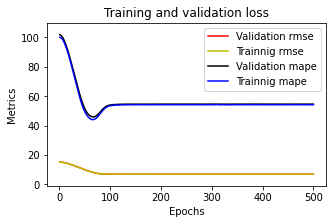

In [171]:
plotme(model2_1)

In [31]:
# inputs: distance + hour
model2_2 = nnmodel(5,10, num_hlayers=1,Epoch=1000)
model2_2

Epoch 1/1000
179/179 [==============================] - 1s 2ms/step - loss: 568550.6250 - distance_layer_loss: 0.4075 - traveltime_layer_loss: 812214.7500 - distance_layer_mape: 183711.4844 - distance_layer_rmse: 0.6383 - traveltime_layer_mape: 99.8671 - traveltime_layer_rmse: 901.2296 - val_loss: 575507.7500 - val_distance_layer_loss: 1.9273 - val_traveltime_layer_loss: 822152.8750 - val_distance_layer_mape: 1263.8612 - val_distance_layer_rmse: 1.3883 - val_traveltime_layer_mape: 99.5388 - val_traveltime_layer_rmse: 906.7264
Epoch 2/1000
179/179 [==============================] - 0s 1ms/step - loss: 557807.8125 - distance_layer_loss: 10.2823 - traveltime_layer_loss: 796864.0625 - distance_layer_mape: 314005.0938 - distance_layer_rmse: 3.2066 - traveltime_layer_mape: 98.2986 - traveltime_layer_rmse: 892.6724 - val_loss: 552735.1875 - val_distance_layer_loss: 25.0013 - val_traveltime_layer_loss: 789611.1875 - val_distance_layer_mape: 4233.1245 - val_distance_layer_rmse: 5.0001 - val_tra

179/179 [==============================] - 0s 1ms/step - loss: 119888.8203 - distance_layer_loss: 896.3378 - traveltime_layer_loss: 170885.6094 - distance_layer_mape: 3601669.2500 - distance_layer_rmse: 29.9389 - traveltime_layer_mape: 53.3884 - traveltime_layer_rmse: 413.3831 - val_loss: 124260.6875 - val_distance_layer_loss: 880.2914 - val_traveltime_layer_loss: 177138.0625 - val_distance_layer_mape: 24461.1543 - val_distance_layer_rmse: 29.6697 - val_traveltime_layer_mape: 51.6895 - val_traveltime_layer_rmse: 420.8777
Epoch 17/1000
179/179 [==============================] - 0s 1ms/step - loss: 119838.5156 - distance_layer_loss: 885.1815 - traveltime_layer_loss: 170818.5312 - distance_layer_mape: 3574713.0000 - distance_layer_rmse: 29.7520 - traveltime_layer_mape: 52.7109 - traveltime_layer_rmse: 413.3020 - val_loss: 124049.8516 - val_distance_layer_loss: 892.1038 - val_traveltime_layer_loss: 176831.7188 - val_distance_layer_mape: 24626.7285 - val_distance_layer_rmse: 29.8681 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 118983.6328 - distance_layer_loss: 856.2275 - traveltime_layer_loss: 169609.7500 - distance_layer_mape: 3668336.0000 - distance_layer_rmse: 29.2614 - traveltime_layer_mape: 53.2514 - traveltime_layer_rmse: 411.8370 - val_loss: 122948.2031 - val_distance_layer_loss: 847.6757 - val_traveltime_layer_loss: 175276.9688 - val_distance_layer_mape: 24050.9004 - val_distance_layer_rmse: 29.1149 - val_traveltime_layer_mape: 52.0673 - val_traveltime_layer_rmse: 418.6609
Epoch 32/1000
179/179 [==============================] - 0s 1ms/step - loss: 118946.2266 - distance_layer_loss: 849.4707 - traveltime_layer_loss: 169559.1250 - distance_layer_mape: 3676755.0000 - distance_layer_rmse: 29.1457 - traveltime_layer_mape: 52.9289 - traveltime_layer_rmse: 411.7756 - val_loss: 122840.8984 - val_distance_layer_loss: 848.4391 - val_traveltime_layer_loss: 175123.3594 - val_distance_layer_mape: 24064.3398 - val_distance_layer_rmse: 29.1280 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 118275.3906 - distance_layer_loss: 815.5061 - traveltime_layer_loss: 168615.3438 - distance_layer_mape: 3714065.5000 - distance_layer_rmse: 28.5571 - traveltime_layer_mape: 53.4159 - traveltime_layer_rmse: 410.6280 - val_loss: 122013.8438 - val_distance_layer_loss: 805.9120 - val_traveltime_layer_loss: 173960.1406 - val_distance_layer_mape: 23490.4551 - val_distance_layer_rmse: 28.3886 - val_traveltime_layer_mape: 52.0977 - val_traveltime_layer_rmse: 417.0853
Epoch 47/1000
179/179 [==============================] - 0s 1ms/step - loss: 118225.0312 - distance_layer_loss: 805.4058 - traveltime_layer_loss: 168547.7969 - distance_layer_mape: 3708852.0000 - distance_layer_rmse: 28.3797 - traveltime_layer_mape: 52.7926 - traveltime_layer_rmse: 410.5457 - val_loss: 121905.3203 - val_distance_layer_loss: 813.5759 - val_traveltime_layer_loss: 173801.7812 - val_distance_layer_mape: 23603.1035 - val_distance_layer_rmse: 28.5233 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 117775.5625 - distance_layer_loss: 770.9404 - traveltime_layer_loss: 167920.3906 - distance_layer_mape: 3750972.2500 - distance_layer_rmse: 27.7658 - traveltime_layer_mape: 53.2757 - traveltime_layer_rmse: 409.7809 - val_loss: 121281.7656 - val_distance_layer_loss: 768.5691 - val_traveltime_layer_loss: 172930.2656 - val_distance_layer_mape: 22970.7539 - val_distance_layer_rmse: 27.7231 - val_traveltime_layer_mape: 52.5228 - val_traveltime_layer_rmse: 415.8488
Epoch 62/1000
179/179 [==============================] - 0s 1ms/step - loss: 117755.1875 - distance_layer_loss: 768.6404 - traveltime_layer_loss: 167892.2344 - distance_layer_mape: 3753495.0000 - distance_layer_rmse: 27.7244 - traveltime_layer_mape: 53.2991 - traveltime_layer_rmse: 409.7466 - val_loss: 121233.1641 - val_distance_layer_loss: 768.4197 - val_traveltime_layer_loss: 172860.9375 - val_distance_layer_mape: 22970.0312 - val_distance_layer_rmse: 27.7204 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 117430.7578 - distance_layer_loss: 733.2054 - traveltime_layer_loss: 167443.9531 - distance_layer_mape: 3742754.0000 - distance_layer_rmse: 27.0778 - traveltime_layer_mape: 53.3647 - traveltime_layer_rmse: 409.1992 - val_loss: 120843.2266 - val_distance_layer_loss: 725.1932 - val_traveltime_layer_loss: 172322.3906 - val_distance_layer_mape: 22338.2109 - val_distance_layer_rmse: 26.9294 - val_traveltime_layer_mape: 52.0886 - val_traveltime_layer_rmse: 415.1173
Epoch 77/1000
179/179 [==============================] - 0s 1ms/step - loss: 117429.2812 - distance_layer_loss: 729.0208 - traveltime_layer_loss: 167443.6719 - distance_layer_mape: 3756220.2500 - distance_layer_rmse: 27.0004 - traveltime_layer_mape: 53.2129 - traveltime_layer_rmse: 409.1988 - val_loss: 120794.3906 - val_distance_layer_loss: 724.2301 - val_traveltime_layer_loss: 172253.0469 - val_distance_layer_mape: 22324.4336 - val_distance_layer_rmse: 26.9115 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 117191.6875 - distance_layer_loss: 700.5802 - traveltime_layer_loss: 167116.5156 - distance_layer_mape: 3768580.0000 - distance_layer_rmse: 26.4685 - traveltime_layer_mape: 53.5149 - traveltime_layer_rmse: 408.7989 - val_loss: 120564.1875 - val_distance_layer_loss: 687.8604 - val_traveltime_layer_loss: 171939.7656 - val_distance_layer_mape: 21774.4355 - val_distance_layer_rmse: 26.2271 - val_traveltime_layer_mape: 51.7458 - val_traveltime_layer_rmse: 414.6562
Epoch 92/1000
179/179 [==============================] - 0s 1ms/step - loss: 117196.7656 - distance_layer_loss: 693.5643 - traveltime_layer_loss: 167126.7500 - distance_layer_mape: 3710139.2500 - distance_layer_rmse: 26.3356 - traveltime_layer_mape: 53.0551 - traveltime_layer_rmse: 408.8114 - val_loss: 120433.8672 - val_distance_layer_loss: 692.5740 - val_traveltime_layer_loss: 171751.5625 - val_distance_layer_mape: 21849.0996 - val_distance_layer_rmse: 26.3168 - val_t

179/179 [==============================] - 0s 1ms/step - loss: 117027.1797 - distance_layer_loss: 667.4120 - traveltime_layer_loss: 166895.6250 - distance_layer_mape: 3723662.7500 - distance_layer_rmse: 25.8343 - traveltime_layer_mape: 53.2363 - traveltime_layer_rmse: 408.5286 - val_loss: 120164.1641 - val_distance_layer_loss: 668.7563 - val_traveltime_layer_loss: 171376.4531 - val_distance_layer_mape: 21482.6523 - val_distance_layer_rmse: 25.8603 - val_traveltime_layer_mape: 52.7824 - val_traveltime_layer_rmse: 413.9764
Epoch 107/1000
179/179 [==============================] - 0s 1ms/step - loss: 116967.5781 - distance_layer_loss: 670.3529 - traveltime_layer_loss: 166809.2344 - distance_layer_mape: 3720724.7500 - distance_layer_rmse: 25.8912 - traveltime_layer_mape: 53.7035 - traveltime_layer_rmse: 408.4229 - val_loss: 120225.3438 - val_distance_layer_loss: 659.9331 - val_traveltime_layer_loss: 171467.7031 - val_distance_layer_mape: 21342.4336 - val_distance_layer_rmse: 25.6892 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116875.7031 - distance_layer_loss: 645.0788 - traveltime_layer_loss: 166688.7344 - distance_layer_mape: 3700990.5000 - distance_layer_rmse: 25.3984 - traveltime_layer_mape: 53.6451 - traveltime_layer_rmse: 408.2753 - val_loss: 120070.5234 - val_distance_layer_loss: 635.2583 - val_traveltime_layer_loss: 171257.0938 - val_distance_layer_mape: 20949.4121 - val_distance_layer_rmse: 25.2043 - val_traveltime_layer_mape: 52.0229 - val_traveltime_layer_rmse: 413.8322
Epoch 122/1000
179/179 [==============================] - 0s 1ms/step - loss: 116856.3047 - distance_layer_loss: 642.7382 - traveltime_layer_loss: 166662.1719 - distance_layer_mape: 3666759.2500 - distance_layer_rmse: 25.3523 - traveltime_layer_mape: 53.5833 - traveltime_layer_rmse: 408.2428 - val_loss: 120159.1250 - val_distance_layer_loss: 629.6127 - val_traveltime_layer_loss: 171386.0938 - val_distance_layer_mape: 20857.3887 - val_distance_layer_rmse: 25.0921 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116788.7188 - distance_layer_loss: 621.5457 - traveltime_layer_loss: 166574.6406 - distance_layer_mape: 3677310.0000 - distance_layer_rmse: 24.9308 - traveltime_layer_mape: 53.5069 - traveltime_layer_rmse: 408.1356 - val_loss: 119925.6484 - val_distance_layer_loss: 614.4879 - val_traveltime_layer_loss: 171058.9844 - val_distance_layer_mape: 20611.3984 - val_distance_layer_rmse: 24.7889 - val_traveltime_layer_mape: 52.1230 - val_traveltime_layer_rmse: 413.5928
Epoch 137/1000
179/179 [==============================] - 0s 1ms/step - loss: 116787.4219 - distance_layer_loss: 617.3255 - traveltime_layer_loss: 166574.6406 - distance_layer_mape: 3647934.5000 - distance_layer_rmse: 24.8460 - traveltime_layer_mape: 53.2122 - traveltime_layer_rmse: 408.1356 - val_loss: 119837.3750 - val_distance_layer_loss: 620.2019 - val_traveltime_layer_loss: 170930.4219 - val_distance_layer_mape: 20706.1426 - val_distance_layer_rmse: 24.9039 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116744.2812 - distance_layer_loss: 603.0682 - traveltime_layer_loss: 166519.1094 - distance_layer_mape: 3633531.2500 - distance_layer_rmse: 24.5574 - traveltime_layer_mape: 53.5673 - traveltime_layer_rmse: 408.0675 - val_loss: 119772.5312 - val_distance_layer_loss: 600.1534 - val_traveltime_layer_loss: 170846.3750 - val_distance_layer_mape: 20373.9434 - val_distance_layer_rmse: 24.4980 - val_traveltime_layer_mape: 52.5774 - val_traveltime_layer_rmse: 413.3357
Epoch 152/1000
179/179 [==============================] - 0s 1ms/step - loss: 116712.9141 - distance_layer_loss: 601.2890 - traveltime_layer_loss: 166475.0781 - distance_layer_mape: 3636314.5000 - distance_layer_rmse: 24.5212 - traveltime_layer_mape: 53.4997 - traveltime_layer_rmse: 408.0136 - val_loss: 119755.3281 - val_distance_layer_loss: 600.2574 - val_traveltime_layer_loss: 170821.7812 - val_distance_layer_mape: 20375.7285 - val_distance_layer_rmse: 24.5002 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116602.0234 - distance_layer_loss: 591.1582 - traveltime_layer_loss: 166320.9688 - distance_layer_mape: 3639075.7500 - distance_layer_rmse: 24.3137 - traveltime_layer_mape: 54.0118 - traveltime_layer_rmse: 407.8247 - val_loss: 119902.7734 - val_distance_layer_loss: 574.7715 - val_traveltime_layer_loss: 171043.4219 - val_distance_layer_mape: 19943.5137 - val_distance_layer_rmse: 23.9744 - val_traveltime_layer_mape: 51.5640 - val_traveltime_layer_rmse: 413.5740
Epoch 167/1000
179/179 [==============================] - 0s 1ms/step - loss: 116692.7422 - distance_layer_loss: 582.5383 - traveltime_layer_loss: 166454.3281 - distance_layer_mape: 3617942.7500 - distance_layer_rmse: 24.1358 - traveltime_layer_mape: 53.1979 - traveltime_layer_rmse: 407.9882 - val_loss: 119728.9688 - val_distance_layer_loss: 581.3052 - val_traveltime_layer_loss: 170792.2969 - val_distance_layer_mape: 20055.3926 - val_distance_layer_rmse: 24.1103 - val_

179/179 [==============================] - 0s 998us/step - loss: 116641.1172 - distance_layer_loss: 570.2011 - traveltime_layer_loss: 166385.8281 - distance_layer_mape: 3614073.0000 - distance_layer_rmse: 23.8789 - traveltime_layer_mape: 53.2789 - traveltime_layer_rmse: 407.9042 - val_loss: 119642.6719 - val_distance_layer_loss: 575.0543 - val_traveltime_layer_loss: 170671.6250 - val_distance_layer_mape: 19948.1621 - val_distance_layer_rmse: 23.9803 - val_traveltime_layer_mape: 53.1404 - val_traveltime_layer_rmse: 413.1242
Epoch 182/1000
179/179 [==============================] - 0s 1ms/step - loss: 116627.1797 - distance_layer_loss: 574.0466 - traveltime_layer_loss: 166364.2344 - distance_layer_mape: 3591056.2500 - distance_layer_rmse: 23.9593 - traveltime_layer_mape: 53.8293 - traveltime_layer_rmse: 407.8777 - val_loss: 119787.9375 - val_distance_layer_loss: 562.4401 - val_traveltime_layer_loss: 170884.5625 - val_distance_layer_mape: 19730.3047 - val_distance_layer_rmse: 23.7158 - va

179/179 [==============================] - 0s 1ms/step - loss: 116577.5859 - distance_layer_loss: 559.2518 - traveltime_layer_loss: 166299.7812 - distance_layer_mape: 3565343.2500 - distance_layer_rmse: 23.6485 - traveltime_layer_mape: 53.4691 - traveltime_layer_rmse: 407.7987 - val_loss: 119658.5156 - val_distance_layer_loss: 555.8326 - val_traveltime_layer_loss: 170702.5312 - val_distance_layer_mape: 19614.3750 - val_distance_layer_rmse: 23.5761 - val_traveltime_layer_mape: 52.3866 - val_traveltime_layer_rmse: 413.1616
Epoch 197/1000
179/179 [==============================] - 0s 1ms/step - loss: 116594.8828 - distance_layer_loss: 560.0633 - traveltime_layer_loss: 166324.0469 - distance_layer_mape: 3568722.2500 - distance_layer_rmse: 23.6657 - traveltime_layer_mape: 53.6606 - traveltime_layer_rmse: 407.8285 - val_loss: 119672.4453 - val_distance_layer_loss: 554.0145 - val_traveltime_layer_loss: 170723.2031 - val_distance_layer_mape: 19582.3887 - val_distance_layer_rmse: 23.5375 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116589.4688 - distance_layer_loss: 549.5118 - traveltime_layer_loss: 166320.8750 - distance_layer_mape: 3550561.7500 - distance_layer_rmse: 23.4417 - traveltime_layer_mape: 53.6815 - traveltime_layer_rmse: 407.8246 - val_loss: 119592.2969 - val_distance_layer_loss: 550.5745 - val_traveltime_layer_loss: 170610.1719 - val_distance_layer_mape: 19520.9375 - val_distance_layer_rmse: 23.4643 - val_traveltime_layer_mape: 53.0818 - val_traveltime_layer_rmse: 413.0498
Epoch 212/1000
179/179 [==============================] - 0s 1ms/step - loss: 116534.8281 - distance_layer_loss: 547.3621 - traveltime_layer_loss: 166243.7188 - distance_layer_mape: 3515382.2500 - distance_layer_rmse: 23.3958 - traveltime_layer_mape: 53.4741 - traveltime_layer_rmse: 407.7299 - val_loss: 119638.3203 - val_distance_layer_loss: 543.8322 - val_traveltime_layer_loss: 170678.8125 - val_distance_layer_mape: 19402.0469 - val_distance_layer_rmse: 23.3202 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116538.1406 - distance_layer_loss: 537.6148 - traveltime_layer_loss: 166252.6719 - distance_layer_mape: 3511081.2500 - distance_layer_rmse: 23.1865 - traveltime_layer_mape: 53.4465 - traveltime_layer_rmse: 407.7409 - val_loss: 119672.0234 - val_distance_layer_loss: 531.9997 - val_traveltime_layer_loss: 170732.1406 - val_distance_layer_mape: 19190.3027 - val_distance_layer_rmse: 23.0651 - val_traveltime_layer_mape: 52.0855 - val_traveltime_layer_rmse: 413.1974
Epoch 227/1000
179/179 [==============================] - 0s 1ms/step - loss: 116570.6484 - distance_layer_loss: 537.9078 - traveltime_layer_loss: 166298.9688 - distance_layer_mape: 3495938.7500 - distance_layer_rmse: 23.1928 - traveltime_layer_mape: 53.5403 - traveltime_layer_rmse: 407.7977 - val_loss: 119673.5547 - val_distance_layer_loss: 531.2974 - val_traveltime_layer_loss: 170734.5312 - val_distance_layer_mape: 19177.5430 - val_distance_layer_rmse: 23.0499 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116504.6484 - distance_layer_loss: 530.1046 - traveltime_layer_loss: 166208.0625 - distance_layer_mape: 3470033.5000 - distance_layer_rmse: 23.0240 - traveltime_layer_mape: 53.6295 - traveltime_layer_rmse: 407.6862 - val_loss: 119684.7891 - val_distance_layer_loss: 522.3608 - val_traveltime_layer_loss: 170754.4375 - val_distance_layer_mape: 19015.5527 - val_distance_layer_rmse: 22.8552 - val_traveltime_layer_mape: 51.9964 - val_traveltime_layer_rmse: 413.2244
Epoch 242/1000
179/179 [==============================] - 0s 1ms/step - loss: 116501.1562 - distance_layer_loss: 530.0866 - traveltime_layer_loss: 166202.9688 - distance_layer_mape: 3505158.5000 - distance_layer_rmse: 23.0236 - traveltime_layer_mape: 53.6856 - traveltime_layer_rmse: 407.6800 - val_loss: 119776.1797 - val_distance_layer_loss: 518.6642 - val_traveltime_layer_loss: 170886.5312 - val_distance_layer_mape: 18948.6309 - val_distance_layer_rmse: 22.7742 - val_

179/179 [==============================] - 0s 999us/step - loss: 116502.6250 - distance_layer_loss: 520.6416 - traveltime_layer_loss: 166209.1562 - distance_layer_mape: 3458539.5000 - distance_layer_rmse: 22.8176 - traveltime_layer_mape: 53.4964 - traveltime_layer_rmse: 407.6876 - val_loss: 119625.6172 - val_distance_layer_loss: 516.6576 - val_traveltime_layer_loss: 170672.2656 - val_distance_layer_mape: 18910.2949 - val_distance_layer_rmse: 22.7301 - val_traveltime_layer_mape: 52.3095 - val_traveltime_layer_rmse: 413.1250
Epoch 257/1000
179/179 [==============================] - 0s 1ms/step - loss: 116515.9922 - distance_layer_loss: 521.1708 - traveltime_layer_loss: 166228.0469 - distance_layer_mape: 3437679.2500 - distance_layer_rmse: 22.8292 - traveltime_layer_mape: 53.5986 - traveltime_layer_rmse: 407.7108 - val_loss: 119585.2422 - val_distance_layer_loss: 519.8616 - val_traveltime_layer_loss: 170613.2500 - val_distance_layer_mape: 18968.1582 - val_distance_layer_rmse: 22.8005 - va

179/179 [==============================] - 0s 1ms/step - loss: 116445.3359 - distance_layer_loss: 510.1822 - traveltime_layer_loss: 166131.8750 - distance_layer_mape: 3444011.7500 - distance_layer_rmse: 22.5872 - traveltime_layer_mape: 53.1746 - traveltime_layer_rmse: 407.5928 - val_loss: 119575.5859 - val_distance_layer_loss: 515.2570 - val_traveltime_layer_loss: 170601.4844 - val_distance_layer_mape: 18882.9004 - val_distance_layer_rmse: 22.6993 - val_traveltime_layer_mape: 53.0911 - val_traveltime_layer_rmse: 413.0393
Epoch 272/1000
179/179 [==============================] - 0s 1ms/step - loss: 116496.0078 - distance_layer_loss: 514.3331 - traveltime_layer_loss: 166202.4531 - distance_layer_mape: 3435524.7500 - distance_layer_rmse: 22.6789 - traveltime_layer_mape: 53.7491 - traveltime_layer_rmse: 407.6794 - val_loss: 119642.4766 - val_distance_layer_loss: 507.7286 - val_traveltime_layer_loss: 170700.2031 - val_distance_layer_mape: 18745.6426 - val_distance_layer_rmse: 22.5328 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116438.7500 - distance_layer_loss: 504.4867 - traveltime_layer_loss: 166124.8281 - distance_layer_mape: 3408375.5000 - distance_layer_rmse: 22.4608 - traveltime_layer_mape: 53.3683 - traveltime_layer_rmse: 407.5841 - val_loss: 119578.7656 - val_distance_layer_loss: 508.0298 - val_traveltime_layer_loss: 170609.0625 - val_distance_layer_mape: 18749.0781 - val_distance_layer_rmse: 22.5395 - val_traveltime_layer_mape: 53.1254 - val_traveltime_layer_rmse: 413.0485
Epoch 287/1000
179/179 [==============================] - 0s 1ms/step - loss: 116455.0938 - distance_layer_loss: 506.5179 - traveltime_layer_loss: 166147.3594 - distance_layer_mape: 3392372.2500 - distance_layer_rmse: 22.5060 - traveltime_layer_mape: 53.7154 - traveltime_layer_rmse: 407.6118 - val_loss: 119651.1562 - val_distance_layer_loss: 499.8929 - val_traveltime_layer_loss: 170715.9531 - val_distance_layer_mape: 18599.9023 - val_distance_layer_rmse: 22.3583 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116425.6094 - distance_layer_loss: 500.7745 - traveltime_layer_loss: 166107.6406 - distance_layer_mape: 3403739.7500 - distance_layer_rmse: 22.3780 - traveltime_layer_mape: 53.7932 - traveltime_layer_rmse: 407.5630 - val_loss: 119681.2109 - val_distance_layer_loss: 492.3065 - val_traveltime_layer_loss: 170762.1562 - val_distance_layer_mape: 18457.4668 - val_distance_layer_rmse: 22.1880 - val_traveltime_layer_mape: 52.0391 - val_traveltime_layer_rmse: 413.2338
Epoch 302/1000
179/179 [==============================] - 0s 1ms/step - loss: 116493.7422 - distance_layer_loss: 496.6925 - traveltime_layer_loss: 166206.7656 - distance_layer_mape: 3413604.0000 - distance_layer_rmse: 22.2866 - traveltime_layer_mape: 53.3668 - traveltime_layer_rmse: 407.6846 - val_loss: 119631.2422 - val_distance_layer_loss: 494.2636 - val_traveltime_layer_loss: 170689.9375 - val_distance_layer_mape: 18493.6270 - val_distance_layer_rmse: 22.2320 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116458.8203 - distance_layer_loss: 492.9266 - traveltime_layer_loss: 166158.4844 - distance_layer_mape: 3363217.0000 - distance_layer_rmse: 22.2020 - traveltime_layer_mape: 53.6457 - traveltime_layer_rmse: 407.6254 - val_loss: 119610.6719 - val_distance_layer_loss: 490.3605 - val_traveltime_layer_loss: 170662.1875 - val_distance_layer_mape: 18419.3320 - val_distance_layer_rmse: 22.1441 - val_traveltime_layer_mape: 52.6130 - val_traveltime_layer_rmse: 413.1128
Epoch 317/1000
179/179 [==============================] - 0s 1ms/step - loss: 116433.6328 - distance_layer_loss: 491.3393 - traveltime_layer_loss: 166123.2031 - distance_layer_mape: 3368007.2500 - distance_layer_rmse: 22.1662 - traveltime_layer_mape: 53.4995 - traveltime_layer_rmse: 407.5822 - val_loss: 119627.2891 - val_distance_layer_loss: 488.6997 - val_traveltime_layer_loss: 170686.6875 - val_distance_layer_mape: 18388.3301 - val_distance_layer_rmse: 22.1066 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116474.4531 - distance_layer_loss: 484.1887 - traveltime_layer_loss: 166184.5938 - distance_layer_mape: 3341369.2500 - distance_layer_rmse: 22.0043 - traveltime_layer_mape: 53.3617 - traveltime_layer_rmse: 407.6574 - val_loss: 119700.4141 - val_distance_layer_loss: 479.1891 - val_traveltime_layer_loss: 170795.2031 - val_distance_layer_mape: 18208.3828 - val_distance_layer_rmse: 21.8904 - val_traveltime_layer_mape: 52.0110 - val_traveltime_layer_rmse: 413.2738
Epoch 332/1000
179/179 [==============================] - 0s 1ms/step - loss: 116425.4531 - distance_layer_loss: 485.6065 - traveltime_layer_loss: 166114.0156 - distance_layer_mape: 3352836.2500 - distance_layer_rmse: 22.0365 - traveltime_layer_mape: 53.5956 - traveltime_layer_rmse: 407.5709 - val_loss: 119696.7578 - val_distance_layer_loss: 478.9999 - val_traveltime_layer_loss: 170790.0938 - val_distance_layer_mape: 18204.7324 - val_distance_layer_rmse: 21.8861 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116424.1016 - distance_layer_loss: 478.5681 - traveltime_layer_loss: 166115.0469 - distance_layer_mape: 3288575.0000 - distance_layer_rmse: 21.8762 - traveltime_layer_mape: 53.3974 - traveltime_layer_rmse: 407.5721 - val_loss: 119607.1484 - val_distance_layer_loss: 480.4564 - val_traveltime_layer_loss: 170661.4375 - val_distance_layer_mape: 18230.1133 - val_distance_layer_rmse: 21.9193 - val_traveltime_layer_mape: 52.9433 - val_traveltime_layer_rmse: 413.1119
Epoch 347/1000
179/179 [==============================] - 0s 1ms/step - loss: 116441.2109 - distance_layer_loss: 477.9095 - traveltime_layer_loss: 166139.7656 - distance_layer_mape: 3293495.7500 - distance_layer_rmse: 21.8611 - traveltime_layer_mape: 53.3483 - traveltime_layer_rmse: 407.6024 - val_loss: 119612.3203 - val_distance_layer_loss: 482.0620 - val_traveltime_layer_loss: 170668.1562 - val_distance_layer_mape: 18260.3906 - val_distance_layer_rmse: 21.9559 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116440.9375 - distance_layer_loss: 473.9622 - traveltime_layer_loss: 166141.0625 - distance_layer_mape: 3313043.2500 - distance_layer_rmse: 21.7707 - traveltime_layer_mape: 53.5464 - traveltime_layer_rmse: 407.6041 - val_loss: 119620.8438 - val_distance_layer_loss: 474.0268 - val_traveltime_layer_loss: 170683.7812 - val_distance_layer_mape: 18107.3418 - val_distance_layer_rmse: 21.7722 - val_traveltime_layer_mape: 52.8490 - val_traveltime_layer_rmse: 413.1389
Epoch 362/1000
179/179 [==============================] - 0s 1ms/step - loss: 116406.6719 - distance_layer_loss: 471.8323 - traveltime_layer_loss: 166092.9844 - distance_layer_mape: 3306958.2500 - distance_layer_rmse: 21.7217 - traveltime_layer_mape: 53.3331 - traveltime_layer_rmse: 407.5451 - val_loss: 119622.0938 - val_distance_layer_loss: 473.2546 - val_traveltime_layer_loss: 170685.9062 - val_distance_layer_mape: 18092.4941 - val_distance_layer_rmse: 21.7544 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116400.0781 - distance_layer_loss: 467.5892 - traveltime_layer_loss: 166085.4219 - distance_layer_mape: 3305913.0000 - distance_layer_rmse: 21.6238 - traveltime_layer_mape: 53.4282 - traveltime_layer_rmse: 407.5358 - val_loss: 119627.3047 - val_distance_layer_loss: 471.0963 - val_traveltime_layer_loss: 170694.2188 - val_distance_layer_mape: 18050.1426 - val_distance_layer_rmse: 21.7048 - val_traveltime_layer_mape: 53.1839 - val_traveltime_layer_rmse: 413.1516
Epoch 377/1000
179/179 [==============================] - 0s 1ms/step - loss: 116356.7578 - distance_layer_loss: 470.7794 - traveltime_layer_loss: 166022.1562 - distance_layer_mape: 3265316.5000 - distance_layer_rmse: 21.6975 - traveltime_layer_mape: 53.8832 - traveltime_layer_rmse: 407.4582 - val_loss: 119811.8984 - val_distance_layer_loss: 458.8027 - val_traveltime_layer_loss: 170963.2500 - val_distance_layer_mape: 17815.0703 - val_distance_layer_rmse: 21.4197 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116401.6562 - distance_layer_loss: 462.5475 - traveltime_layer_loss: 166089.7969 - distance_layer_mape: 3271011.2500 - distance_layer_rmse: 21.5069 - traveltime_layer_mape: 53.4426 - traveltime_layer_rmse: 407.5412 - val_loss: 119647.8438 - val_distance_layer_loss: 462.3214 - val_traveltime_layer_loss: 170727.3594 - val_distance_layer_mape: 17881.2422 - val_distance_layer_rmse: 21.5017 - val_traveltime_layer_mape: 52.6855 - val_traveltime_layer_rmse: 413.1917
Epoch 392/1000
179/179 [==============================] - 0s 1ms/step - loss: 116408.2578 - distance_layer_loss: 463.4311 - traveltime_layer_loss: 166098.8594 - distance_layer_mape: 3261742.2500 - distance_layer_rmse: 21.5275 - traveltime_layer_mape: 53.5991 - traveltime_layer_rmse: 407.5523 - val_loss: 119674.0625 - val_distance_layer_loss: 459.7613 - val_traveltime_layer_loss: 170765.8906 - val_distance_layer_mape: 17831.9629 - val_distance_layer_rmse: 21.4420 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116344.7031 - distance_layer_loss: 455.5752 - traveltime_layer_loss: 166011.4531 - distance_layer_mape: 3258861.0000 - distance_layer_rmse: 21.3442 - traveltime_layer_mape: 53.1685 - traveltime_layer_rmse: 407.4450 - val_loss: 119655.9609 - val_distance_layer_loss: 462.8508 - val_traveltime_layer_loss: 170738.6875 - val_distance_layer_mape: 17889.7031 - val_distance_layer_rmse: 21.5140 - val_traveltime_layer_mape: 53.4419 - val_traveltime_layer_rmse: 413.2054
Epoch 407/1000
179/179 [==============================] - 0s 1ms/step - loss: 116403.8125 - distance_layer_loss: 459.9288 - traveltime_layer_loss: 166094.1094 - distance_layer_mape: 3251195.2500 - distance_layer_rmse: 21.4460 - traveltime_layer_mape: 53.8125 - traveltime_layer_rmse: 407.5464 - val_loss: 119733.4688 - val_distance_layer_loss: 452.0545 - val_traveltime_layer_loss: 170854.0625 - val_distance_layer_mape: 17681.8066 - val_distance_layer_rmse: 21.2616 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116398.0234 - distance_layer_loss: 450.7634 - traveltime_layer_loss: 166089.5938 - distance_layer_mape: 3226071.5000 - distance_layer_rmse: 21.2312 - traveltime_layer_mape: 53.1630 - traveltime_layer_rmse: 407.5409 - val_loss: 119655.7031 - val_distance_layer_loss: 454.3843 - val_traveltime_layer_loss: 170741.9531 - val_distance_layer_mape: 17725.6934 - val_distance_layer_rmse: 21.3163 - val_traveltime_layer_mape: 52.9379 - val_traveltime_layer_rmse: 413.2093
Epoch 422/1000
179/179 [==============================] - 0s 1ms/step - loss: 116377.5469 - distance_layer_loss: 456.1536 - traveltime_layer_loss: 166058.1094 - distance_layer_mape: 3245338.2500 - distance_layer_rmse: 21.3578 - traveltime_layer_mape: 53.9061 - traveltime_layer_rmse: 407.5023 - val_loss: 119867.7969 - val_distance_layer_loss: 443.3325 - val_traveltime_layer_loss: 171049.6875 - val_distance_layer_mape: 17510.7969 - val_distance_layer_rmse: 21.0555 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116379.3125 - distance_layer_loss: 449.8494 - traveltime_layer_loss: 166063.4219 - distance_layer_mape: 3202518.5000 - distance_layer_rmse: 21.2097 - traveltime_layer_mape: 53.6054 - traveltime_layer_rmse: 407.5088 - val_loss: 119725.1719 - val_distance_layer_loss: 444.4499 - val_traveltime_layer_loss: 170845.4688 - val_distance_layer_mape: 17531.2441 - val_distance_layer_rmse: 21.0820 - val_traveltime_layer_mape: 52.1928 - val_traveltime_layer_rmse: 413.3346
Epoch 437/1000
179/179 [==============================] - 0s 1ms/step - loss: 116395.6016 - distance_layer_loss: 448.8398 - traveltime_layer_loss: 166087.1719 - distance_layer_mape: 3200264.5000 - distance_layer_rmse: 21.1858 - traveltime_layer_mape: 53.5363 - traveltime_layer_rmse: 407.5379 - val_loss: 119712.2500 - val_distance_layer_loss: 444.6908 - val_traveltime_layer_loss: 170826.8906 - val_distance_layer_mape: 17535.9766 - val_distance_layer_rmse: 21.0877 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116371.8125 - distance_layer_loss: 441.4198 - traveltime_layer_loss: 166056.2188 - distance_layer_mape: 3176283.7500 - distance_layer_rmse: 21.0100 - traveltime_layer_mape: 53.0788 - traveltime_layer_rmse: 407.5000 - val_loss: 119669.6406 - val_distance_layer_loss: 445.5196 - val_traveltime_layer_loss: 170765.6562 - val_distance_layer_mape: 17550.9785 - val_distance_layer_rmse: 21.1073 - val_traveltime_layer_mape: 52.9452 - val_traveltime_layer_rmse: 413.2380
Epoch 452/1000
179/179 [==============================] - 0s 1ms/step - loss: 116408.8281 - distance_layer_loss: 444.9034 - traveltime_layer_loss: 166107.7031 - distance_layer_mape: 3193909.2500 - distance_layer_rmse: 21.0927 - traveltime_layer_mape: 53.5988 - traveltime_layer_rmse: 407.5631 - val_loss: 119695.4688 - val_distance_layer_loss: 442.0765 - val_traveltime_layer_loss: 170804.1250 - val_distance_layer_mape: 17483.5938 - val_distance_layer_rmse: 21.0256 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116382.9062 - distance_layer_loss: 438.8383 - traveltime_layer_loss: 166073.2344 - distance_layer_mape: 3180684.2500 - distance_layer_rmse: 20.9485 - traveltime_layer_mape: 53.3178 - traveltime_layer_rmse: 407.5208 - val_loss: 119696.1797 - val_distance_layer_loss: 438.7602 - val_traveltime_layer_loss: 170806.5312 - val_distance_layer_mape: 17417.5000 - val_distance_layer_rmse: 20.9466 - val_traveltime_layer_mape: 52.5798 - val_traveltime_layer_rmse: 413.2875
Epoch 467/1000
179/179 [==============================] - 0s 1ms/step - loss: 116358.0312 - distance_layer_loss: 443.2838 - traveltime_layer_loss: 166035.8125 - distance_layer_mape: 3190707.5000 - distance_layer_rmse: 21.0543 - traveltime_layer_mape: 53.9294 - traveltime_layer_rmse: 407.4749 - val_loss: 119863.9375 - val_distance_layer_loss: 431.3109 - val_traveltime_layer_loss: 171049.3125 - val_distance_layer_mape: 17270.3262 - val_distance_layer_rmse: 20.7680 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116416.2578 - distance_layer_loss: 436.2279 - traveltime_layer_loss: 166121.9531 - distance_layer_mape: 3185533.0000 - distance_layer_rmse: 20.8861 - traveltime_layer_mape: 53.5158 - traveltime_layer_rmse: 407.5806 - val_loss: 119736.6016 - val_distance_layer_loss: 432.2968 - val_traveltime_layer_loss: 170866.9531 - val_distance_layer_mape: 17288.9277 - val_distance_layer_rmse: 20.7917 - val_traveltime_layer_mape: 52.2718 - val_traveltime_layer_rmse: 413.3606
Epoch 482/1000
179/179 [==============================] - 0s 1ms/step - loss: 116395.6172 - distance_layer_loss: 435.2196 - traveltime_layer_loss: 166092.9062 - distance_layer_mape: 3167754.0000 - distance_layer_rmse: 20.8619 - traveltime_layer_mape: 53.4333 - traveltime_layer_rmse: 407.5450 - val_loss: 119823.8203 - val_distance_layer_loss: 428.6107 - val_traveltime_layer_loss: 170993.1719 - val_distance_layer_mape: 17215.5664 - val_distance_layer_rmse: 20.7029 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116359.6406 - distance_layer_loss: 431.6300 - traveltime_layer_loss: 166043.0938 - distance_layer_mape: 3148153.5000 - distance_layer_rmse: 20.7757 - traveltime_layer_mape: 53.4209 - traveltime_layer_rmse: 407.4839 - val_loss: 119691.2500 - val_distance_layer_loss: 434.2235 - val_traveltime_layer_loss: 170801.4062 - val_distance_layer_mape: 17325.9102 - val_distance_layer_rmse: 20.8380 - val_traveltime_layer_mape: 53.0855 - val_traveltime_layer_rmse: 413.2813
Epoch 497/1000
179/179 [==============================] - 0s 1ms/step - loss: 116386.3906 - distance_layer_loss: 431.5760 - traveltime_layer_loss: 166081.3906 - distance_layer_mape: 3139948.7500 - distance_layer_rmse: 20.7744 - traveltime_layer_mape: 53.4538 - traveltime_layer_rmse: 407.5309 - val_loss: 119698.4141 - val_distance_layer_loss: 431.9456 - val_traveltime_layer_loss: 170812.6562 - val_distance_layer_mape: 17280.8711 - val_distance_layer_rmse: 20.7833 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116382.2422 - distance_layer_loss: 425.2579 - traveltime_layer_loss: 166078.0938 - distance_layer_mape: 3113873.2500 - distance_layer_rmse: 20.6218 - traveltime_layer_mape: 53.0399 - traveltime_layer_rmse: 407.5268 - val_loss: 119721.6016 - val_distance_layer_loss: 426.5563 - val_traveltime_layer_loss: 170848.1094 - val_distance_layer_mape: 17172.7129 - val_distance_layer_rmse: 20.6532 - val_traveltime_layer_mape: 52.5301 - val_traveltime_layer_rmse: 413.3378
Epoch 512/1000
179/179 [==============================] - 0s 1ms/step - loss: 116359.9297 - distance_layer_loss: 427.2292 - traveltime_layer_loss: 166045.3906 - distance_layer_mape: 3139549.0000 - distance_layer_rmse: 20.6695 - traveltime_layer_mape: 53.3584 - traveltime_layer_rmse: 407.4867 - val_loss: 119711.9609 - val_distance_layer_loss: 426.8374 - val_traveltime_layer_loss: 170834.1719 - val_distance_layer_mape: 17178.2930 - val_distance_layer_rmse: 20.6600 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116387.4141 - distance_layer_loss: 424.8028 - traveltime_layer_loss: 166085.6719 - distance_layer_mape: 3132983.2500 - distance_layer_rmse: 20.6107 - traveltime_layer_mape: 53.5349 - traveltime_layer_rmse: 407.5361 - val_loss: 119724.6328 - val_distance_layer_loss: 422.8272 - val_traveltime_layer_loss: 170853.9844 - val_distance_layer_mape: 17097.4609 - val_distance_layer_rmse: 20.5628 - val_traveltime_layer_mape: 52.5478 - val_traveltime_layer_rmse: 413.3449
Epoch 527/1000
179/179 [==============================] - 0s 1ms/step - loss: 116405.0312 - distance_layer_loss: 422.2349 - traveltime_layer_loss: 166111.8906 - distance_layer_mape: 3120435.5000 - distance_layer_rmse: 20.5484 - traveltime_layer_mape: 53.1934 - traveltime_layer_rmse: 407.5683 - val_loss: 119710.7344 - val_distance_layer_loss: 427.7595 - val_traveltime_layer_loss: 170832.0781 - val_distance_layer_mape: 17195.8672 - val_distance_layer_rmse: 20.6823 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116385.8672 - distance_layer_loss: 420.6359 - traveltime_layer_loss: 166085.2656 - distance_layer_mape: 3101094.7500 - distance_layer_rmse: 20.5094 - traveltime_layer_mape: 53.4330 - traveltime_layer_rmse: 407.5356 - val_loss: 119712.5625 - val_distance_layer_loss: 423.2091 - val_traveltime_layer_loss: 170836.5938 - val_distance_layer_mape: 17104.2422 - val_distance_layer_rmse: 20.5720 - val_traveltime_layer_mape: 53.0927 - val_traveltime_layer_rmse: 413.3238
Epoch 542/1000
179/179 [==============================] - 0s 1ms/step - loss: 116335.9922 - distance_layer_loss: 422.8341 - traveltime_layer_loss: 166012.9844 - distance_layer_mape: 3109011.2500 - distance_layer_rmse: 20.5629 - traveltime_layer_mape: 53.7949 - traveltime_layer_rmse: 407.4469 - val_loss: 119839.0859 - val_distance_layer_loss: 414.0435 - val_traveltime_layer_loss: 171021.2188 - val_distance_layer_mape: 16919.7734 - val_distance_layer_rmse: 20.3481 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116386.7656 - distance_layer_loss: 416.7708 - traveltime_layer_loss: 166088.2500 - distance_layer_mape: 3088434.5000 - distance_layer_rmse: 20.4150 - traveltime_layer_mape: 53.3851 - traveltime_layer_rmse: 407.5393 - val_loss: 119791.6875 - val_distance_layer_loss: 412.6991 - val_traveltime_layer_loss: 170954.0938 - val_distance_layer_mape: 16891.7363 - val_distance_layer_rmse: 20.3150 - val_traveltime_layer_mape: 52.1045 - val_traveltime_layer_rmse: 413.4659
Epoch 557/1000
179/179 [==============================] - 0s 966us/step - loss: 116382.3359 - distance_layer_loss: 417.7198 - traveltime_layer_loss: 166081.5469 - distance_layer_mape: 3093521.5000 - distance_layer_rmse: 20.4382 - traveltime_layer_mape: 53.5525 - traveltime_layer_rmse: 407.5310 - val_loss: 119756.6172 - val_distance_layer_loss: 414.3360 - val_traveltime_layer_loss: 170903.2656 - val_distance_layer_mape: 16924.8887 - val_distance_layer_rmse: 20.3552 - va

179/179 [==============================] - 0s 1ms/step - loss: 116366.9297 - distance_layer_loss: 412.9757 - traveltime_layer_loss: 166061.4844 - distance_layer_mape: 3085502.5000 - distance_layer_rmse: 20.3218 - traveltime_layer_mape: 53.3350 - traveltime_layer_rmse: 407.5064 - val_loss: 119722.4531 - val_distance_layer_loss: 416.5626 - val_traveltime_layer_loss: 170853.5312 - val_distance_layer_mape: 16969.2324 - val_distance_layer_rmse: 20.4099 - val_traveltime_layer_mape: 53.1354 - val_traveltime_layer_rmse: 413.3443
Epoch 572/1000
179/179 [==============================] - 0s 1ms/step - loss: 116365.1797 - distance_layer_loss: 416.1671 - traveltime_layer_loss: 166057.6719 - distance_layer_mape: 3092215.7500 - distance_layer_rmse: 20.4002 - traveltime_layer_mape: 53.7565 - traveltime_layer_rmse: 407.5017 - val_loss: 119787.7969 - val_distance_layer_loss: 409.8208 - val_traveltime_layer_loss: 170949.7969 - val_distance_layer_mape: 16832.7285 - val_distance_layer_rmse: 20.2440 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116363.7969 - distance_layer_loss: 410.2982 - traveltime_layer_loss: 166058.2031 - distance_layer_mape: 3080579.0000 - distance_layer_rmse: 20.2558 - traveltime_layer_mape: 53.4063 - traveltime_layer_rmse: 407.5024 - val_loss: 119840.9688 - val_distance_layer_loss: 404.8199 - val_traveltime_layer_loss: 171027.9219 - val_distance_layer_mape: 16730.0020 - val_distance_layer_rmse: 20.1201 - val_traveltime_layer_mape: 51.8965 - val_traveltime_layer_rmse: 413.5552
Epoch 587/1000
179/179 [==============================] - 0s 1ms/step - loss: 116316.1953 - distance_layer_loss: 407.4485 - traveltime_layer_loss: 165991.3906 - distance_layer_mape: 3061039.0000 - distance_layer_rmse: 20.1854 - traveltime_layer_mape: 52.9847 - traveltime_layer_rmse: 407.4204 - val_loss: 119759.8828 - val_distance_layer_loss: 416.6353 - val_traveltime_layer_loss: 170907.0312 - val_distance_layer_mape: 16969.9199 - val_distance_layer_rmse: 20.4116 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116333.4844 - distance_layer_loss: 405.0244 - traveltime_layer_loss: 166017.1719 - distance_layer_mape: 3042106.0000 - distance_layer_rmse: 20.1252 - traveltime_layer_mape: 53.0731 - traveltime_layer_rmse: 407.4521 - val_loss: 119730.4766 - val_distance_layer_loss: 408.7896 - val_traveltime_layer_loss: 170868.3594 - val_distance_layer_mape: 16810.3691 - val_distance_layer_rmse: 20.2185 - val_traveltime_layer_mape: 52.9334 - val_traveltime_layer_rmse: 413.3623
Epoch 602/1000
179/179 [==============================] - 0s 1ms/step - loss: 116359.9219 - distance_layer_loss: 409.3400 - traveltime_layer_loss: 166053.0000 - distance_layer_mape: 3060520.0000 - distance_layer_rmse: 20.2322 - traveltime_layer_mape: 53.7367 - traveltime_layer_rmse: 407.4960 - val_loss: 119777.3281 - val_distance_layer_loss: 404.2088 - val_traveltime_layer_loss: 170937.2656 - val_distance_layer_mape: 16716.7676 - val_distance_layer_rmse: 20.1049 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116353.4219 - distance_layer_loss: 404.2054 - traveltime_layer_loss: 166045.9062 - distance_layer_mape: 3032899.7500 - distance_layer_rmse: 20.1049 - traveltime_layer_mape: 53.3956 - traveltime_layer_rmse: 407.4873 - val_loss: 119827.0156 - val_distance_layer_loss: 399.3792 - val_traveltime_layer_loss: 171010.3281 - val_distance_layer_mape: 16617.0391 - val_distance_layer_rmse: 19.9845 - val_traveltime_layer_mape: 51.9981 - val_traveltime_layer_rmse: 413.5339
Epoch 617/1000
179/179 [==============================] - 0s 1ms/step - loss: 116378.4844 - distance_layer_loss: 403.1988 - traveltime_layer_loss: 166082.1875 - distance_layer_mape: 3050707.0000 - distance_layer_rmse: 20.0798 - traveltime_layer_mape: 53.2934 - traveltime_layer_rmse: 407.5318 - val_loss: 119773.1719 - val_distance_layer_loss: 401.7583 - val_traveltime_layer_loss: 170932.3906 - val_distance_layer_mape: 16666.1348 - val_distance_layer_rmse: 20.0439 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116374.4141 - distance_layer_loss: 401.4061 - traveltime_layer_loss: 166077.1719 - distance_layer_mape: 3025446.0000 - distance_layer_rmse: 20.0351 - traveltime_layer_mape: 53.4142 - traveltime_layer_rmse: 407.5257 - val_loss: 119760.8203 - val_distance_layer_loss: 399.9269 - val_traveltime_layer_loss: 170915.5312 - val_distance_layer_mape: 16627.7617 - val_distance_layer_rmse: 19.9982 - val_traveltime_layer_mape: 52.5060 - val_traveltime_layer_rmse: 413.4193
Epoch 632/1000
179/179 [==============================] - 0s 1ms/step - loss: 116356.3047 - distance_layer_loss: 400.1171 - traveltime_layer_loss: 166051.8281 - distance_layer_mape: 3038664.2500 - distance_layer_rmse: 20.0029 - traveltime_layer_mape: 53.2625 - traveltime_layer_rmse: 407.4946 - val_loss: 119743.9062 - val_distance_layer_loss: 401.7371 - val_traveltime_layer_loss: 170890.5469 - val_distance_layer_mape: 16665.1797 - val_distance_layer_rmse: 20.0434 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116350.3359 - distance_layer_loss: 400.4180 - traveltime_layer_loss: 166043.1406 - distance_layer_mape: 3026210.7500 - distance_layer_rmse: 20.0104 - traveltime_layer_mape: 53.6796 - traveltime_layer_rmse: 407.4839 - val_loss: 119775.9219 - val_distance_layer_loss: 396.3715 - val_traveltime_layer_loss: 170938.5781 - val_distance_layer_mape: 16553.9863 - val_distance_layer_rmse: 19.9091 - val_traveltime_layer_mape: 52.4038 - val_traveltime_layer_rmse: 413.4472
Epoch 647/1000
179/179 [==============================] - 0s 1ms/step - loss: 116363.2344 - distance_layer_loss: 398.3588 - traveltime_layer_loss: 166062.4375 - distance_layer_mape: 3017904.7500 - distance_layer_rmse: 19.9589 - traveltime_layer_mape: 53.4263 - traveltime_layer_rmse: 407.5076 - val_loss: 119825.8828 - val_distance_layer_loss: 393.8708 - val_traveltime_layer_loss: 171011.0469 - val_distance_layer_mape: 16502.1738 - val_distance_layer_rmse: 19.8462 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116375.2500 - distance_layer_loss: 394.6017 - traveltime_layer_loss: 166081.2812 - distance_layer_mape: 2993279.0000 - distance_layer_rmse: 19.8646 - traveltime_layer_mape: 53.2670 - traveltime_layer_rmse: 407.5307 - val_loss: 119792.6406 - val_distance_layer_loss: 392.7801 - val_traveltime_layer_loss: 170964.0469 - val_distance_layer_mape: 16478.9727 - val_distance_layer_rmse: 19.8187 - val_traveltime_layer_mape: 52.2796 - val_traveltime_layer_rmse: 413.4780
Epoch 662/1000
179/179 [==============================] - 0s 1ms/step - loss: 116355.8516 - distance_layer_loss: 394.6745 - traveltime_layer_loss: 166053.5000 - distance_layer_mape: 2995810.7500 - distance_layer_rmse: 19.8664 - traveltime_layer_mape: 53.2942 - traveltime_layer_rmse: 407.4966 - val_loss: 119744.1016 - val_distance_layer_loss: 398.0234 - val_traveltime_layer_loss: 170892.4688 - val_distance_layer_mape: 16587.4922 - val_distance_layer_rmse: 19.9505 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116363.1406 - distance_layer_loss: 393.3034 - traveltime_layer_loss: 166064.5781 - distance_layer_mape: 3001436.0000 - distance_layer_rmse: 19.8319 - traveltime_layer_mape: 53.4635 - traveltime_layer_rmse: 407.5102 - val_loss: 119768.6562 - val_distance_layer_loss: 391.6386 - val_traveltime_layer_loss: 170930.1719 - val_distance_layer_mape: 16455.0059 - val_distance_layer_rmse: 19.7899 - val_traveltime_layer_mape: 52.5349 - val_traveltime_layer_rmse: 413.4370
Epoch 677/1000
179/179 [==============================] - 0s 1ms/step - loss: 116346.8672 - distance_layer_loss: 393.9462 - traveltime_layer_loss: 166041.0000 - distance_layer_mape: 3011535.0000 - distance_layer_rmse: 19.8481 - traveltime_layer_mape: 53.5815 - traveltime_layer_rmse: 407.4813 - val_loss: 119762.3594 - val_distance_layer_loss: 392.1225 - val_traveltime_layer_loss: 170921.0469 - val_distance_layer_mape: 16464.9531 - val_distance_layer_rmse: 19.8021 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116369.1719 - distance_layer_loss: 390.2367 - traveltime_layer_loss: 166074.3906 - distance_layer_mape: 3008667.0000 - distance_layer_rmse: 19.7544 - traveltime_layer_mape: 53.4107 - traveltime_layer_rmse: 407.5222 - val_loss: 119772.2266 - val_distance_layer_loss: 389.0715 - val_traveltime_layer_loss: 170936.4688 - val_distance_layer_mape: 16401.2422 - val_distance_layer_rmse: 19.7249 - val_traveltime_layer_mape: 52.5371 - val_traveltime_layer_rmse: 413.4446
Epoch 692/1000
179/179 [==============================] - 0s 1ms/step - loss: 116351.0391 - distance_layer_loss: 389.6799 - traveltime_layer_loss: 166048.7656 - distance_layer_mape: 2989614.5000 - distance_layer_rmse: 19.7403 - traveltime_layer_mape: 53.3557 - traveltime_layer_rmse: 407.4908 - val_loss: 119760.7422 - val_distance_layer_loss: 389.8214 - val_traveltime_layer_loss: 170919.7031 - val_distance_layer_mape: 16416.6699 - val_distance_layer_rmse: 19.7439 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116373.4688 - distance_layer_loss: 389.0318 - traveltime_layer_loss: 166081.0625 - distance_layer_mape: 2985602.7500 - distance_layer_rmse: 19.7239 - traveltime_layer_mape: 53.6083 - traveltime_layer_rmse: 407.5305 - val_loss: 119754.1016 - val_distance_layer_loss: 388.9734 - val_traveltime_layer_loss: 170910.6094 - val_distance_layer_mape: 16398.7363 - val_distance_layer_rmse: 19.7224 - val_traveltime_layer_mape: 52.9251 - val_traveltime_layer_rmse: 413.4134
Epoch 707/1000
179/179 [==============================] - 0s 1ms/step - loss: 116347.8125 - distance_layer_loss: 388.5184 - traveltime_layer_loss: 166044.6250 - distance_layer_mape: 2987351.2500 - distance_layer_rmse: 19.7109 - traveltime_layer_mape: 53.5584 - traveltime_layer_rmse: 407.4857 - val_loss: 119793.2031 - val_distance_layer_loss: 384.8847 - val_traveltime_layer_loss: 170968.1875 - val_distance_layer_mape: 16313.0420 - val_distance_layer_rmse: 19.6185 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116328.8594 - distance_layer_loss: 384.0491 - traveltime_layer_loss: 166019.5469 - distance_layer_mape: 2976622.7500 - distance_layer_rmse: 19.5972 - traveltime_layer_mape: 53.2932 - traveltime_layer_rmse: 407.4550 - val_loss: 119763.4844 - val_distance_layer_loss: 384.9956 - val_traveltime_layer_loss: 170925.6875 - val_distance_layer_mape: 16315.1533 - val_distance_layer_rmse: 19.6213 - val_traveltime_layer_mape: 52.7133 - val_traveltime_layer_rmse: 413.4316
Epoch 722/1000
179/179 [==============================] - 0s 1ms/step - loss: 116290.7109 - distance_layer_loss: 388.2861 - traveltime_layer_loss: 165963.1406 - distance_layer_mape: 2983201.7500 - distance_layer_rmse: 19.7050 - traveltime_layer_mape: 53.9171 - traveltime_layer_rmse: 407.3857 - val_loss: 119986.4531 - val_distance_layer_loss: 376.3568 - val_traveltime_layer_loss: 171247.9062 - val_distance_layer_mape: 16132.8047 - val_distance_layer_rmse: 19.3999 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116348.4453 - distance_layer_loss: 382.2426 - traveltime_layer_loss: 166048.2500 - distance_layer_mape: 2969560.5000 - distance_layer_rmse: 19.5510 - traveltime_layer_mape: 53.4070 - traveltime_layer_rmse: 407.4902 - val_loss: 119768.3125 - val_distance_layer_loss: 381.9772 - val_traveltime_layer_loss: 170933.8906 - val_distance_layer_mape: 16251.4238 - val_distance_layer_rmse: 19.5442 - val_traveltime_layer_mape: 52.6448 - val_traveltime_layer_rmse: 413.4415
Epoch 737/1000
179/179 [==============================] - 0s 1ms/step - loss: 116347.3359 - distance_layer_loss: 382.3042 - traveltime_layer_loss: 166046.5938 - distance_layer_mape: 2949850.5000 - distance_layer_rmse: 19.5526 - traveltime_layer_mape: 53.4396 - traveltime_layer_rmse: 407.4882 - val_loss: 119801.5547 - val_distance_layer_loss: 379.4283 - val_traveltime_layer_loss: 170982.4688 - val_distance_layer_mape: 16197.5205 - val_distance_layer_rmse: 19.4789 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116388.2500 - distance_layer_loss: 379.2530 - traveltime_layer_loss: 166106.4531 - distance_layer_mape: 2930909.5000 - distance_layer_rmse: 19.4744 - traveltime_layer_mape: 53.3384 - traveltime_layer_rmse: 407.5616 - val_loss: 119759.0312 - val_distance_layer_loss: 382.2853 - val_traveltime_layer_loss: 170920.4844 - val_distance_layer_mape: 16257.5908 - val_distance_layer_rmse: 19.5521 - val_traveltime_layer_mape: 53.0728 - val_traveltime_layer_rmse: 413.4253
Epoch 752/1000
179/179 [==============================] - 0s 1ms/step - loss: 116326.3203 - distance_layer_loss: 381.6895 - traveltime_layer_loss: 166016.9375 - distance_layer_mape: 2959643.5000 - distance_layer_rmse: 19.5369 - traveltime_layer_mape: 53.7125 - traveltime_layer_rmse: 407.4518 - val_loss: 119884.0469 - val_distance_layer_loss: 373.9191 - val_traveltime_layer_loss: 171102.6875 - val_distance_layer_mape: 16080.4014 - val_distance_layer_rmse: 19.3370 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116355.9688 - distance_layer_loss: 379.3280 - traveltime_layer_loss: 166060.1875 - distance_layer_mape: 2943762.0000 - distance_layer_rmse: 19.4763 - traveltime_layer_mape: 53.7107 - traveltime_layer_rmse: 407.5048 - val_loss: 119885.9922 - val_distance_layer_loss: 371.6107 - val_traveltime_layer_loss: 171106.4531 - val_distance_layer_mape: 16030.8057 - val_distance_layer_rmse: 19.2772 - val_traveltime_layer_mape: 51.8199 - val_traveltime_layer_rmse: 413.6501
Epoch 767/1000
179/179 [==============================] - 0s 1ms/step - loss: 116334.1641 - distance_layer_loss: 375.3486 - traveltime_layer_loss: 166030.7500 - distance_layer_mape: 2933667.7500 - distance_layer_rmse: 19.3739 - traveltime_layer_mape: 53.1175 - traveltime_layer_rmse: 407.4687 - val_loss: 119772.2812 - val_distance_layer_loss: 376.6778 - val_traveltime_layer_loss: 170941.8594 - val_distance_layer_mape: 16138.7227 - val_distance_layer_rmse: 19.4082 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116352.2031 - distance_layer_loss: 375.9706 - traveltime_layer_loss: 166056.3281 - distance_layer_mape: 2932115.2500 - distance_layer_rmse: 19.3900 - traveltime_layer_mape: 53.5908 - traveltime_layer_rmse: 407.5001 - val_loss: 119779.2500 - val_distance_layer_loss: 374.1483 - val_traveltime_layer_loss: 170952.8281 - val_distance_layer_mape: 16084.9727 - val_distance_layer_rmse: 19.3429 - val_traveltime_layer_mape: 52.5814 - val_traveltime_layer_rmse: 413.4644
Epoch 782/1000
179/179 [==============================] - 0s 1ms/step - loss: 116347.3828 - distance_layer_loss: 373.5702 - traveltime_layer_loss: 166050.3594 - distance_layer_mape: 2931161.7500 - distance_layer_rmse: 19.3280 - traveltime_layer_mape: 53.2451 - traveltime_layer_rmse: 407.4928 - val_loss: 119795.0703 - val_distance_layer_loss: 372.6788 - val_traveltime_layer_loss: 170976.1562 - val_distance_layer_mape: 16053.4697 - val_distance_layer_rmse: 19.3049 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116351.9688 - distance_layer_loss: 373.4017 - traveltime_layer_loss: 166057.0312 - distance_layer_mape: 2920759.2500 - distance_layer_rmse: 19.3236 - traveltime_layer_mape: 53.5046 - traveltime_layer_rmse: 407.5009 - val_loss: 119856.3750 - val_distance_layer_loss: 367.9962 - val_traveltime_layer_loss: 171065.7031 - val_distance_layer_mape: 15952.9443 - val_distance_layer_rmse: 19.1832 - val_traveltime_layer_mape: 51.9813 - val_traveltime_layer_rmse: 413.6009
Epoch 797/1000
179/179 [==============================] - 0s 1ms/step - loss: 116351.2578 - distance_layer_loss: 371.9084 - traveltime_layer_loss: 166056.6406 - distance_layer_mape: 2918157.5000 - distance_layer_rmse: 19.2849 - traveltime_layer_mape: 53.3022 - traveltime_layer_rmse: 407.5005 - val_loss: 119793.5000 - val_distance_layer_loss: 370.6888 - val_traveltime_layer_loss: 170974.6562 - val_distance_layer_mape: 16010.6914 - val_distance_layer_rmse: 19.2533 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116359.3047 - distance_layer_loss: 370.6940 - traveltime_layer_loss: 166068.7656 - distance_layer_mape: 2921437.2500 - distance_layer_rmse: 19.2534 - traveltime_layer_mape: 53.4593 - traveltime_layer_rmse: 407.5154 - val_loss: 119773.6797 - val_distance_layer_loss: 370.0007 - val_traveltime_layer_loss: 170946.6719 - val_distance_layer_mape: 15995.7148 - val_distance_layer_rmse: 19.2354 - val_traveltime_layer_mape: 52.6430 - val_traveltime_layer_rmse: 413.4570
Epoch 812/1000
179/179 [==============================] - 0s 1ms/step - loss: 116350.9844 - distance_layer_loss: 369.0903 - traveltime_layer_loss: 166057.5625 - distance_layer_mape: 2901626.5000 - distance_layer_rmse: 19.2117 - traveltime_layer_mape: 53.2062 - traveltime_layer_rmse: 407.5016 - val_loss: 119763.4062 - val_distance_layer_loss: 372.4127 - val_traveltime_layer_loss: 170930.9844 - val_distance_layer_mape: 16047.4287 - val_distance_layer_rmse: 19.2980 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116353.9922 - distance_layer_loss: 367.1985 - traveltime_layer_loss: 166062.7031 - distance_layer_mape: 2899579.5000 - distance_layer_rmse: 19.1624 - traveltime_layer_mape: 53.2745 - traveltime_layer_rmse: 407.5079 - val_loss: 119776.8750 - val_distance_layer_loss: 367.4224 - val_traveltime_layer_loss: 170952.4062 - val_distance_layer_mape: 15940.3994 - val_distance_layer_rmse: 19.1683 - val_traveltime_layer_mape: 52.6080 - val_traveltime_layer_rmse: 413.4639
Epoch 827/1000
179/179 [==============================] - 0s 1ms/step - loss: 116334.1875 - distance_layer_loss: 368.3962 - traveltime_layer_loss: 166033.8125 - distance_layer_mape: 2897545.0000 - distance_layer_rmse: 19.1936 - traveltime_layer_mape: 53.4914 - traveltime_layer_rmse: 407.4725 - val_loss: 119787.7578 - val_distance_layer_loss: 366.7063 - val_traveltime_layer_loss: 170968.2656 - val_distance_layer_mape: 15925.0117 - val_distance_layer_rmse: 19.1496 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116346.0000 - distance_layer_loss: 365.2701 - traveltime_layer_loss: 166052.0312 - distance_layer_mape: 2893288.5000 - distance_layer_rmse: 19.1120 - traveltime_layer_mape: 53.3313 - traveltime_layer_rmse: 407.4948 - val_loss: 119797.4531 - val_distance_layer_loss: 363.9633 - val_traveltime_layer_loss: 170983.2500 - val_distance_layer_mape: 15865.6934 - val_distance_layer_rmse: 19.0778 - val_traveltime_layer_mape: 52.4054 - val_traveltime_layer_rmse: 413.5012
Epoch 842/1000
179/179 [==============================] - 0s 1ms/step - loss: 116341.1562 - distance_layer_loss: 365.6813 - traveltime_layer_loss: 166045.0312 - distance_layer_mape: 2878012.5000 - distance_layer_rmse: 19.1228 - traveltime_layer_mape: 53.3813 - traveltime_layer_rmse: 407.4862 - val_loss: 119816.9922 - val_distance_layer_loss: 362.8518 - val_traveltime_layer_loss: 171011.6406 - val_distance_layer_mape: 15841.5938 - val_distance_layer_rmse: 19.0487 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116413.7188 - distance_layer_loss: 364.1298 - traveltime_layer_loss: 166149.2969 - distance_layer_mape: 2904019.0000 - distance_layer_rmse: 19.0822 - traveltime_layer_mape: 53.4736 - traveltime_layer_rmse: 407.6142 - val_loss: 119825.4375 - val_distance_layer_loss: 360.5154 - val_traveltime_layer_loss: 171024.7188 - val_distance_layer_mape: 15790.9736 - val_distance_layer_rmse: 18.9872 - val_traveltime_layer_mape: 52.1978 - val_traveltime_layer_rmse: 413.5514
Epoch 857/1000
179/179 [==============================] - 0s 1ms/step - loss: 116351.3203 - distance_layer_loss: 362.7454 - traveltime_layer_loss: 166060.7656 - distance_layer_mape: 2885761.5000 - distance_layer_rmse: 19.0459 - traveltime_layer_mape: 53.2835 - traveltime_layer_rmse: 407.5056 - val_loss: 119820.3828 - val_distance_layer_loss: 360.4735 - val_traveltime_layer_loss: 171017.5312 - val_distance_layer_mape: 15789.9902 - val_distance_layer_rmse: 18.9861 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116331.7109 - distance_layer_loss: 362.1739 - traveltime_layer_loss: 166032.9375 - distance_layer_mape: 2888273.0000 - distance_layer_rmse: 19.0309 - traveltime_layer_mape: 53.4901 - traveltime_layer_rmse: 407.4714 - val_loss: 119882.5547 - val_distance_layer_loss: 356.3525 - val_traveltime_layer_loss: 171108.0938 - val_distance_layer_mape: 15700.2480 - val_distance_layer_rmse: 18.8773 - val_traveltime_layer_mape: 51.8802 - val_traveltime_layer_rmse: 413.6521
Epoch 872/1000
179/179 [==============================] - 0s 1ms/step - loss: 116340.2500 - distance_layer_loss: 358.3613 - traveltime_layer_loss: 166046.7656 - distance_layer_mape: 2869543.2500 - distance_layer_rmse: 18.9304 - traveltime_layer_mape: 52.9629 - traveltime_layer_rmse: 407.4884 - val_loss: 119771.3828 - val_distance_layer_loss: 364.7819 - val_traveltime_layer_loss: 170945.6250 - val_distance_layer_mape: 15883.0732 - val_distance_layer_rmse: 19.0993 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116326.7266 - distance_layer_loss: 361.6642 - traveltime_layer_loss: 166026.0312 - distance_layer_mape: 2860720.2500 - distance_layer_rmse: 19.0175 - traveltime_layer_mape: 53.7469 - traveltime_layer_rmse: 407.4629 - val_loss: 119812.6328 - val_distance_layer_loss: 356.8010 - val_traveltime_layer_loss: 171007.9531 - val_distance_layer_mape: 15709.8047 - val_distance_layer_rmse: 18.8892 - val_traveltime_layer_mape: 52.2933 - val_traveltime_layer_rmse: 413.5311
Epoch 887/1000
179/179 [==============================] - 0s 1ms/step - loss: 116331.4766 - distance_layer_loss: 359.2602 - traveltime_layer_loss: 166033.8281 - distance_layer_mape: 2867055.5000 - distance_layer_rmse: 18.9542 - traveltime_layer_mape: 53.4067 - traveltime_layer_rmse: 407.4725 - val_loss: 119817.7266 - val_distance_layer_loss: 356.3757 - val_traveltime_layer_loss: 171015.4219 - val_distance_layer_mape: 15700.6592 - val_distance_layer_rmse: 18.8779 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116355.7812 - distance_layer_loss: 356.1845 - traveltime_layer_loss: 166069.9375 - distance_layer_mape: 2880004.0000 - distance_layer_rmse: 18.8729 - traveltime_layer_mape: 53.2347 - traveltime_layer_rmse: 407.5168 - val_loss: 119763.3516 - val_distance_layer_loss: 358.7183 - val_traveltime_layer_loss: 170936.7812 - val_distance_layer_mape: 15751.2500 - val_distance_layer_rmse: 18.9399 - val_traveltime_layer_mape: 52.9452 - val_traveltime_layer_rmse: 413.4450
Epoch 902/1000
179/179 [==============================] - 0s 1ms/step - loss: 116336.0547 - distance_layer_loss: 358.5381 - traveltime_layer_loss: 166040.6562 - distance_layer_mape: 2874827.2500 - distance_layer_rmse: 18.9351 - traveltime_layer_mape: 53.6221 - traveltime_layer_rmse: 407.4809 - val_loss: 119836.9453 - val_distance_layer_loss: 353.5401 - val_traveltime_layer_loss: 171044.1094 - val_distance_layer_mape: 15638.4258 - val_distance_layer_rmse: 18.8027 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116364.6094 - distance_layer_loss: 355.7314 - traveltime_layer_loss: 166082.7344 - distance_layer_mape: 2852635.2500 - distance_layer_rmse: 18.8608 - traveltime_layer_mape: 53.5316 - traveltime_layer_rmse: 407.5325 - val_loss: 119851.5000 - val_distance_layer_loss: 350.9942 - val_traveltime_layer_loss: 171066.0625 - val_distance_layer_mape: 15582.4434 - val_distance_layer_rmse: 18.7348 - val_traveltime_layer_mape: 52.0391 - val_traveltime_layer_rmse: 413.6013
Epoch 917/1000
179/179 [==============================] - 0s 1ms/step - loss: 116347.5391 - distance_layer_loss: 354.3650 - traveltime_layer_loss: 166058.9219 - distance_layer_mape: 2839768.0000 - distance_layer_rmse: 18.8246 - traveltime_layer_mape: 53.2801 - traveltime_layer_rmse: 407.5033 - val_loss: 119769.3438 - val_distance_layer_loss: 355.9314 - val_traveltime_layer_loss: 170946.5312 - val_distance_layer_mape: 15690.5107 - val_distance_layer_rmse: 18.8661 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116379.4141 - distance_layer_loss: 351.1250 - traveltime_layer_loss: 166105.8125 - distance_layer_mape: 2855718.0000 - distance_layer_rmse: 18.7383 - traveltime_layer_mape: 53.1141 - traveltime_layer_rmse: 407.5608 - val_loss: 119772.1797 - val_distance_layer_loss: 353.4949 - val_traveltime_layer_loss: 170951.6250 - val_distance_layer_mape: 15637.2803 - val_distance_layer_rmse: 18.8015 - val_traveltime_layer_mape: 52.7929 - val_traveltime_layer_rmse: 413.4630
Epoch 932/1000
179/179 [==============================] - 0s 1ms/step - loss: 116364.4062 - distance_layer_loss: 353.4175 - traveltime_layer_loss: 166083.4062 - distance_layer_mape: 2838691.7500 - distance_layer_rmse: 18.7994 - traveltime_layer_mape: 53.5026 - traveltime_layer_rmse: 407.5333 - val_loss: 119807.1250 - val_distance_layer_loss: 350.8069 - val_traveltime_layer_loss: 171002.7031 - val_distance_layer_mape: 15578.3281 - val_distance_layer_rmse: 18.7298 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116355.4219 - distance_layer_loss: 350.4685 - traveltime_layer_loss: 166071.8594 - distance_layer_mape: 2840825.5000 - distance_layer_rmse: 18.7208 - traveltime_layer_mape: 53.3383 - traveltime_layer_rmse: 407.5192 - val_loss: 119898.0000 - val_distance_layer_loss: 345.5064 - val_traveltime_layer_loss: 171134.8281 - val_distance_layer_mape: 15461.0869 - val_distance_layer_rmse: 18.5878 - val_traveltime_layer_mape: 51.8170 - val_traveltime_layer_rmse: 413.6844
Epoch 947/1000
179/179 [==============================] - 0s 1ms/step - loss: 116338.5312 - distance_layer_loss: 350.8363 - traveltime_layer_loss: 166047.5000 - distance_layer_mape: 2825228.2500 - distance_layer_rmse: 18.7306 - traveltime_layer_mape: 53.4118 - traveltime_layer_rmse: 407.4893 - val_loss: 119816.3125 - val_distance_layer_loss: 348.2684 - val_traveltime_layer_loss: 171016.9062 - val_distance_layer_mape: 15522.2070 - val_distance_layer_rmse: 18.6620 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116345.6250 - distance_layer_loss: 349.3883 - traveltime_layer_loss: 166058.3438 - distance_layer_mape: 2825825.7500 - distance_layer_rmse: 18.6919 - traveltime_layer_mape: 53.4767 - traveltime_layer_rmse: 407.5026 - val_loss: 119863.8203 - val_distance_layer_loss: 344.3678 - val_traveltime_layer_loss: 171086.3750 - val_distance_layer_mape: 15435.6787 - val_distance_layer_rmse: 18.5571 - val_traveltime_layer_mape: 51.9677 - val_traveltime_layer_rmse: 413.6259
Epoch 962/1000
179/179 [==============================] - 0s 1ms/step - loss: 116337.2891 - distance_layer_loss: 349.9480 - traveltime_layer_loss: 166046.2031 - distance_layer_mape: 2820629.0000 - distance_layer_rmse: 18.7069 - traveltime_layer_mape: 53.6143 - traveltime_layer_rmse: 407.4877 - val_loss: 120025.6328 - val_distance_layer_loss: 340.4062 - val_traveltime_layer_loss: 171319.2656 - val_distance_layer_mape: 15347.7256 - val_distance_layer_rmse: 18.4501 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116310.3203 - distance_layer_loss: 349.2293 - traveltime_layer_loss: 166007.9219 - distance_layer_mape: 2824909.0000 - distance_layer_rmse: 18.6877 - traveltime_layer_mape: 53.7773 - traveltime_layer_rmse: 407.4407 - val_loss: 119897.2109 - val_distance_layer_loss: 341.6236 - val_traveltime_layer_loss: 171135.3281 - val_distance_layer_mape: 15374.6260 - val_distance_layer_rmse: 18.4831 - val_traveltime_layer_mape: 51.8159 - val_traveltime_layer_rmse: 413.6851
Epoch 977/1000
179/179 [==============================] - 0s 1ms/step - loss: 116314.3750 - distance_layer_loss: 344.3073 - traveltime_layer_loss: 166015.8125 - distance_layer_mape: 2835019.0000 - distance_layer_rmse: 18.5555 - traveltime_layer_mape: 52.9897 - traveltime_layer_rmse: 407.4504 - val_loss: 119766.4766 - val_distance_layer_loss: 348.7139 - val_traveltime_layer_loss: 170945.5469 - val_distance_layer_mape: 15531.6152 - val_distance_layer_rmse: 18.6739 - val_

179/179 [==============================] - 0s 1ms/step - loss: 116366.8047 - distance_layer_loss: 343.6080 - traveltime_layer_loss: 166091.0156 - distance_layer_mape: 2815178.5000 - distance_layer_rmse: 18.5367 - traveltime_layer_mape: 53.1859 - traveltime_layer_rmse: 407.5427 - val_loss: 119807.2578 - val_distance_layer_loss: 343.1062 - val_traveltime_layer_loss: 171006.1719 - val_distance_layer_mape: 15407.5137 - val_distance_layer_rmse: 18.5231 - val_traveltime_layer_mape: 52.3622 - val_traveltime_layer_rmse: 413.5289
Epoch 992/1000
179/179 [==============================] - 0s 1ms/step - loss: 116343.0234 - distance_layer_loss: 346.3148 - traveltime_layer_loss: 166055.9844 - distance_layer_mape: 2831621.0000 - distance_layer_rmse: 18.6095 - traveltime_layer_mape: 53.6473 - traveltime_layer_rmse: 407.4997 - val_loss: 119975.9844 - val_distance_layer_loss: 337.5847 - val_traveltime_layer_loss: 171249.6250 - val_distance_layer_mape: 15284.1514 - val_distance_layer_rmse: 18.3735 - val_

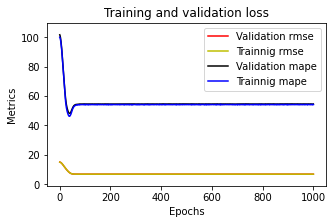

In [173]:
plotme(model2_2)

In [174]:
# # inputs: distance + hour
# model2_3 = nnmodel(10,15, num_hlayers=1,Epoch=500)
# model2_3

In [39]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 568532.6250 - distance_layer_loss: 0.8526 - traveltime_layer_loss: 812189.5625 - distance_layer_mape: 383864.4688 - distance_layer_rmse: 0.9234 - traveltime_layer_mape: 99.8623 - traveltime_layer_rmse: 901.2156 - val_loss: 573674.8750 - val_distance_layer_loss: 9.0147 - val_traveltime_layer_loss: 819531.6875 - val_distance_layer_mape: 2553.1951 - val_distance_layer_rmse: 3.0025 - val_traveltime_layer_mape: 99.2803 - val_traveltime_layer_rmse: 905.2799
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 479291.5625 - distance_layer_loss: 519.1965 - traveltime_layer_loss: 684479.8125 - distance_layer_mape: 3341535.7500 - distance_layer_rmse: 22.7859 - traveltime_layer_mape: 85.7741 - traveltime_layer_rmse: 827.3329 - val_loss: 290062.6875 - val_distance_layer_loss: 2085.5598 - val_traveltime_layer_loss: 413481.3438 - val_distance_layer_mape: 37447.5234 - val_distance_layer_rmse: 45.6679 - va

179/179 [==============================] - 0s 1ms/step - loss: 116029.2500 - distance_layer_loss: 4220.6831 - traveltime_layer_loss: 163947.2656 - distance_layer_mape: 8537895.0000 - distance_layer_rmse: 64.9668 - traveltime_layer_mape: 52.2405 - traveltime_layer_rmse: 404.9040 - val_loss: 119624.8984 - val_distance_layer_loss: 4209.5322 - val_traveltime_layer_loss: 169088.6562 - val_distance_layer_mape: 53067.0781 - val_distance_layer_rmse: 64.8809 - val_traveltime_layer_mape: 52.4766 - val_traveltime_layer_rmse: 411.2039
Epoch 17/500
179/179 [==============================] - 0s 1ms/step - loss: 115424.9844 - distance_layer_loss: 4101.9883 - traveltime_layer_loss: 163134.8750 - distance_layer_mape: 8501252.0000 - distance_layer_rmse: 64.0468 - traveltime_layer_mape: 52.5736 - traveltime_layer_rmse: 403.8996 - val_loss: 119424.5234 - val_distance_layer_loss: 3900.6460 - val_traveltime_layer_loss: 168934.7656 - val_distance_layer_mape: 51056.1172 - val_distance_layer_rmse: 62.4552 - va

179/179 [==============================] - 0s 1ms/step - loss: 106212.7812 - distance_layer_loss: 2304.2371 - traveltime_layer_loss: 150744.9844 - distance_layer_mape: 6794620.0000 - distance_layer_rmse: 48.0025 - traveltime_layer_mape: 50.7148 - traveltime_layer_rmse: 388.2589 - val_loss: 110305.0078 - val_distance_layer_loss: 2175.8596 - val_traveltime_layer_loss: 156646.0625 - val_distance_layer_mape: 37401.6719 - val_distance_layer_rmse: 46.6461 - val_traveltime_layer_mape: 48.6057 - val_traveltime_layer_rmse: 395.7854
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 105385.4062 - distance_layer_loss: 2183.2065 - traveltime_layer_loss: 149614.9062 - distance_layer_mape: 6756222.5000 - distance_layer_rmse: 46.7248 - traveltime_layer_mape: 50.1978 - traveltime_layer_rmse: 386.8009 - val_loss: 109534.6328 - val_distance_layer_loss: 2185.0842 - val_traveltime_layer_loss: 155541.6094 - val_distance_layer_mape: 37299.5586 - val_distance_layer_rmse: 46.7449 - va

179/179 [==============================] - 0s 1ms/step - loss: 94603.7969 - distance_layer_loss: 1126.7723 - traveltime_layer_loss: 134665.4062 - distance_layer_mape: 4616610.0000 - distance_layer_rmse: 33.5674 - traveltime_layer_mape: 47.0271 - traveltime_layer_rmse: 366.9679 - val_loss: 99939.9375 - val_distance_layer_loss: 1075.2244 - val_traveltime_layer_loss: 142310.5312 - val_distance_layer_mape: 24905.0977 - val_distance_layer_rmse: 32.7906 - val_traveltime_layer_mape: 45.6218 - val_traveltime_layer_rmse: 377.2407
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 93844.6562 - distance_layer_loss: 1067.9025 - traveltime_layer_loss: 133606.1406 - distance_layer_mape: 4558753.5000 - distance_layer_rmse: 32.6788 - traveltime_layer_mape: 46.4878 - traveltime_layer_rmse: 365.5217 - val_loss: 99277.9219 - val_distance_layer_loss: 1049.9966 - val_traveltime_layer_loss: 141375.6406 - val_distance_layer_mape: 24465.0195 - val_distance_layer_rmse: 32.4037 - val_tr

179/179 [==============================] - 0s 1ms/step - loss: 84716.1797 - distance_layer_loss: 614.7722 - traveltime_layer_loss: 120759.6172 - distance_layer_mape: 3466664.7500 - distance_layer_rmse: 24.7946 - traveltime_layer_mape: 43.1667 - traveltime_layer_rmse: 347.5049 - val_loss: 89861.6172 - val_distance_layer_loss: 605.8804 - val_traveltime_layer_loss: 128114.1562 - val_distance_layer_mape: 17822.7871 - val_distance_layer_rmse: 24.6146 - val_traveltime_layer_mape: 42.8486 - val_traveltime_layer_rmse: 357.9304
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 83972.3281 - distance_layer_loss: 592.0209 - traveltime_layer_loss: 119706.7109 - distance_layer_mape: 3536248.7500 - distance_layer_rmse: 24.3315 - traveltime_layer_mape: 42.8683 - traveltime_layer_rmse: 345.9866 - val_loss: 88754.2578 - val_distance_layer_loss: 579.4399 - val_traveltime_layer_loss: 126543.4766 - val_distance_layer_mape: 17421.7598 - val_distance_layer_rmse: 24.0716 - val_travel

179/179 [==============================] - 0s 1ms/step - loss: 75283.3516 - distance_layer_loss: 444.6449 - traveltime_layer_loss: 107357.0781 - distance_layer_mape: 2790757.5000 - distance_layer_rmse: 21.0866 - traveltime_layer_mape: 38.9514 - traveltime_layer_rmse: 327.6539 - val_loss: 80851.1172 - val_distance_layer_loss: 411.6052 - val_traveltime_layer_loss: 115325.2344 - val_distance_layer_mape: 13765.3623 - val_distance_layer_rmse: 20.2881 - val_traveltime_layer_mape: 36.1322 - val_traveltime_layer_rmse: 339.5957
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 74726.1406 - distance_layer_loss: 439.2782 - traveltime_layer_loss: 106563.3594 - distance_layer_mape: 2855481.7500 - distance_layer_rmse: 20.9590 - traveltime_layer_mape: 38.5246 - traveltime_layer_rmse: 326.4404 - val_loss: 79321.0469 - val_distance_layer_loss: 437.2549 - val_traveltime_layer_loss: 113128.3906 - val_distance_layer_mape: 14206.3438 - val_distance_layer_rmse: 20.9106 - val_travel

179/179 [==============================] - 0s 1ms/step - loss: 70976.7344 - distance_layer_loss: 406.3787 - traveltime_layer_loss: 101221.1250 - distance_layer_mape: 2593509.7500 - distance_layer_rmse: 20.1588 - traveltime_layer_mape: 36.5264 - traveltime_layer_rmse: 318.1527 - val_loss: 75568.5625 - val_distance_layer_loss: 409.5799 - val_traveltime_layer_loss: 107779.5156 - val_distance_layer_mape: 13255.6299 - val_distance_layer_rmse: 20.2381 - val_traveltime_layer_mape: 36.1633 - val_traveltime_layer_rmse: 328.2979
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 70681.0547 - distance_layer_loss: 407.8348 - traveltime_layer_loss: 100798.1016 - distance_layer_mape: 2573106.7500 - distance_layer_rmse: 20.1949 - traveltime_layer_mape: 36.5385 - traveltime_layer_rmse: 317.4872 - val_loss: 75390.1562 - val_distance_layer_loss: 407.2607 - val_traveltime_layer_loss: 107525.7109 - val_distance_layer_mape: 13205.9932 - val_distance_layer_rmse: 20.1807 - val_travel

179/179 [==============================] - 0s 1ms/step - loss: 68509.2812 - distance_layer_loss: 377.9497 - traveltime_layer_loss: 97708.4609 - distance_layer_mape: 2451485.2500 - distance_layer_rmse: 19.4409 - traveltime_layer_mape: 35.1228 - traveltime_layer_rmse: 312.5835 - val_loss: 73268.2734 - val_distance_layer_loss: 378.8058 - val_traveltime_layer_loss: 104506.6328 - val_distance_layer_mape: 12640.4551 - val_distance_layer_rmse: 19.4629 - val_traveltime_layer_mape: 35.6288 - val_traveltime_layer_rmse: 323.2748
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 68398.9141 - distance_layer_loss: 375.8980 - traveltime_layer_loss: 97551.6328 - distance_layer_mape: 2469507.2500 - distance_layer_rmse: 19.3881 - traveltime_layer_mape: 35.3136 - traveltime_layer_rmse: 312.3326 - val_loss: 73369.4062 - val_distance_layer_loss: 369.6347 - val_traveltime_layer_loss: 104655.0234 - val_distance_layer_mape: 12425.6650 - val_distance_layer_rmse: 19.2259 - val_travelt

179/179 [==============================] - 0s 1ms/step - loss: 66001.6875 - distance_layer_loss: 344.5239 - traveltime_layer_loss: 94140.4766 - distance_layer_mape: 2324510.0000 - distance_layer_rmse: 18.5614 - traveltime_layer_mape: 33.6971 - traveltime_layer_rmse: 306.8232 - val_loss: 70858.5547 - val_distance_layer_loss: 351.1363 - val_traveltime_layer_loss: 101076.0312 - val_distance_layer_mape: 11811.4717 - val_distance_layer_rmse: 18.7386 - val_traveltime_layer_mape: 34.4144 - val_traveltime_layer_rmse: 317.9246
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 65965.2188 - distance_layer_loss: 340.8279 - traveltime_layer_loss: 94089.9688 - distance_layer_mape: 2375636.2500 - distance_layer_rmse: 18.4615 - traveltime_layer_mape: 33.9949 - traveltime_layer_rmse: 306.7409 - val_loss: 70818.2344 - val_distance_layer_loss: 342.5787 - val_traveltime_layer_loss: 101022.1172 - val_distance_layer_mape: 11559.8115 - val_distance_layer_rmse: 18.5089 - val_travelt

179/179 [==============================] - 0s 1ms/step - loss: 63235.2500 - distance_layer_loss: 304.5489 - traveltime_layer_loss: 90205.5469 - distance_layer_mape: 2131077.5000 - distance_layer_rmse: 17.4513 - traveltime_layer_mape: 32.2297 - traveltime_layer_rmse: 300.3424 - val_loss: 68181.8828 - val_distance_layer_loss: 300.8409 - val_traveltime_layer_loss: 97273.8047 - val_distance_layer_mape: 10818.5771 - val_distance_layer_rmse: 17.3448 - val_traveltime_layer_mape: 32.5717 - val_traveltime_layer_rmse: 311.8875
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 63060.2852 - distance_layer_loss: 300.3535 - traveltime_layer_loss: 89957.4141 - distance_layer_mape: 2199138.7500 - distance_layer_rmse: 17.3307 - traveltime_layer_mape: 32.5206 - traveltime_layer_rmse: 299.9290 - val_loss: 68148.5469 - val_distance_layer_loss: 307.7313 - val_traveltime_layer_loss: 97223.1719 - val_distance_layer_mape: 10840.9922 - val_distance_layer_rmse: 17.5423 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 60151.4844 - distance_layer_loss: 269.4903 - traveltime_layer_loss: 85815.1641 - distance_layer_mape: 1838935.7500 - distance_layer_rmse: 16.4162 - traveltime_layer_mape: 30.7687 - traveltime_layer_rmse: 292.9423 - val_loss: 65414.8711 - val_distance_layer_loss: 273.7856 - val_traveltime_layer_loss: 93332.4922 - val_distance_layer_mape: 9863.4248 - val_distance_layer_rmse: 16.5465 - val_traveltime_layer_mape: 31.2071 - val_traveltime_layer_rmse: 305.5037
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 60119.2617 - distance_layer_loss: 267.9886 - traveltime_layer_loss: 85769.8047 - distance_layer_mape: 1855899.0000 - distance_layer_rmse: 16.3704 - traveltime_layer_mape: 30.8585 - traveltime_layer_rmse: 292.8648 - val_loss: 65899.5703 - val_distance_layer_loss: 247.9038 - val_traveltime_layer_loss: 94035.9922 - val_distance_layer_mape: 9356.0156 - val_distance_layer_rmse: 15.7450 - val_traveltime_

179/179 [==============================] - 0s 974us/step - loss: 58398.3594 - distance_layer_loss: 240.6953 - traveltime_layer_loss: 83323.0859 - distance_layer_mape: 1698975.0000 - distance_layer_rmse: 15.5144 - traveltime_layer_mape: 30.1118 - traveltime_layer_rmse: 288.6574 - val_loss: 63185.4375 - val_distance_layer_loss: 236.6183 - val_traveltime_layer_loss: 90163.5000 - val_distance_layer_mape: 9130.8916 - val_distance_layer_rmse: 15.3824 - val_traveltime_layer_mape: 29.5973 - val_traveltime_layer_rmse: 300.2724
Epoch 167/500
179/179 [==============================] - 0s 996us/step - loss: 58461.4531 - distance_layer_loss: 237.7233 - traveltime_layer_loss: 83414.4922 - distance_layer_mape: 1648094.0000 - distance_layer_rmse: 15.4183 - traveltime_layer_mape: 30.0778 - traveltime_layer_rmse: 288.8157 - val_loss: 63046.5977 - val_distance_layer_loss: 246.5838 - val_traveltime_layer_loss: 89960.8906 - val_distance_layer_mape: 9389.4287 - val_distance_layer_rmse: 15.7030 - val_travelt

179/179 [==============================] - 0s 1ms/step - loss: 57434.7148 - distance_layer_loss: 220.3507 - traveltime_layer_loss: 81955.1641 - distance_layer_mape: 1546895.6250 - distance_layer_rmse: 14.8442 - traveltime_layer_mape: 29.6503 - traveltime_layer_rmse: 286.2781 - val_loss: 61964.3516 - val_distance_layer_loss: 212.4703 - val_traveltime_layer_loss: 88429.4297 - val_distance_layer_mape: 8625.0840 - val_distance_layer_rmse: 14.5764 - val_traveltime_layer_mape: 28.4418 - val_traveltime_layer_rmse: 297.3708
Epoch 182/500
179/179 [==============================] - 0s 992us/step - loss: 57191.2656 - distance_layer_loss: 219.2776 - traveltime_layer_loss: 81607.8281 - distance_layer_mape: 1554784.6250 - distance_layer_rmse: 14.8080 - traveltime_layer_mape: 29.5344 - traveltime_layer_rmse: 285.6708 - val_loss: 62018.9766 - val_distance_layer_loss: 224.1049 - val_traveltime_layer_loss: 88502.5000 - val_distance_layer_mape: 8846.8223 - val_distance_layer_rmse: 14.9701 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 56589.0117 - distance_layer_loss: 204.0008 - traveltime_layer_loss: 80754.0469 - distance_layer_mape: 1410905.8750 - distance_layer_rmse: 14.2829 - traveltime_layer_mape: 29.2966 - traveltime_layer_rmse: 284.1726 - val_loss: 61052.3867 - val_distance_layer_loss: 196.3615 - val_traveltime_layer_loss: 87133.5234 - val_distance_layer_mape: 8216.2783 - val_distance_layer_rmse: 14.0129 - val_traveltime_layer_mape: 27.7912 - val_traveltime_layer_rmse: 295.1839
Epoch 197/500
179/179 [==============================] - 0s 1ms/step - loss: 56524.1523 - distance_layer_loss: 203.1307 - traveltime_layer_loss: 80661.7344 - distance_layer_mape: 1462729.2500 - distance_layer_rmse: 14.2524 - traveltime_layer_mape: 29.0461 - traveltime_layer_rmse: 284.0101 - val_loss: 61510.8789 - val_distance_layer_loss: 217.6122 - val_traveltime_layer_loss: 87779.4375 - val_distance_layer_mape: 8666.1992 - val_distance_layer_rmse: 14.7517 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 55925.8672 - distance_layer_loss: 195.3392 - traveltime_layer_loss: 79810.3516 - distance_layer_mape: 1365645.3750 - distance_layer_rmse: 13.9764 - traveltime_layer_mape: 28.6845 - traveltime_layer_rmse: 282.5073 - val_loss: 60146.7930 - val_distance_layer_loss: 194.5994 - val_traveltime_layer_loss: 85840.5938 - val_distance_layer_mape: 8159.0718 - val_distance_layer_rmse: 13.9499 - val_traveltime_layer_mape: 28.5035 - val_traveltime_layer_rmse: 292.9857
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 55888.4531 - distance_layer_loss: 196.1660 - traveltime_layer_loss: 79756.5859 - distance_layer_mape: 1428515.7500 - distance_layer_rmse: 14.0059 - traveltime_layer_mape: 28.9110 - traveltime_layer_rmse: 282.4121 - val_loss: 60326.2773 - val_distance_layer_loss: 187.3053 - val_traveltime_layer_loss: 86100.1016 - val_distance_layer_mape: 8050.1597 - val_distance_layer_rmse: 13.6860 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 55482.5977 - distance_layer_loss: 192.7339 - traveltime_layer_loss: 79178.2734 - distance_layer_mape: 1389526.8750 - distance_layer_rmse: 13.8829 - traveltime_layer_mape: 28.7897 - traveltime_layer_rmse: 281.3864 - val_loss: 60667.3750 - val_distance_layer_loss: 179.7326 - val_traveltime_layer_loss: 86590.5938 - val_distance_layer_mape: 7755.1216 - val_distance_layer_rmse: 13.4064 - val_traveltime_layer_mape: 26.6576 - val_traveltime_layer_rmse: 294.2628
Epoch 227/500
179/179 [==============================] - 0s 1ms/step - loss: 55632.4258 - distance_layer_loss: 192.2968 - traveltime_layer_loss: 79392.4453 - distance_layer_mape: 1404534.3750 - distance_layer_rmse: 13.8671 - traveltime_layer_mape: 28.5701 - traveltime_layer_rmse: 281.7667 - val_loss: 60014.4414 - val_distance_layer_loss: 195.0075 - val_traveltime_layer_loss: 85651.3203 - val_distance_layer_mape: 8136.6875 - val_distance_layer_rmse: 13.9645 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 55396.3789 - distance_layer_loss: 191.1258 - traveltime_layer_loss: 79055.7500 - distance_layer_mape: 1376327.2500 - distance_layer_rmse: 13.8248 - traveltime_layer_mape: 28.3195 - traveltime_layer_rmse: 281.1685 - val_loss: 60364.7969 - val_distance_layer_loss: 204.3436 - val_traveltime_layer_loss: 86147.8281 - val_distance_layer_mape: 8336.6152 - val_distance_layer_rmse: 14.2949 - val_traveltime_layer_mape: 30.6568 - val_traveltime_layer_rmse: 293.5095
Epoch 242/500
179/179 [==============================] - 0s 1000us/step - loss: 55312.6992 - distance_layer_loss: 191.6418 - traveltime_layer_loss: 78936.0234 - distance_layer_mape: 1386470.0000 - distance_layer_rmse: 13.8435 - traveltime_layer_mape: 28.7636 - traveltime_layer_rmse: 280.9556 - val_loss: 59842.8906 - val_distance_layer_loss: 184.4718 - val_traveltime_layer_loss: 85410.7734 - val_distance_layer_mape: 7874.0522 - val_distance_layer_rmse: 13.5820 - val_travelti

179/179 [==============================] - 0s 1ms/step - loss: 55251.4688 - distance_layer_loss: 189.1140 - traveltime_layer_loss: 78849.6172 - distance_layer_mape: 1422616.6250 - distance_layer_rmse: 13.7519 - traveltime_layer_mape: 28.6454 - traveltime_layer_rmse: 280.8017 - val_loss: 59733.4570 - val_distance_layer_loss: 193.8018 - val_traveltime_layer_loss: 85250.4609 - val_distance_layer_mape: 8045.4697 - val_distance_layer_rmse: 13.9213 - val_traveltime_layer_mape: 28.7590 - val_traveltime_layer_rmse: 291.9768
Epoch 257/500
179/179 [==============================] - 0s 1ms/step - loss: 55190.1133 - distance_layer_loss: 190.0709 - traveltime_layer_loss: 78761.5469 - distance_layer_mape: 1429284.6250 - distance_layer_rmse: 13.7866 - traveltime_layer_mape: 28.5007 - traveltime_layer_rmse: 280.6449 - val_loss: 59760.6211 - val_distance_layer_loss: 190.4661 - val_traveltime_layer_loss: 85290.6719 - val_distance_layer_mape: 8025.0181 - val_distance_layer_rmse: 13.8009 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 55025.2070 - distance_layer_loss: 187.6104 - traveltime_layer_loss: 78527.0625 - distance_layer_mape: 1412886.8750 - distance_layer_rmse: 13.6971 - traveltime_layer_mape: 28.5738 - traveltime_layer_rmse: 280.2268 - val_loss: 59694.6680 - val_distance_layer_loss: 182.8353 - val_traveltime_layer_loss: 85199.7422 - val_distance_layer_mape: 7872.5088 - val_distance_layer_rmse: 13.5217 - val_traveltime_layer_mape: 27.8484 - val_traveltime_layer_rmse: 291.8900
Epoch 272/500
179/179 [==============================] - 0s 998us/step - loss: 55188.6641 - distance_layer_loss: 186.9025 - traveltime_layer_loss: 78760.8359 - distance_layer_mape: 1407786.6250 - distance_layer_rmse: 13.6712 - traveltime_layer_mape: 28.4864 - traveltime_layer_rmse: 280.6436 - val_loss: 59948.7969 - val_distance_layer_loss: 177.1901 - val_traveltime_layer_loss: 85565.2031 - val_distance_layer_mape: 7781.4614 - val_distance_layer_rmse: 13.3113 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 55211.2383 - distance_layer_loss: 185.9799 - traveltime_layer_loss: 78793.5078 - distance_layer_mape: 1433550.3750 - distance_layer_rmse: 13.6374 - traveltime_layer_mape: 28.6072 - traveltime_layer_rmse: 280.7018 - val_loss: 59846.5859 - val_distance_layer_loss: 192.2395 - val_traveltime_layer_loss: 85412.7500 - val_distance_layer_mape: 7971.4150 - val_distance_layer_rmse: 13.8650 - val_traveltime_layer_mape: 28.9324 - val_traveltime_layer_rmse: 292.2546
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 54944.9062 - distance_layer_loss: 185.8121 - traveltime_layer_loss: 78413.1172 - distance_layer_mape: 1423480.1250 - distance_layer_rmse: 13.6313 - traveltime_layer_mape: 28.4749 - traveltime_layer_rmse: 280.0234 - val_loss: 59529.5781 - val_distance_layer_loss: 191.2875 - val_traveltime_layer_loss: 84960.2891 - val_distance_layer_mape: 7982.4609 - val_distance_layer_rmse: 13.8307 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54883.8164 - distance_layer_loss: 184.1282 - traveltime_layer_loss: 78326.5078 - distance_layer_mape: 1459671.1250 - distance_layer_rmse: 13.5694 - traveltime_layer_mape: 28.1287 - traveltime_layer_rmse: 279.8687 - val_loss: 59968.2461 - val_distance_layer_loss: 188.7515 - val_traveltime_layer_loss: 85588.0547 - val_distance_layer_mape: 7947.9648 - val_distance_layer_rmse: 13.7387 - val_traveltime_layer_mape: 28.9138 - val_traveltime_layer_rmse: 292.5544
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 55100.9219 - distance_layer_loss: 184.5152 - traveltime_layer_loss: 78636.5391 - distance_layer_mape: 1432392.0000 - distance_layer_rmse: 13.5836 - traveltime_layer_mape: 28.6219 - traveltime_layer_rmse: 280.4221 - val_loss: 59658.2695 - val_distance_layer_loss: 175.5663 - val_traveltime_layer_loss: 85150.8594 - val_distance_layer_mape: 7651.0269 - val_distance_layer_rmse: 13.2501 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54868.7266 - distance_layer_loss: 184.0328 - traveltime_layer_loss: 78305.0156 - distance_layer_mape: 1412381.7500 - distance_layer_rmse: 13.5659 - traveltime_layer_mape: 28.3502 - traveltime_layer_rmse: 279.8303 - val_loss: 59336.8945 - val_distance_layer_loss: 183.3633 - val_traveltime_layer_loss: 84688.3750 - val_distance_layer_mape: 7800.4365 - val_distance_layer_rmse: 13.5412 - val_traveltime_layer_mape: 27.9127 - val_traveltime_layer_rmse: 291.0127
Epoch 317/500
179/179 [==============================] - 0s 1ms/step - loss: 54884.8633 - distance_layer_loss: 183.4988 - traveltime_layer_loss: 78328.2969 - distance_layer_mape: 1445470.7500 - distance_layer_rmse: 13.5462 - traveltime_layer_mape: 28.3189 - traveltime_layer_rmse: 279.8719 - val_loss: 59391.3750 - val_distance_layer_loss: 187.9990 - val_traveltime_layer_loss: 84764.2578 - val_distance_layer_mape: 7928.9097 - val_distance_layer_rmse: 13.7113 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54735.0586 - distance_layer_loss: 182.0124 - traveltime_layer_loss: 78114.9609 - distance_layer_mape: 1450782.1250 - distance_layer_rmse: 13.4912 - traveltime_layer_mape: 28.3906 - traveltime_layer_rmse: 279.4905 - val_loss: 59432.5742 - val_distance_layer_loss: 183.2934 - val_traveltime_layer_loss: 84825.1094 - val_distance_layer_mape: 7783.9438 - val_distance_layer_rmse: 13.5386 - val_traveltime_layer_mape: 28.2603 - val_traveltime_layer_rmse: 291.2475
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 54788.0156 - distance_layer_loss: 181.4917 - traveltime_layer_loss: 78190.8281 - distance_layer_mape: 1420456.1250 - distance_layer_rmse: 13.4719 - traveltime_layer_mape: 28.3965 - traveltime_layer_rmse: 279.6262 - val_loss: 59266.5508 - val_distance_layer_loss: 188.7154 - val_traveltime_layer_loss: 84585.6406 - val_distance_layer_mape: 7919.8032 - val_distance_layer_rmse: 13.7374 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54591.2227 - distance_layer_loss: 180.3351 - traveltime_layer_loss: 77910.1875 - distance_layer_mape: 1435494.5000 - distance_layer_rmse: 13.4289 - traveltime_layer_mape: 28.2883 - traveltime_layer_rmse: 279.1240 - val_loss: 59111.1250 - val_distance_layer_loss: 179.3744 - val_traveltime_layer_loss: 84367.6250 - val_distance_layer_mape: 7692.1313 - val_distance_layer_rmse: 13.3931 - val_traveltime_layer_mape: 27.5307 - val_traveltime_layer_rmse: 290.4611
Epoch 347/500
179/179 [==============================] - 0s 987us/step - loss: 54548.6328 - distance_layer_loss: 181.4103 - traveltime_layer_loss: 77848.7969 - distance_layer_mape: 1430789.6250 - distance_layer_rmse: 13.4689 - traveltime_layer_mape: 28.2215 - traveltime_layer_rmse: 279.0140 - val_loss: 59012.8477 - val_distance_layer_loss: 180.2428 - val_traveltime_layer_loss: 84226.8203 - val_distance_layer_mape: 7729.8101 - val_distance_layer_rmse: 13.4255 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 54510.3164 - distance_layer_loss: 181.9972 - traveltime_layer_loss: 77793.8750 - distance_layer_mape: 1484449.8750 - distance_layer_rmse: 13.4906 - traveltime_layer_mape: 28.3384 - traveltime_layer_rmse: 278.9155 - val_loss: 59440.0664 - val_distance_layer_loss: 173.1044 - val_traveltime_layer_loss: 84840.1641 - val_distance_layer_mape: 7572.6895 - val_distance_layer_rmse: 13.1569 - val_traveltime_layer_mape: 26.8590 - val_traveltime_layer_rmse: 291.2733
Epoch 362/500
179/179 [==============================] - 0s 993us/step - loss: 54549.4141 - distance_layer_loss: 180.8760 - traveltime_layer_loss: 77850.2578 - distance_layer_mape: 1456056.5000 - distance_layer_rmse: 13.4490 - traveltime_layer_mape: 28.2286 - traveltime_layer_rmse: 279.0166 - val_loss: 59524.6836 - val_distance_layer_loss: 176.7674 - val_traveltime_layer_loss: 84959.5078 - val_distance_layer_mape: 7659.5205 - val_distance_layer_rmse: 13.2954 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 54361.4258 - distance_layer_loss: 179.3781 - traveltime_layer_loss: 77582.2969 - distance_layer_mape: 1454462.6250 - distance_layer_rmse: 13.3932 - traveltime_layer_mape: 28.3762 - traveltime_layer_rmse: 278.5360 - val_loss: 59347.1719 - val_distance_layer_loss: 184.6655 - val_traveltime_layer_loss: 84702.5469 - val_distance_layer_mape: 7767.2847 - val_distance_layer_rmse: 13.5892 - val_traveltime_layer_mape: 28.5479 - val_traveltime_layer_rmse: 291.0370
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 54459.4414 - distance_layer_loss: 178.7997 - traveltime_layer_loss: 77722.5781 - distance_layer_mape: 1454289.1250 - distance_layer_rmse: 13.3716 - traveltime_layer_mape: 28.2905 - traveltime_layer_rmse: 278.7877 - val_loss: 58970.1016 - val_distance_layer_loss: 177.5554 - val_traveltime_layer_loss: 84166.9062 - val_distance_layer_mape: 7661.7168 - val_distance_layer_rmse: 13.3250 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54255.2109 - distance_layer_loss: 178.4021 - traveltime_layer_loss: 77431.0000 - distance_layer_mape: 1479459.0000 - distance_layer_rmse: 13.3567 - traveltime_layer_mape: 28.3336 - traveltime_layer_rmse: 278.2643 - val_loss: 59370.5234 - val_distance_layer_loss: 167.5734 - val_traveltime_layer_loss: 84743.2422 - val_distance_layer_mape: 7446.2554 - val_distance_layer_rmse: 12.9450 - val_traveltime_layer_mape: 26.2671 - val_traveltime_layer_rmse: 291.1069
Epoch 392/500
179/179 [==============================] - 0s 1ms/step - loss: 54283.6484 - distance_layer_loss: 178.1721 - traveltime_layer_loss: 77471.6875 - distance_layer_mape: 1477257.6250 - distance_layer_rmse: 13.3481 - traveltime_layer_mape: 28.1173 - traveltime_layer_rmse: 278.3374 - val_loss: 58590.7734 - val_distance_layer_loss: 174.3739 - val_traveltime_layer_loss: 83626.3984 - val_distance_layer_mape: 7668.3198 - val_distance_layer_rmse: 13.2051 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54116.5430 - distance_layer_loss: 177.8863 - traveltime_layer_loss: 77233.1328 - distance_layer_mape: 1508881.1250 - distance_layer_rmse: 13.3374 - traveltime_layer_mape: 28.4358 - traveltime_layer_rmse: 277.9085 - val_loss: 58522.6758 - val_distance_layer_loss: 174.9246 - val_traveltime_layer_loss: 83528.8516 - val_distance_layer_mape: 7585.9307 - val_distance_layer_rmse: 13.2259 - val_traveltime_layer_mape: 27.3913 - val_traveltime_layer_rmse: 289.0136
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 54141.2305 - distance_layer_loss: 176.3747 - traveltime_layer_loss: 77269.0156 - distance_layer_mape: 1515639.0000 - distance_layer_rmse: 13.2806 - traveltime_layer_mape: 28.2169 - traveltime_layer_rmse: 277.9731 - val_loss: 58876.5820 - val_distance_layer_loss: 173.8516 - val_traveltime_layer_loss: 84034.9062 - val_distance_layer_mape: 7507.3916 - val_distance_layer_rmse: 13.1853 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 53945.7773 - distance_layer_loss: 176.9617 - traveltime_layer_loss: 76989.5703 - distance_layer_mape: 1566798.2500 - distance_layer_rmse: 13.3027 - traveltime_layer_mape: 28.3140 - traveltime_layer_rmse: 277.4699 - val_loss: 58406.2891 - val_distance_layer_loss: 179.2034 - val_traveltime_layer_loss: 83360.7734 - val_distance_layer_mape: 7691.8735 - val_distance_layer_rmse: 13.3867 - val_traveltime_layer_mape: 28.0312 - val_traveltime_layer_rmse: 288.7227
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 53987.5820 - distance_layer_loss: 177.2534 - traveltime_layer_loss: 77049.1719 - distance_layer_mape: 1518870.5000 - distance_layer_rmse: 13.3137 - traveltime_layer_mape: 28.1532 - traveltime_layer_rmse: 277.5773 - val_loss: 58443.5117 - val_distance_layer_loss: 178.7968 - val_traveltime_layer_loss: 83414.0938 - val_distance_layer_mape: 7669.4258 - val_distance_layer_rmse: 13.3715 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 54039.0977 - distance_layer_loss: 175.7106 - traveltime_layer_loss: 77123.4297 - distance_layer_mape: 1512353.1250 - distance_layer_rmse: 13.2556 - traveltime_layer_mape: 28.1794 - traveltime_layer_rmse: 277.7111 - val_loss: 58379.9297 - val_distance_layer_loss: 172.1967 - val_traveltime_layer_loss: 83326.1172 - val_distance_layer_mape: 7583.3076 - val_distance_layer_rmse: 13.1224 - val_traveltime_layer_mape: 27.5107 - val_traveltime_layer_rmse: 288.6626
Epoch 437/500
179/179 [==============================] - 0s 1ms/step - loss: 53910.8594 - distance_layer_loss: 175.3043 - traveltime_layer_loss: 76940.3906 - distance_layer_mape: 1516899.3750 - distance_layer_rmse: 13.2403 - traveltime_layer_mape: 28.1862 - traveltime_layer_rmse: 277.3813 - val_loss: 58602.6484 - val_distance_layer_loss: 181.9931 - val_traveltime_layer_loss: 83640.0625 - val_distance_layer_mape: 7728.9199 - val_distance_layer_rmse: 13.4905 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 53884.7852 - distance_layer_loss: 175.1912 - traveltime_layer_loss: 76903.2031 - distance_layer_mape: 1534786.3750 - distance_layer_rmse: 13.2360 - traveltime_layer_mape: 28.2366 - traveltime_layer_rmse: 277.3143 - val_loss: 58627.9141 - val_distance_layer_loss: 169.0768 - val_traveltime_layer_loss: 83681.6953 - val_distance_layer_mape: 7463.0781 - val_distance_layer_rmse: 13.0030 - val_traveltime_layer_mape: 26.9412 - val_traveltime_layer_rmse: 289.2779
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 53901.8477 - distance_layer_loss: 175.4451 - traveltime_layer_loss: 76927.4609 - distance_layer_mape: 1539096.0000 - distance_layer_rmse: 13.2456 - traveltime_layer_mape: 28.1913 - traveltime_layer_rmse: 277.3580 - val_loss: 58605.8711 - val_distance_layer_loss: 168.8012 - val_traveltime_layer_loss: 83650.3359 - val_distance_layer_mape: 7453.6348 - val_distance_layer_rmse: 12.9924 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 53906.4688 - distance_layer_loss: 174.2628 - traveltime_layer_loss: 76934.5703 - distance_layer_mape: 1498470.3750 - distance_layer_rmse: 13.2009 - traveltime_layer_mape: 28.0784 - traveltime_layer_rmse: 277.3708 - val_loss: 58239.2422 - val_distance_layer_loss: 172.7386 - val_traveltime_layer_loss: 83124.8906 - val_distance_layer_mape: 7582.5435 - val_distance_layer_rmse: 13.1430 - val_traveltime_layer_mape: 27.6129 - val_traveltime_layer_rmse: 288.3139
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 53908.8516 - distance_layer_loss: 173.7850 - traveltime_layer_loss: 76938.1953 - distance_layer_mape: 1578161.2500 - distance_layer_rmse: 13.1828 - traveltime_layer_mape: 28.0802 - traveltime_layer_rmse: 277.3773 - val_loss: 58158.9102 - val_distance_layer_loss: 176.3377 - val_traveltime_layer_loss: 83008.5703 - val_distance_layer_mape: 7655.8989 - val_distance_layer_rmse: 13.2792 - val_traveltime_

179/179 [==============================] - 0s 986us/step - loss: 53738.6914 - distance_layer_loss: 174.2371 - traveltime_layer_loss: 76694.8672 - distance_layer_mape: 1549113.6250 - distance_layer_rmse: 13.1999 - traveltime_layer_mape: 28.1101 - traveltime_layer_rmse: 276.9384 - val_loss: 58500.6406 - val_distance_layer_loss: 172.4392 - val_traveltime_layer_loss: 83498.4375 - val_distance_layer_mape: 7480.2773 - val_distance_layer_rmse: 13.1316 - val_traveltime_layer_mape: 27.3678 - val_traveltime_layer_rmse: 288.9610
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 53931.4805 - distance_layer_loss: 173.4684 - traveltime_layer_loss: 76970.6328 - distance_layer_mape: 1578773.0000 - distance_layer_rmse: 13.1707 - traveltime_layer_mape: 28.1212 - traveltime_layer_rmse: 277.4358 - val_loss: 58261.7891 - val_distance_layer_loss: 177.2792 - val_traveltime_layer_loss: 83155.1484 - val_distance_layer_mape: 7688.2212 - val_distance_layer_rmse: 13.3146 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 53630.0195 - distance_layer_loss: 173.7728 - traveltime_layer_loss: 76539.8203 - distance_layer_mape: 1528854.5000 - distance_layer_rmse: 13.1823 - traveltime_layer_mape: 27.9333 - traveltime_layer_rmse: 276.6583 - val_loss: 58088.5078 - val_distance_layer_loss: 178.6854 - val_traveltime_layer_loss: 82907.0078 - val_distance_layer_mape: 7754.1567 - val_distance_layer_rmse: 13.3673 - val_traveltime_layer_mape: 28.9689 - val_traveltime_layer_rmse: 287.9358
Epoch 497/500
179/179 [==============================] - 0s 991us/step - loss: 53851.7773 - distance_layer_loss: 172.7582 - traveltime_layer_loss: 76857.0547 - distance_layer_mape: 1604995.6250 - distance_layer_rmse: 13.1438 - traveltime_layer_mape: 28.2940 - traveltime_layer_rmse: 277.2310 - val_loss: 58357.2070 - val_distance_layer_loss: 177.6222 - val_traveltime_layer_loss: 83291.3281 - val_distance_layer_mape: 7683.8506 - val_distance_layer_rmse: 13.3275 - val_traveltim

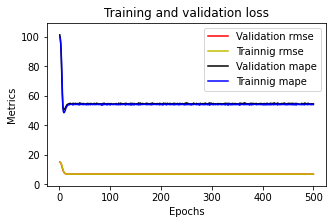

In [176]:
plotme(model2_4)

In [40]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
179/179 [==============================] - 1s 2ms/step - loss: 563515.6875 - distance_layer_loss: 0.5651 - traveltime_layer_loss: 805022.4375 - distance_layer_mape: 99628.0156 - distance_layer_rmse: 0.7517 - traveltime_layer_mape: 99.1581 - traveltime_layer_rmse: 897.2304 - val_loss: 552360.6250 - val_distance_layer_loss: 3.0847 - val_traveltime_layer_loss: 789085.0000 - val_distance_layer_mape: 1573.2664 - val_distance_layer_rmse: 1.7563 - val_traveltime_layer_mape: 96.2138 - val_traveltime_layer_rmse: 888.3046
Epoch 2/500
179/179 [==============================] - 0s 1ms/step - loss: 354855.7812 - distance_layer_loss: 46.5091 - traveltime_layer_loss: 506917.0000 - distance_layer_mape: 956616.2500 - distance_layer_rmse: 6.8198 - traveltime_layer_mape: 68.4545 - traveltime_layer_rmse: 711.9810 - val_loss: 127684.7109 - val_distance_layer_loss: 132.5562 - val_traveltime_layer_loss: 182349.9062 - val_distance_layer_mape: 9574.0869 - val_distance_layer_rmse: 11.5133 - val_trav

179/179 [==============================] - 0s 1ms/step - loss: 118621.8984 - distance_layer_loss: 136.3298 - traveltime_layer_loss: 169401.4375 - distance_layer_mape: 1551602.6250 - distance_layer_rmse: 11.6760 - traveltime_layer_mape: 53.2626 - traveltime_layer_rmse: 411.5840 - val_loss: 121594.7422 - val_distance_layer_loss: 134.0497 - val_traveltime_layer_loss: 173649.3906 - val_distance_layer_mape: 9677.5801 - val_distance_layer_rmse: 11.5780 - val_traveltime_layer_mape: 51.6049 - val_traveltime_layer_rmse: 416.7126
Epoch 17/500
179/179 [==============================] - 0s 996us/step - loss: 118419.3438 - distance_layer_loss: 135.2720 - traveltime_layer_loss: 169112.5156 - distance_layer_mape: 1567510.2500 - distance_layer_rmse: 11.6306 - traveltime_layer_mape: 53.1881 - traveltime_layer_rmse: 411.2329 - val_loss: 121332.0625 - val_distance_layer_loss: 137.1286 - val_traveltime_layer_loss: 173272.7656 - val_distance_layer_mape: 9788.7793 - val_distance_layer_rmse: 11.7102 - val_tr

179/179 [==============================] - 0s 1ms/step - loss: 117674.3750 - distance_layer_loss: 124.2996 - traveltime_layer_loss: 168053.0625 - distance_layer_mape: 1587494.5000 - distance_layer_rmse: 11.1490 - traveltime_layer_mape: 53.5414 - traveltime_layer_rmse: 409.9427 - val_loss: 120244.5312 - val_distance_layer_loss: 123.2582 - val_traveltime_layer_loss: 171725.1094 - val_distance_layer_mape: 9310.8516 - val_distance_layer_rmse: 11.1022 - val_traveltime_layer_mape: 52.3768 - val_traveltime_layer_rmse: 414.3973
Epoch 32/500
179/179 [==============================] - 0s 1ms/step - loss: 117528.8984 - distance_layer_loss: 123.5557 - traveltime_layer_loss: 167845.5469 - distance_layer_mape: 1601464.2500 - distance_layer_rmse: 11.1156 - traveltime_layer_mape: 53.4994 - traveltime_layer_rmse: 409.6896 - val_loss: 120285.0234 - val_distance_layer_loss: 121.7210 - val_traveltime_layer_loss: 171783.5625 - val_distance_layer_mape: 9254.6250 - val_distance_layer_rmse: 11.0327 - val_trav

179/179 [==============================] - 0s 1ms/step - loss: 117185.8359 - distance_layer_loss: 115.7652 - traveltime_layer_loss: 167358.7344 - distance_layer_mape: 1584970.5000 - distance_layer_rmse: 10.7594 - traveltime_layer_mape: 53.6413 - traveltime_layer_rmse: 409.0950 - val_loss: 119711.8594 - val_distance_layer_loss: 115.2108 - val_traveltime_layer_loss: 170967.5625 - val_distance_layer_mape: 9015.5918 - val_distance_layer_rmse: 10.7336 - val_traveltime_layer_mape: 52.7342 - val_traveltime_layer_rmse: 413.4822
Epoch 47/500
179/179 [==============================] - 0s 1ms/step - loss: 117103.3281 - distance_layer_loss: 115.0107 - traveltime_layer_loss: 167241.0938 - distance_layer_mape: 1586579.1250 - distance_layer_rmse: 10.7243 - traveltime_layer_mape: 53.6291 - traveltime_layer_rmse: 408.9512 - val_loss: 119684.4766 - val_distance_layer_loss: 114.7462 - val_traveltime_layer_loss: 170928.6562 - val_distance_layer_mape: 8998.0273 - val_distance_layer_rmse: 10.7120 - val_trav

179/179 [==============================] - 0s 1ms/step - loss: 117046.4922 - distance_layer_loss: 109.7448 - traveltime_layer_loss: 167162.2188 - distance_layer_mape: 1574794.8750 - distance_layer_rmse: 10.4759 - traveltime_layer_mape: 53.6753 - traveltime_layer_rmse: 408.8548 - val_loss: 119633.3672 - val_distance_layer_loss: 108.0728 - val_traveltime_layer_loss: 170858.4531 - val_distance_layer_mape: 8738.0947 - val_distance_layer_rmse: 10.3958 - val_traveltime_layer_mape: 51.8855 - val_traveltime_layer_rmse: 413.3503
Epoch 62/500
179/179 [==============================] - 0s 1ms/step - loss: 116848.8359 - distance_layer_loss: 109.6212 - traveltime_layer_loss: 166879.9062 - distance_layer_mape: 1582192.2500 - distance_layer_rmse: 10.4700 - traveltime_layer_mape: 53.6542 - traveltime_layer_rmse: 408.5094 - val_loss: 119501.7656 - val_distance_layer_loss: 109.0823 - val_traveltime_layer_loss: 170670.0938 - val_distance_layer_mape: 8777.9717 - val_distance_layer_rmse: 10.4442 - val_trav

179/179 [==============================] - 0s 1ms/step - loss: 116906.7422 - distance_layer_loss: 105.3494 - traveltime_layer_loss: 166964.4375 - distance_layer_mape: 1557845.2500 - distance_layer_rmse: 10.2640 - traveltime_layer_mape: 53.3408 - traveltime_layer_rmse: 408.6128 - val_loss: 119738.8594 - val_distance_layer_loss: 103.2058 - val_traveltime_layer_loss: 171011.2812 - val_distance_layer_mape: 8540.4736 - val_distance_layer_rmse: 10.1590 - val_traveltime_layer_mape: 51.2577 - val_traveltime_layer_rmse: 413.5351
Epoch 77/500
179/179 [==============================] - 0s 1ms/step - loss: 116799.9453 - distance_layer_loss: 105.4123 - traveltime_layer_loss: 166811.8750 - distance_layer_mape: 1568368.2500 - distance_layer_rmse: 10.2670 - traveltime_layer_mape: 53.5245 - traveltime_layer_rmse: 408.4261 - val_loss: 119418.6328 - val_distance_layer_loss: 105.1039 - val_traveltime_layer_loss: 170553.0000 - val_distance_layer_mape: 8617.0723 - val_distance_layer_rmse: 10.2520 - val_trav

179/179 [==============================] - 0s 1ms/step - loss: 116647.6328 - distance_layer_loss: 102.1465 - traveltime_layer_loss: 166595.7344 - distance_layer_mape: 1535784.1250 - distance_layer_rmse: 10.1068 - traveltime_layer_mape: 53.3031 - traveltime_layer_rmse: 408.1614 - val_loss: 119374.9688 - val_distance_layer_loss: 102.9068 - val_traveltime_layer_loss: 170491.5625 - val_distance_layer_mape: 8524.8125 - val_distance_layer_rmse: 10.1443 - val_traveltime_layer_mape: 53.0539 - val_traveltime_layer_rmse: 412.9062
Epoch 92/500
179/179 [==============================] - 0s 1ms/step - loss: 116700.6797 - distance_layer_loss: 102.3267 - traveltime_layer_loss: 166671.4062 - distance_layer_mape: 1548961.1250 - distance_layer_rmse: 10.1157 - traveltime_layer_mape: 53.5483 - traveltime_layer_rmse: 408.2541 - val_loss: 119418.4922 - val_distance_layer_loss: 103.9329 - val_traveltime_layer_loss: 170553.3281 - val_distance_layer_mape: 8566.1436 - val_distance_layer_rmse: 10.1947 - val_trav

179/179 [==============================] - 0s 1ms/step - loss: 116488.6016 - distance_layer_loss: 99.9663 - traveltime_layer_loss: 166369.5312 - distance_layer_mape: 1529622.3750 - distance_layer_rmse: 9.9983 - traveltime_layer_mape: 53.5203 - traveltime_layer_rmse: 407.8842 - val_loss: 119390.8281 - val_distance_layer_loss: 100.6141 - val_traveltime_layer_loss: 170515.1406 - val_distance_layer_mape: 8427.5068 - val_distance_layer_rmse: 10.0307 - val_traveltime_layer_mape: 53.2055 - val_traveltime_layer_rmse: 412.9348
Epoch 107/500
179/179 [==============================] - 0s 1ms/step - loss: 116489.7109 - distance_layer_loss: 99.8932 - traveltime_layer_loss: 166371.1562 - distance_layer_mape: 1538916.6250 - distance_layer_rmse: 9.9947 - traveltime_layer_mape: 53.4457 - traveltime_layer_rmse: 407.8862 - val_loss: 119448.0391 - val_distance_layer_loss: 101.5877 - val_traveltime_layer_loss: 170596.5469 - val_distance_layer_mape: 8467.0596 - val_distance_layer_rmse: 10.0791 - val_travelt

179/179 [==============================] - 0s 1ms/step - loss: 116557.1797 - distance_layer_loss: 98.3181 - traveltime_layer_loss: 166468.1250 - distance_layer_mape: 1520896.3750 - distance_layer_rmse: 9.9155 - traveltime_layer_mape: 54.0039 - traveltime_layer_rmse: 408.0051 - val_loss: 119509.8203 - val_distance_layer_loss: 96.5575 - val_traveltime_layer_loss: 170686.8594 - val_distance_layer_mape: 8255.3242 - val_distance_layer_rmse: 9.8264 - val_traveltime_layer_mape: 52.0612 - val_traveltime_layer_rmse: 413.1427
Epoch 122/500
179/179 [==============================] - 0s 1ms/step - loss: 116498.0703 - distance_layer_loss: 96.9904 - traveltime_layer_loss: 166384.1719 - distance_layer_mape: 1520587.3750 - distance_layer_rmse: 9.8484 - traveltime_layer_mape: 53.0714 - traveltime_layer_rmse: 407.9022 - val_loss: 119544.1562 - val_distance_layer_loss: 99.8484 - val_traveltime_layer_loss: 170734.5312 - val_distance_layer_mape: 8391.9941 - val_distance_layer_rmse: 9.9924 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116416.7578 - distance_layer_loss: 95.5481 - traveltime_layer_loss: 166268.7500 - distance_layer_mape: 1492740.5000 - distance_layer_rmse: 9.7749 - traveltime_layer_mape: 53.4746 - traveltime_layer_rmse: 407.7607 - val_loss: 119449.8281 - val_distance_layer_loss: 96.1801 - val_traveltime_layer_loss: 170601.3906 - val_distance_layer_mape: 8236.3076 - val_distance_layer_rmse: 9.8071 - val_traveltime_layer_mape: 53.1826 - val_traveltime_layer_rmse: 413.0392
Epoch 137/500
179/179 [==============================] - 0s 1ms/step - loss: 116435.7344 - distance_layer_loss: 95.6512 - traveltime_layer_loss: 166295.8125 - distance_layer_mape: 1493144.5000 - distance_layer_rmse: 9.7801 - traveltime_layer_mape: 53.5382 - traveltime_layer_rmse: 407.7938 - val_loss: 119609.6719 - val_distance_layer_loss: 94.1219 - val_traveltime_layer_loss: 170830.5938 - val_distance_layer_mape: 8149.2686 - val_distance_layer_rmse: 9.7016 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116411.7969 - distance_layer_loss: 94.1221 - traveltime_layer_loss: 166262.2500 - distance_layer_mape: 1480062.2500 - distance_layer_rmse: 9.7017 - traveltime_layer_mape: 53.6937 - traveltime_layer_rmse: 407.7527 - val_loss: 119699.5625 - val_distance_layer_loss: 92.1145 - val_traveltime_layer_loss: 170959.8750 - val_distance_layer_mape: 8060.6143 - val_distance_layer_rmse: 9.5976 - val_traveltime_layer_mape: 51.5673 - val_traveltime_layer_rmse: 413.4729
Epoch 152/500
179/179 [==============================] - 0s 1ms/step - loss: 116579.8750 - distance_layer_loss: 93.5027 - traveltime_layer_loss: 166502.5781 - distance_layer_mape: 1477820.8750 - distance_layer_rmse: 9.6697 - traveltime_layer_mape: 53.3105 - traveltime_layer_rmse: 408.0473 - val_loss: 119499.7734 - val_distance_layer_loss: 94.5314 - val_traveltime_layer_loss: 170673.4375 - val_distance_layer_mape: 8163.6421 - val_distance_layer_rmse: 9.7227 - val_traveltime_

179/179 [==============================] - 0s 955us/step - loss: 116488.5391 - distance_layer_loss: 92.1379 - traveltime_layer_loss: 166372.6875 - distance_layer_mape: 1455032.8750 - distance_layer_rmse: 9.5988 - traveltime_layer_mape: 53.3464 - traveltime_layer_rmse: 407.8881 - val_loss: 119681.7344 - val_distance_layer_loss: 90.9194 - val_traveltime_layer_loss: 170934.9531 - val_distance_layer_mape: 8006.9478 - val_distance_layer_rmse: 9.5352 - val_traveltime_layer_mape: 51.7717 - val_traveltime_layer_rmse: 413.4428
Epoch 167/500
179/179 [==============================] - 0s 1ms/step - loss: 116300.2969 - distance_layer_loss: 92.5789 - traveltime_layer_loss: 166103.5938 - distance_layer_mape: 1495195.8750 - distance_layer_rmse: 9.6218 - traveltime_layer_mape: 53.6163 - traveltime_layer_rmse: 407.5581 - val_loss: 120237.8203 - val_distance_layer_loss: 88.7213 - val_traveltime_layer_loss: 171730.3281 - val_distance_layer_mape: 7911.0342 - val_distance_layer_rmse: 9.4192 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116341.0312 - distance_layer_loss: 91.2160 - traveltime_layer_loss: 166162.4375 - distance_layer_mape: 1472196.1250 - distance_layer_rmse: 9.5507 - traveltime_layer_mape: 53.6171 - traveltime_layer_rmse: 407.6303 - val_loss: 119732.0703 - val_distance_layer_loss: 89.4731 - val_traveltime_layer_loss: 171007.4844 - val_distance_layer_mape: 7941.9658 - val_distance_layer_rmse: 9.4590 - val_traveltime_layer_mape: 51.6576 - val_traveltime_layer_rmse: 413.5305
Epoch 182/500
179/179 [==============================] - 0s 954us/step - loss: 116447.2500 - distance_layer_loss: 90.9064 - traveltime_layer_loss: 166314.2344 - distance_layer_mape: 1457481.1250 - distance_layer_rmse: 9.5345 - traveltime_layer_mape: 53.4007 - traveltime_layer_rmse: 407.8164 - val_loss: 119566.8516 - val_distance_layer_loss: 91.7701 - val_traveltime_layer_loss: 170770.4531 - val_distance_layer_mape: 8041.2290 - val_distance_layer_rmse: 9.5797 - val_traveltim

179/179 [==============================] - 0s 972us/step - loss: 116383.9297 - distance_layer_loss: 89.8892 - traveltime_layer_loss: 166224.2188 - distance_layer_mape: 1445887.8750 - distance_layer_rmse: 9.4810 - traveltime_layer_mape: 53.5030 - traveltime_layer_rmse: 407.7061 - val_loss: 119623.3047 - val_distance_layer_loss: 91.2050 - val_traveltime_layer_loss: 170851.3594 - val_distance_layer_mape: 8015.4429 - val_distance_layer_rmse: 9.5501 - val_traveltime_layer_mape: 53.7561 - val_traveltime_layer_rmse: 413.3417
Epoch 197/500
179/179 [==============================] - 0s 984us/step - loss: 116396.9688 - distance_layer_loss: 89.6811 - traveltime_layer_loss: 166242.8750 - distance_layer_mape: 1473303.1250 - distance_layer_rmse: 9.4700 - traveltime_layer_mape: 53.4809 - traveltime_layer_rmse: 407.7289 - val_loss: 119588.2969 - val_distance_layer_loss: 90.4691 - val_traveltime_layer_loss: 170801.6562 - val_distance_layer_mape: 7983.7446 - val_distance_layer_rmse: 9.5115 - val_travelt

179/179 [==============================] - 0s 1ms/step - loss: 116396.5625 - distance_layer_loss: 89.1287 - traveltime_layer_loss: 166242.6250 - distance_layer_mape: 1424990.7500 - distance_layer_rmse: 9.4408 - traveltime_layer_mape: 53.6384 - traveltime_layer_rmse: 407.7286 - val_loss: 119838.3984 - val_distance_layer_loss: 87.0436 - val_traveltime_layer_loss: 171160.4219 - val_distance_layer_mape: 7832.8081 - val_distance_layer_rmse: 9.3297 - val_traveltime_layer_mape: 51.4527 - val_traveltime_layer_rmse: 413.7154
Epoch 212/500
179/179 [==============================] - 0s 1ms/step - loss: 116360.6406 - distance_layer_loss: 88.1921 - traveltime_layer_loss: 166191.6250 - distance_layer_mape: 1449541.2500 - distance_layer_rmse: 9.3911 - traveltime_layer_mape: 53.0596 - traveltime_layer_rmse: 407.6661 - val_loss: 119639.2656 - val_distance_layer_loss: 90.0112 - val_traveltime_layer_loss: 170874.6250 - val_distance_layer_mape: 7962.6216 - val_distance_layer_rmse: 9.4874 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116390.6719 - distance_layer_loss: 88.0007 - traveltime_layer_loss: 166234.6250 - distance_layer_mape: 1437391.0000 - distance_layer_rmse: 9.3809 - traveltime_layer_mape: 53.5266 - traveltime_layer_rmse: 407.7188 - val_loss: 120248.8359 - val_distance_layer_loss: 84.7665 - val_traveltime_layer_loss: 171747.7500 - val_distance_layer_mape: 7730.6533 - val_distance_layer_rmse: 9.2069 - val_traveltime_layer_mape: 50.4841 - val_traveltime_layer_rmse: 414.4246
Epoch 227/500
179/179 [==============================] - 0s 975us/step - loss: 116405.7812 - distance_layer_loss: 87.7519 - traveltime_layer_loss: 166256.3438 - distance_layer_mape: 1449811.6250 - distance_layer_rmse: 9.3676 - traveltime_layer_mape: 53.3027 - traveltime_layer_rmse: 407.7455 - val_loss: 119656.8906 - val_distance_layer_loss: 87.4746 - val_traveltime_layer_loss: 170900.9062 - val_distance_layer_mape: 7850.8457 - val_distance_layer_rmse: 9.3528 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116405.2891 - distance_layer_loss: 87.1644 - traveltime_layer_loss: 166255.9531 - distance_layer_mape: 1423689.0000 - distance_layer_rmse: 9.3362 - traveltime_layer_mape: 53.4867 - traveltime_layer_rmse: 407.7450 - val_loss: 119796.8047 - val_distance_layer_loss: 85.6558 - val_traveltime_layer_loss: 171101.5625 - val_distance_layer_mape: 7769.6035 - val_distance_layer_rmse: 9.2550 - val_traveltime_layer_mape: 51.6855 - val_traveltime_layer_rmse: 413.6443
Epoch 242/500
179/179 [==============================] - 0s 977us/step - loss: 116316.9922 - distance_layer_loss: 86.9087 - traveltime_layer_loss: 166130.0000 - distance_layer_mape: 1427025.3750 - distance_layer_rmse: 9.3225 - traveltime_layer_mape: 53.3271 - traveltime_layer_rmse: 407.5905 - val_loss: 119637.5859 - val_distance_layer_loss: 87.0830 - val_traveltime_layer_loss: 170873.5781 - val_distance_layer_mape: 7832.8457 - val_distance_layer_rmse: 9.3318 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116355.5391 - distance_layer_loss: 86.4829 - traveltime_layer_loss: 166185.1094 - distance_layer_mape: 1423330.7500 - distance_layer_rmse: 9.2996 - traveltime_layer_mape: 53.5717 - traveltime_layer_rmse: 407.6581 - val_loss: 120455.2812 - val_distance_layer_loss: 82.6709 - val_traveltime_layer_loss: 172043.5312 - val_distance_layer_mape: 7635.0708 - val_distance_layer_rmse: 9.0924 - val_traveltime_layer_mape: 50.1347 - val_traveltime_layer_rmse: 414.7813
Epoch 257/500
179/179 [==============================] - 0s 989us/step - loss: 116382.2188 - distance_layer_loss: 85.7699 - traveltime_layer_loss: 166223.5938 - distance_layer_mape: 1433063.7500 - distance_layer_rmse: 9.2612 - traveltime_layer_mape: 53.1109 - traveltime_layer_rmse: 407.7053 - val_loss: 119657.5234 - val_distance_layer_loss: 87.2044 - val_traveltime_layer_loss: 170901.9688 - val_distance_layer_mape: 7837.6050 - val_distance_layer_rmse: 9.3383 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116320.7734 - distance_layer_loss: 86.1245 - traveltime_layer_loss: 166135.6094 - distance_layer_mape: 1417979.6250 - distance_layer_rmse: 9.2803 - traveltime_layer_mape: 53.6437 - traveltime_layer_rmse: 407.5974 - val_loss: 119937.3984 - val_distance_layer_loss: 83.6897 - val_traveltime_layer_loss: 171303.2812 - val_distance_layer_mape: 7680.7090 - val_distance_layer_rmse: 9.1482 - val_traveltime_layer_mape: 51.2802 - val_traveltime_layer_rmse: 413.8880
Epoch 272/500
179/179 [==============================] - 0s 1ms/step - loss: 116385.4453 - distance_layer_loss: 85.6202 - traveltime_layer_loss: 166228.2344 - distance_layer_mape: 1407239.1250 - distance_layer_rmse: 9.2531 - traveltime_layer_mape: 53.4478 - traveltime_layer_rmse: 407.7110 - val_loss: 119666.1172 - val_distance_layer_loss: 86.4518 - val_traveltime_layer_loss: 170914.5312 - val_distance_layer_mape: 7804.0303 - val_distance_layer_rmse: 9.2979 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116416.0703 - distance_layer_loss: 84.9914 - traveltime_layer_loss: 166272.2344 - distance_layer_mape: 1406615.7500 - distance_layer_rmse: 9.2191 - traveltime_layer_mape: 53.3984 - traveltime_layer_rmse: 407.7649 - val_loss: 119919.5312 - val_distance_layer_loss: 83.1656 - val_traveltime_layer_loss: 171277.9844 - val_distance_layer_mape: 7656.6460 - val_distance_layer_rmse: 9.1195 - val_traveltime_layer_mape: 51.3578 - val_traveltime_layer_rmse: 413.8575
Epoch 287/500
179/179 [==============================] - 0s 1ms/step - loss: 116320.0469 - distance_layer_loss: 84.9087 - traveltime_layer_loss: 166135.1094 - distance_layer_mape: 1394465.8750 - distance_layer_rmse: 9.2146 - traveltime_layer_mape: 53.2218 - traveltime_layer_rmse: 407.5967 - val_loss: 119769.7656 - val_distance_layer_loss: 86.8025 - val_traveltime_layer_loss: 171062.4688 - val_distance_layer_mape: 7819.2661 - val_distance_layer_rmse: 9.3168 - val_traveltime_

179/179 [==============================] - 0s 973us/step - loss: 116374.7500 - distance_layer_loss: 84.4721 - traveltime_layer_loss: 166213.4219 - distance_layer_mape: 1396566.1250 - distance_layer_rmse: 9.1909 - traveltime_layer_mape: 53.4527 - traveltime_layer_rmse: 407.6928 - val_loss: 119659.7734 - val_distance_layer_loss: 84.4850 - val_traveltime_layer_loss: 170906.3594 - val_distance_layer_mape: 7715.7334 - val_distance_layer_rmse: 9.1916 - val_traveltime_layer_mape: 52.8815 - val_traveltime_layer_rmse: 413.4082
Epoch 302/500
179/179 [==============================] - 0s 1ms/step - loss: 116349.3906 - distance_layer_loss: 84.3627 - traveltime_layer_loss: 166177.2500 - distance_layer_mape: 1410470.6250 - distance_layer_rmse: 9.1849 - traveltime_layer_mape: 53.4749 - traveltime_layer_rmse: 407.6484 - val_loss: 119671.6094 - val_distance_layer_loss: 85.0633 - val_traveltime_layer_loss: 170923.0469 - val_distance_layer_mape: 7741.7930 - val_distance_layer_rmse: 9.2230 - val_traveltim

179/179 [==============================] - 0s 999us/step - loss: 116313.9922 - distance_layer_loss: 83.8729 - traveltime_layer_loss: 166126.8750 - distance_layer_mape: 1387064.8750 - distance_layer_rmse: 9.1582 - traveltime_layer_mape: 53.5798 - traveltime_layer_rmse: 407.5866 - val_loss: 120306.2812 - val_distance_layer_loss: 80.6287 - val_traveltime_layer_loss: 171831.5312 - val_distance_layer_mape: 7540.8394 - val_distance_layer_rmse: 8.9794 - val_traveltime_layer_mape: 50.4425 - val_traveltime_layer_rmse: 414.5257
Epoch 317/500
179/179 [==============================] - 0s 988us/step - loss: 116419.9141 - distance_layer_loss: 83.5784 - traveltime_layer_loss: 166278.4219 - distance_layer_mape: 1395263.6250 - distance_layer_rmse: 9.1421 - traveltime_layer_mape: 53.3085 - traveltime_layer_rmse: 407.7725 - val_loss: 119805.8828 - val_distance_layer_loss: 82.5062 - val_traveltime_layer_loss: 171115.8594 - val_distance_layer_mape: 7626.5513 - val_distance_layer_rmse: 9.0833 - val_travelt

179/179 [==============================] - 0s 996us/step - loss: 116392.8984 - distance_layer_loss: 83.0837 - traveltime_layer_loss: 166239.9375 - distance_layer_mape: 1392126.6250 - distance_layer_rmse: 9.1150 - traveltime_layer_mape: 53.3682 - traveltime_layer_rmse: 407.7253 - val_loss: 119677.7422 - val_distance_layer_loss: 83.1993 - val_traveltime_layer_loss: 170932.5781 - val_distance_layer_mape: 7657.5581 - val_distance_layer_rmse: 9.1214 - val_traveltime_layer_mape: 52.7799 - val_traveltime_layer_rmse: 413.4399
Epoch 332/500
179/179 [==============================] - 0s 1ms/step - loss: 116384.2266 - distance_layer_loss: 83.1225 - traveltime_layer_loss: 166227.5312 - distance_layer_mape: 1389733.6250 - distance_layer_rmse: 9.1172 - traveltime_layer_mape: 53.5015 - traveltime_layer_rmse: 407.7101 - val_loss: 119697.0078 - val_distance_layer_loss: 82.6881 - val_traveltime_layer_loss: 170960.2969 - val_distance_layer_mape: 7634.3955 - val_distance_layer_rmse: 9.0933 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116429.1562 - distance_layer_loss: 82.3754 - traveltime_layer_loss: 166292.0469 - distance_layer_mape: 1387837.7500 - distance_layer_rmse: 9.0761 - traveltime_layer_mape: 53.3603 - traveltime_layer_rmse: 407.7892 - val_loss: 119675.6406 - val_distance_layer_loss: 83.3008 - val_traveltime_layer_loss: 170929.5156 - val_distance_layer_mape: 7661.9590 - val_distance_layer_rmse: 9.1269 - val_traveltime_layer_mape: 53.3507 - val_traveltime_layer_rmse: 413.4362
Epoch 347/500
179/179 [==============================] - 0s 1ms/step - loss: 116392.5391 - distance_layer_loss: 82.3694 - traveltime_layer_loss: 166239.7812 - distance_layer_mape: 1388655.0000 - distance_layer_rmse: 9.0758 - traveltime_layer_mape: 53.3500 - traveltime_layer_rmse: 407.7251 - val_loss: 119674.2422 - val_distance_layer_loss: 83.1952 - val_traveltime_layer_loss: 170927.5625 - val_distance_layer_mape: 7657.2275 - val_distance_layer_rmse: 9.1211 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116319.7500 - distance_layer_loss: 81.6320 - traveltime_layer_loss: 166136.0938 - distance_layer_mape: 1379345.3750 - distance_layer_rmse: 9.0350 - traveltime_layer_mape: 53.1833 - traveltime_layer_rmse: 407.5980 - val_loss: 119666.9375 - val_distance_layer_loss: 82.1924 - val_traveltime_layer_loss: 170917.5781 - val_distance_layer_mape: 7611.7041 - val_distance_layer_rmse: 9.0660 - val_traveltime_layer_mape: 52.9597 - val_traveltime_layer_rmse: 413.4218
Epoch 362/500
179/179 [==============================] - 0s 979us/step - loss: 116343.3516 - distance_layer_loss: 81.9878 - traveltime_layer_loss: 166169.5625 - distance_layer_mape: 1366204.0000 - distance_layer_rmse: 9.0547 - traveltime_layer_mape: 53.4767 - traveltime_layer_rmse: 407.6390 - val_loss: 119693.4062 - val_distance_layer_loss: 82.9937 - val_traveltime_layer_loss: 170954.9844 - val_distance_layer_mape: 7648.0913 - val_distance_layer_rmse: 9.1101 - val_traveltim

179/179 [==============================] - 0s 996us/step - loss: 116328.8750 - distance_layer_loss: 81.4268 - traveltime_layer_loss: 166149.2656 - distance_layer_mape: 1380508.1250 - distance_layer_rmse: 9.0237 - traveltime_layer_mape: 53.3500 - traveltime_layer_rmse: 407.6141 - val_loss: 119711.9844 - val_distance_layer_loss: 82.6659 - val_traveltime_layer_loss: 170981.7188 - val_distance_layer_mape: 7633.0537 - val_distance_layer_rmse: 9.0921 - val_traveltime_layer_mape: 53.6981 - val_traveltime_layer_rmse: 413.4994
Epoch 377/500
179/179 [==============================] - 0s 1ms/step - loss: 116255.8906 - distance_layer_loss: 81.6178 - traveltime_layer_loss: 166044.8750 - distance_layer_mape: 1382760.5000 - distance_layer_rmse: 9.0343 - traveltime_layer_mape: 53.5322 - traveltime_layer_rmse: 407.4861 - val_loss: 119976.6016 - val_distance_layer_loss: 79.3554 - val_traveltime_layer_loss: 171361.1562 - val_distance_layer_mape: 7481.4209 - val_distance_layer_rmse: 8.9082 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116408.0078 - distance_layer_loss: 81.0283 - traveltime_layer_loss: 166262.4844 - distance_layer_mape: 1378266.3750 - distance_layer_rmse: 9.0016 - traveltime_layer_mape: 53.6099 - traveltime_layer_rmse: 407.7530 - val_loss: 119663.7031 - val_distance_layer_loss: 81.0645 - val_traveltime_layer_loss: 170913.3125 - val_distance_layer_mape: 7559.9492 - val_distance_layer_rmse: 9.0036 - val_traveltime_layer_mape: 52.9381 - val_traveltime_layer_rmse: 413.4166
Epoch 392/500
179/179 [==============================] - 0s 997us/step - loss: 116405.8281 - distance_layer_loss: 80.9312 - traveltime_layer_loss: 166259.3281 - distance_layer_mape: 1376923.0000 - distance_layer_rmse: 8.9962 - traveltime_layer_mape: 53.5330 - traveltime_layer_rmse: 407.7491 - val_loss: 119683.3516 - val_distance_layer_loss: 80.5602 - val_traveltime_layer_loss: 170941.7031 - val_distance_layer_mape: 7536.8247 - val_distance_layer_rmse: 8.9755 - val_traveltim

179/179 [==============================] - 0s 1ms/step - loss: 116394.0234 - distance_layer_loss: 80.4614 - traveltime_layer_loss: 166242.7344 - distance_layer_mape: 1374253.6250 - distance_layer_rmse: 8.9700 - traveltime_layer_mape: 53.4754 - traveltime_layer_rmse: 407.7288 - val_loss: 120151.5312 - val_distance_layer_loss: 77.6705 - val_traveltime_layer_loss: 171611.7500 - val_distance_layer_mape: 7402.8516 - val_distance_layer_rmse: 8.8131 - val_traveltime_layer_mape: 50.7539 - val_traveltime_layer_rmse: 414.2605
Epoch 407/500
179/179 [==============================] - 0s 1ms/step - loss: 116343.0469 - distance_layer_loss: 79.8942 - traveltime_layer_loss: 166170.1094 - distance_layer_mape: 1395227.8750 - distance_layer_rmse: 8.9384 - traveltime_layer_mape: 53.2053 - traveltime_layer_rmse: 407.6397 - val_loss: 119664.6016 - val_distance_layer_loss: 80.4396 - val_traveltime_layer_loss: 170914.9531 - val_distance_layer_mape: 7531.2788 - val_distance_layer_rmse: 8.9688 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116293.7812 - distance_layer_loss: 79.8720 - traveltime_layer_loss: 166099.7656 - distance_layer_mape: 1351014.6250 - distance_layer_rmse: 8.9371 - traveltime_layer_mape: 53.5148 - traveltime_layer_rmse: 407.5534 - val_loss: 120031.6328 - val_distance_layer_loss: 77.5868 - val_traveltime_layer_loss: 171440.5000 - val_distance_layer_mape: 7399.1167 - val_distance_layer_rmse: 8.8083 - val_traveltime_layer_mape: 51.0630 - val_traveltime_layer_rmse: 414.0537
Epoch 422/500
179/179 [==============================] - 0s 1ms/step - loss: 116306.3594 - distance_layer_loss: 79.3911 - traveltime_layer_loss: 166117.9062 - distance_layer_mape: 1358506.3750 - distance_layer_rmse: 8.9102 - traveltime_layer_mape: 53.1973 - traveltime_layer_rmse: 407.5757 - val_loss: 119834.5547 - val_distance_layer_loss: 81.6883 - val_traveltime_layer_loss: 171157.2500 - val_distance_layer_mape: 7588.2896 - val_distance_layer_rmse: 9.0382 - val_traveltime_

179/179 [==============================] - 0s 966us/step - loss: 116441.3281 - distance_layer_loss: 78.9183 - traveltime_layer_loss: 166310.9219 - distance_layer_mape: 1364360.6250 - distance_layer_rmse: 8.8836 - traveltime_layer_mape: 53.2374 - traveltime_layer_rmse: 407.8123 - val_loss: 119671.1875 - val_distance_layer_loss: 79.8095 - val_traveltime_layer_loss: 170924.7188 - val_distance_layer_mape: 7502.0767 - val_distance_layer_rmse: 8.9336 - val_traveltime_layer_mape: 53.2664 - val_traveltime_layer_rmse: 413.4304
Epoch 437/500
179/179 [==============================] - 0s 991us/step - loss: 116417.8672 - distance_layer_loss: 79.1176 - traveltime_layer_loss: 166277.3594 - distance_layer_mape: 1350676.1250 - distance_layer_rmse: 8.8948 - traveltime_layer_mape: 53.4450 - traveltime_layer_rmse: 407.7712 - val_loss: 119672.3672 - val_distance_layer_loss: 79.6824 - val_traveltime_layer_loss: 170926.4219 - val_distance_layer_mape: 7496.2471 - val_distance_layer_rmse: 8.9265 - val_travelt

179/179 [==============================] - 0s 1ms/step - loss: 116405.1562 - distance_layer_loss: 78.7389 - traveltime_layer_loss: 166259.3750 - distance_layer_mape: 1344591.0000 - distance_layer_rmse: 8.8735 - traveltime_layer_mape: 53.5979 - traveltime_layer_rmse: 407.7491 - val_loss: 119783.5547 - val_distance_layer_loss: 77.4698 - val_traveltime_layer_loss: 171086.1406 - val_distance_layer_mape: 7393.4722 - val_distance_layer_rmse: 8.8017 - val_traveltime_layer_mape: 51.8905 - val_traveltime_layer_rmse: 413.6256
Epoch 452/500
179/179 [==============================] - 0s 1ms/step - loss: 116373.6094 - distance_layer_loss: 78.4651 - traveltime_layer_loss: 166214.4062 - distance_layer_mape: 1362371.2500 - distance_layer_rmse: 8.8581 - traveltime_layer_mape: 53.4101 - traveltime_layer_rmse: 407.6940 - val_loss: 119744.0547 - val_distance_layer_loss: 77.7580 - val_traveltime_layer_loss: 171029.6250 - val_distance_layer_mape: 7406.9819 - val_distance_layer_rmse: 8.8180 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116369.1562 - distance_layer_loss: 78.1352 - traveltime_layer_loss: 166208.1562 - distance_layer_mape: 1357203.5000 - distance_layer_rmse: 8.8394 - traveltime_layer_mape: 53.5412 - traveltime_layer_rmse: 407.6863 - val_loss: 119773.6797 - val_distance_layer_loss: 77.0258 - val_traveltime_layer_loss: 171072.2031 - val_distance_layer_mape: 7372.6362 - val_distance_layer_rmse: 8.7764 - val_traveltime_layer_mape: 51.9294 - val_traveltime_layer_rmse: 413.6088
Epoch 467/500
179/179 [==============================] - 0s 1ms/step - loss: 116472.7969 - distance_layer_loss: 78.0873 - traveltime_layer_loss: 166356.2031 - distance_layer_mape: 1347873.7500 - distance_layer_rmse: 8.8367 - traveltime_layer_mape: 53.4967 - traveltime_layer_rmse: 407.8679 - val_loss: 120044.3047 - val_distance_layer_loss: 75.8767 - val_traveltime_layer_loss: 171459.3125 - val_distance_layer_mape: 7318.3892 - val_distance_layer_rmse: 8.7107 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116421.2266 - distance_layer_loss: 77.6530 - traveltime_layer_loss: 166282.7969 - distance_layer_mape: 1348808.3750 - distance_layer_rmse: 8.8121 - traveltime_layer_mape: 53.4024 - traveltime_layer_rmse: 407.7779 - val_loss: 119841.8281 - val_distance_layer_loss: 79.6263 - val_traveltime_layer_loss: 171168.5156 - val_distance_layer_mape: 7493.4272 - val_distance_layer_rmse: 8.9234 - val_traveltime_layer_mape: 54.4631 - val_traveltime_layer_rmse: 413.7252
Epoch 482/500
179/179 [==============================] - 0s 1ms/step - loss: 116330.3281 - distance_layer_loss: 77.5375 - traveltime_layer_loss: 166152.9688 - distance_layer_mape: 1333637.8750 - distance_layer_rmse: 8.8055 - traveltime_layer_mape: 53.5131 - traveltime_layer_rmse: 407.6187 - val_loss: 119711.9062 - val_distance_layer_loss: 78.6708 - val_traveltime_layer_loss: 170983.3594 - val_distance_layer_mape: 7449.3726 - val_distance_layer_rmse: 8.8697 - val_traveltime_

179/179 [==============================] - 0s 1ms/step - loss: 116373.1016 - distance_layer_loss: 77.0158 - traveltime_layer_loss: 166214.2031 - distance_layer_mape: 1363128.5000 - distance_layer_rmse: 8.7759 - traveltime_layer_mape: 53.4922 - traveltime_layer_rmse: 407.6938 - val_loss: 119745.4766 - val_distance_layer_loss: 78.4943 - val_traveltime_layer_loss: 171031.2969 - val_distance_layer_mape: 7441.0073 - val_distance_layer_rmse: 8.8597 - val_traveltime_layer_mape: 53.9921 - val_traveltime_layer_rmse: 413.5593
Epoch 497/500
179/179 [==============================] - 0s 1ms/step - loss: 116353.1562 - distance_layer_loss: 77.1466 - traveltime_layer_loss: 166185.6875 - distance_layer_mape: 1341790.7500 - distance_layer_rmse: 8.7833 - traveltime_layer_mape: 53.4767 - traveltime_layer_rmse: 407.6588 - val_loss: 119695.5859 - val_distance_layer_loss: 76.6955 - val_traveltime_layer_loss: 170960.8125 - val_distance_layer_mape: 7357.0679 - val_distance_layer_rmse: 8.7576 - val_traveltime_